In [51]:
import anndata
import celloracle as co
import dynamo as dyn
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import random
import scipy as scp
from scipy import sparse
from scipy.integrate import solve_ivp
import scipy.interpolate as interp
from scipy.signal import convolve2d
from scipy.spatial.distance import squareform
import scHopfield as sch
import seaborn as sns
import sys
import torch
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
os.listdir(".")

['data',
 'figures',
 'out',
 'dcgm',
 'jupyter-server-cpu-04h.sh',
 'jupyter-server-cpu-n_hours.sh',
 'jupyter-server-gpu-04h.sh',
 'jupyter-server-gpu-n_hours.sh',
 'spatial_vae_run1',
 'mygene_cache',
 'spatial_vae_gencode']

In [4]:
# Data configuration
DATA_PATH = '/home/bernaljp/scratch/Data/'  # Update this path
DATASET_NAME = 'Hematopoiesis'
DATASET_FILE = 'hematopoiesis.h5ad'  # Update filename

# Analysis parameters
CLUSTER_KEY = 'cell_type'  # Update to your cluster column name
VELOCITY_KEY = 'velocity_alpha_minus_gamma_s'
SPLICED_KEY = 'M_t'
DEGRADATION_KEY = 'gamma'
DYNAMIC_GENES_KEY = 'use_for_dynamics'

# Order for plotting (update with your cell types)
CELL_TYPE_ORDER = ['HSC', 'MEP-like', 'Ery', 'Meg', 'GMP-like', 'Mon', 'Neu', 'Bas']

# Network inference parameters
N_EPOCHS = 1000
BATCH_SIZE = 128
W_THRESHOLD = 1e-12
SCAFFOLD_REGULARIZATION = 1e-2
DEVICE = 'cuda'  # or 'cpu'

# Visualization parameters
FIGSIZE_LARGE = (15, 10)
FIGSIZE_MEDIUM = (10, 6)

## 1. Load and Preprocess Data

In [5]:
print("\n1. Loading data...")
adata = dyn.read_h5ad(DATA_PATH + DATASET_FILE)
print(f"   Loaded: {adata.n_obs} cells × {adata.n_vars} genes")

# Remove genes with NaN velocities (Hematopoiesis-specific)
if DATASET_NAME == 'Hematopoiesis':
    print("   Removing genes with NaN velocities...")
    bad_genes = np.unique(np.where(np.isnan(adata.layers[VELOCITY_KEY].toarray()))[1])
    adata = adata[:, ~np.isin(range(adata.n_vars), bad_genes)]
    print(f"   After filtering: {adata.n_obs} cells × {adata.n_vars} genes")

# Get genes to use for analysis
genes_to_use = adata.var[DYNAMIC_GENES_KEY].values
n_genes = genes_to_use.sum()
print(f"   Using {n_genes} dynamic genes for analysis")


1. Loading data...
   Loaded: 1947 cells × 1956 genes
   Removing genes with NaN velocities...
   After filtering: 1947 cells × 1728 genes
   Using 1728 dynamic genes for analysis


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


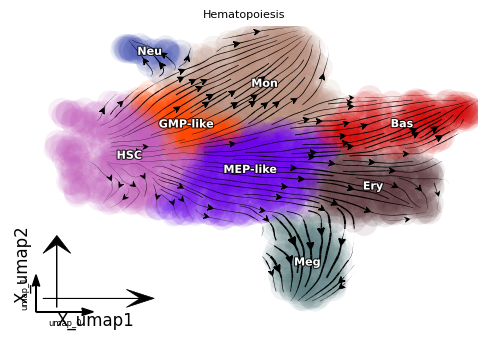

In [6]:
# %%
ax = dyn.pl.streamline_plot(adata, color=CLUSTER_KEY, basis="umap", show_legend="on data", show_arrowed_spines=True, size=(15,10), save_show_or_return='return')
ax[0].set_title("Hematopoiesis")
plt.show()

# %%
colors = {k:ax[0].get_children()[0]._facecolors[np.where(adata.obs[CLUSTER_KEY]==k)[0][0]] for k in adata.obs[CLUSTER_KEY].unique()}
for k in colors:
    colors[k][3] = 1

## 2. Load Scaffold from CellOracle

In [7]:
print("\n2. Loading CellOracle scaffold...")
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

# Create scaffold matrix
scaffold = pd.DataFrame(
    0,
    index=adata.var.index[genes_to_use],
    columns=adata.var.index[genes_to_use]
)

# Convert gene names to lowercase for case-insensitive comparison
tfs = list(set(base_GRN.columns.str.lower()) & set(scaffold.index.str.lower()))
target_genes = list(set(base_GRN['gene_short_name'].str.lower().values) & set(scaffold.columns.str.lower()))

# Map original names for assignment
index_map = {gene.lower(): gene for gene in scaffold.index}
col_map = {gene.lower(): gene for gene in scaffold.columns}

# Fill scaffold with 1s where connections exist
for tf in tfs:
    tf_original = index_map[tf]
    tf_base_GRN = [col for col in base_GRN.columns if col.lower() == tf][0]

    for target in base_GRN[base_GRN[tf_base_GRN] == 1]['gene_short_name']:
        if target.lower() in target_genes:
            target_original = col_map[target.lower()]
            scaffold.loc[tf_original, target_original] = 1

print(f"   Scaffold created: {scaffold.sum().sum()} potential connections")
print(f"   TFs: {len(tfs)}, Target genes: {len(target_genes)}")


2. Loading CellOracle scaffold...
   Scaffold created: 41693 potential connections
   TFs: 73, Target genes: 1148


In [8]:
sch.pp.fit_all_sigmoids(adata,
                         spliced_key=SPLICED_KEY,
                         genes=adata.var['use_for_dynamics'].values)

sch.pp.compute_sigmoid(adata, spliced_key=SPLICED_KEY, copy=False)

/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/packages/scHopfield/scHopfield/_utils/math.py:93: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


In [9]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [10]:
sch.inf.fit_interactions(adata,
                         cluster_key=CLUSTER_KEY,
                         spliced_key=SPLICED_KEY,
                         velocity_key=VELOCITY_KEY,
                         degradation_key=DEGRADATION_KEY,
                         w_threshold=1e-12,
                         w_scaffold=scaffold.values,
                         scaffold_regularization=1e-2,
                         only_TFs=True,
                         infer_I=True,
                         refit_gamma=False,
                         pre_initialize_W=False,
                         n_epochs=1000,
                         criterion='MSE',
                         batch_size=128,
                         skip_all=True,
                         use_scheduler=True,
                         get_plots=False,
                         device='cuda')

Inferring interaction matrix W and bias vector I for cluster Mon


/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))
Training Epochs:   1%|          | 11/1000 [00:00<00:22, 44.20it/s]

[Epoch 1/1000] Total Loss: 1509.789032, Reconstruction Loss: 10.120437, Batch size: 39


Training Epochs:  12%|█▏        | 120/1000 [00:01<00:08, 99.76it/s]

[Epoch 101/1000] Total Loss: 595.213211, Reconstruction Loss: 0.067123, Batch size: 39


Training Epochs:  22%|██▏       | 219/1000 [00:02<00:07, 102.26it/s]

[Epoch 201/1000] Total Loss: 484.249290, Reconstruction Loss: 0.014041, Batch size: 39


Training Epochs:  32%|███▏      | 318/1000 [00:03<00:06, 102.73it/s]

[Epoch 301/1000] Total Loss: 443.232246, Reconstruction Loss: 0.003048, Batch size: 39


Training Epochs:  42%|████▏     | 417/1000 [00:04<00:05, 102.71it/s]

[Epoch 401/1000] Total Loss: 426.914711, Reconstruction Loss: 0.001469, Batch size: 39


Training Epochs:  52%|█████▏    | 516/1000 [00:05<00:04, 102.56it/s]

[Epoch 501/1000] Total Loss: 420.202515, Reconstruction Loss: 0.001315, Batch size: 39


Training Epochs:  62%|██████▏   | 615/1000 [00:06<00:03, 102.63it/s]

[Epoch 601/1000] Total Loss: 417.501335, Reconstruction Loss: 0.001300, Batch size: 39


Training Epochs:  71%|███████▏  | 714/1000 [00:07<00:02, 102.69it/s]

[Epoch 701/1000] Total Loss: 416.416008, Reconstruction Loss: 0.001304, Batch size: 39


Training Epochs:  81%|████████▏ | 813/1000 [00:08<00:01, 103.06it/s]

[Epoch 801/1000] Total Loss: 415.982529, Reconstruction Loss: 0.001359, Batch size: 39


Training Epochs:  91%|█████████ | 912/1000 [00:09<00:00, 102.87it/s]

[Epoch 901/1000] Total Loss: 415.808929, Reconstruction Loss: 0.001318, Batch size: 39


Training Epochs: 100%|██████████| 1000/1000 [00:09<00:00, 100.54it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750534, Reconstruction Loss: 0.001333, Batch size: 39
Inferring interaction matrix W and bias vector I for cluster Meg


Training Epochs:   2%|▏         | 21/1000 [00:00<00:04, 208.92it/s]

[Epoch 1/1000] Total Loss: 1424.960388, Reconstruction Loss: 18.748348, Batch size: 26


Training Epochs:  14%|█▎        | 136/1000 [00:00<00:03, 221.57it/s]

[Epoch 101/1000] Total Loss: 631.340240, Reconstruction Loss: 0.122957, Batch size: 26


Training Epochs:  23%|██▎       | 228/1000 [00:01<00:03, 222.37it/s]

[Epoch 201/1000] Total Loss: 500.713074, Reconstruction Loss: 0.020975, Batch size: 26


Training Epochs:  34%|███▍      | 343/1000 [00:01<00:02, 221.93it/s]

[Epoch 301/1000] Total Loss: 449.445312, Reconstruction Loss: 0.008169, Batch size: 26


Training Epochs:  44%|████▎     | 435/1000 [00:01<00:02, 222.03it/s]

[Epoch 401/1000] Total Loss: 429.228882, Reconstruction Loss: 0.006607, Batch size: 26


Training Epochs:  53%|█████▎    | 527/1000 [00:02<00:02, 222.39it/s]

[Epoch 501/1000] Total Loss: 421.125748, Reconstruction Loss: 0.006335, Batch size: 26


Training Epochs:  64%|██████▍   | 642/1000 [00:02<00:01, 222.64it/s]

[Epoch 601/1000] Total Loss: 417.854355, Reconstruction Loss: 0.006752, Batch size: 26


Training Epochs:  73%|███████▎  | 734/1000 [00:03<00:01, 222.52it/s]

[Epoch 701/1000] Total Loss: 416.561172, Reconstruction Loss: 0.006903, Batch size: 26


Training Epochs:  83%|████████▎ | 826/1000 [00:03<00:00, 221.95it/s]

[Epoch 801/1000] Total Loss: 416.044846, Reconstruction Loss: 0.006933, Batch size: 26


Training Epochs:  94%|█████████▍| 941/1000 [00:04<00:00, 222.28it/s]

[Epoch 901/1000] Total Loss: 415.836868, Reconstruction Loss: 0.006749, Batch size: 26


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 222.03it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.757431, Reconstruction Loss: 0.007120, Batch size: 26
Inferring interaction matrix W and bias vector I for cluster MEP-like


Training Epochs:   1%|          | 9/1000 [00:00<00:11, 87.44it/s]

[Epoch 1/1000] Total Loss: 1503.818161, Reconstruction Loss: 5.460903, Batch size: 73


Training Epochs:  11%|█         | 111/1000 [00:01<00:08, 98.78it/s]

[Epoch 101/1000] Total Loss: 595.537338, Reconstruction Loss: 0.048519, Batch size: 73


Training Epochs:  21%|██▏       | 213/1000 [00:02<00:07, 99.55it/s]

[Epoch 201/1000] Total Loss: 483.689705, Reconstruction Loss: 0.009740, Batch size: 73


Training Epochs:  32%|███▏      | 321/1000 [00:03<00:06, 99.82it/s] 

[Epoch 301/1000] Total Loss: 443.511864, Reconstruction Loss: 0.001909, Batch size: 73


Training Epochs:  42%|████▏     | 416/1000 [00:04<00:05, 99.84it/s] 

[Epoch 401/1000] Total Loss: 426.967461, Reconstruction Loss: 0.000954, Batch size: 73


Training Epochs:  51%|█████▏    | 514/1000 [00:05<00:04, 99.90it/s] 

[Epoch 501/1000] Total Loss: 420.221657, Reconstruction Loss: 0.000848, Batch size: 73


Training Epochs:  62%|██████▏   | 617/1000 [00:06<00:03, 99.55it/s]

[Epoch 601/1000] Total Loss: 417.509743, Reconstruction Loss: 0.000862, Batch size: 73


Training Epochs:  71%|███████   | 712/1000 [00:07<00:02, 99.82it/s]

[Epoch 701/1000] Total Loss: 416.420853, Reconstruction Loss: 0.000855, Batch size: 73


Training Epochs:  82%|████████▏ | 817/1000 [00:08<00:01, 100.11it/s]

[Epoch 801/1000] Total Loss: 415.983627, Reconstruction Loss: 0.000877, Batch size: 73


Training Epochs:  92%|█████████▏| 915/1000 [00:09<00:00, 99.81it/s] 

[Epoch 901/1000] Total Loss: 415.809296, Reconstruction Loss: 0.000866, Batch size: 73


Training Epochs: 100%|██████████| 1000/1000 [00:10<00:00, 99.56it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.750420, Reconstruction Loss: 0.000875, Batch size: 73
Inferring interaction matrix W and bias vector I for cluster Ery


Training Epochs:   2%|▏         | 19/1000 [00:00<00:05, 188.67it/s]

[Epoch 1/1000] Total Loss: 1418.707397, Reconstruction Loss: 13.101830, Batch size: 106


Training Epochs:  14%|█▍        | 139/1000 [00:00<00:04, 194.88it/s]

[Epoch 101/1000] Total Loss: 626.512054, Reconstruction Loss: 0.102618, Batch size: 106


Training Epochs:  24%|██▍       | 239/1000 [00:01<00:03, 195.29it/s]

[Epoch 201/1000] Total Loss: 499.823090, Reconstruction Loss: 0.016628, Batch size: 106


Training Epochs:  34%|███▍      | 339/1000 [00:01<00:03, 195.46it/s]

[Epoch 301/1000] Total Loss: 449.324951, Reconstruction Loss: 0.003644, Batch size: 106


Training Epochs:  44%|████▍     | 439/1000 [00:02<00:02, 195.70it/s]

[Epoch 401/1000] Total Loss: 429.217636, Reconstruction Loss: 0.002302, Batch size: 106


Training Epochs:  54%|█████▍    | 539/1000 [00:02<00:02, 195.62it/s]

[Epoch 501/1000] Total Loss: 421.098969, Reconstruction Loss: 0.002086, Batch size: 106


Training Epochs:  64%|██████▍   | 639/1000 [00:03<00:01, 195.63it/s]

[Epoch 601/1000] Total Loss: 417.853806, Reconstruction Loss: 0.002075, Batch size: 106


Training Epochs:  74%|███████▍  | 739/1000 [00:03<00:01, 195.45it/s]

[Epoch 701/1000] Total Loss: 416.556763, Reconstruction Loss: 0.002089, Batch size: 106


Training Epochs:  84%|████████▍ | 839/1000 [00:04<00:00, 194.60it/s]

[Epoch 801/1000] Total Loss: 416.040390, Reconstruction Loss: 0.002093, Batch size: 106


Training Epochs:  94%|█████████▍| 939/1000 [00:04<00:00, 195.04it/s]

[Epoch 901/1000] Total Loss: 415.832748, Reconstruction Loss: 0.002085, Batch size: 106


Training Epochs: 100%|██████████| 1000/1000 [00:05<00:00, 195.18it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.752533, Reconstruction Loss: 0.002085, Batch size: 106
Inferring interaction matrix W and bias vector I for cluster Bas


Training Epochs:   2%|▏         | 19/1000 [00:00<00:05, 186.15it/s]

[Epoch 1/1000] Total Loss: 1422.293091, Reconstruction Loss: 16.389677, Batch size: 49


Training Epochs:  13%|█▎        | 129/1000 [00:00<00:04, 213.06it/s]

[Epoch 101/1000] Total Loss: 631.788696, Reconstruction Loss: 0.134767, Batch size: 49


Training Epochs:  24%|██▍       | 239/1000 [00:01<00:03, 213.88it/s]

[Epoch 201/1000] Total Loss: 500.006531, Reconstruction Loss: 0.018459, Batch size: 49


Training Epochs:  33%|███▎      | 327/1000 [00:01<00:03, 214.05it/s]

[Epoch 301/1000] Total Loss: 449.361099, Reconstruction Loss: 0.004647, Batch size: 49


Training Epochs:  44%|████▎     | 437/1000 [00:02<00:02, 214.10it/s]

[Epoch 401/1000] Total Loss: 429.220306, Reconstruction Loss: 0.002898, Batch size: 49


Training Epochs:  52%|█████▎    | 525/1000 [00:02<00:02, 214.12it/s]

[Epoch 501/1000] Total Loss: 421.108139, Reconstruction Loss: 0.002675, Batch size: 49


Training Epochs:  64%|██████▎   | 635/1000 [00:02<00:01, 214.60it/s]

[Epoch 601/1000] Total Loss: 417.849945, Reconstruction Loss: 0.002698, Batch size: 49


Training Epochs:  72%|███████▏  | 723/1000 [00:03<00:01, 213.93it/s]

[Epoch 701/1000] Total Loss: 416.556885, Reconstruction Loss: 0.002686, Batch size: 49


Training Epochs:  83%|████████▎ | 833/1000 [00:03<00:00, 214.07it/s]

[Epoch 801/1000] Total Loss: 416.040436, Reconstruction Loss: 0.002703, Batch size: 49


Training Epochs:  94%|█████████▍| 943/1000 [00:04<00:00, 213.95it/s]

[Epoch 901/1000] Total Loss: 415.833054, Reconstruction Loss: 0.002690, Batch size: 49


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 213.53it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.753098, Reconstruction Loss: 0.002732, Batch size: 49
Inferring interaction matrix W and bias vector I for cluster GMP-like


Training Epochs:   2%|▏         | 20/1000 [00:00<00:05, 193.00it/s]

[Epoch 1/1000] Total Loss: 1413.021484, Reconstruction Loss: 7.136714, Batch size: 33


Training Epochs:  13%|█▎        | 131/1000 [00:00<00:04, 217.02it/s]

[Epoch 101/1000] Total Loss: 625.734131, Reconstruction Loss: 0.065601, Batch size: 33


Training Epochs:  24%|██▍       | 241/1000 [00:01<00:03, 217.81it/s]

[Epoch 201/1000] Total Loss: 499.974564, Reconstruction Loss: 0.008304, Batch size: 33


Training Epochs:  33%|███▎      | 329/1000 [00:01<00:03, 217.96it/s]

[Epoch 301/1000] Total Loss: 449.591949, Reconstruction Loss: 0.001590, Batch size: 33


Training Epochs:  44%|████▍     | 439/1000 [00:02<00:02, 217.75it/s]

[Epoch 401/1000] Total Loss: 429.290527, Reconstruction Loss: 0.000749, Batch size: 33


Training Epochs:  53%|█████▎    | 528/1000 [00:02<00:02, 218.22it/s]

[Epoch 501/1000] Total Loss: 421.142548, Reconstruction Loss: 0.000621, Batch size: 33


Training Epochs:  64%|██████▍   | 638/1000 [00:02<00:01, 216.80it/s]

[Epoch 601/1000] Total Loss: 417.868820, Reconstruction Loss: 0.000648, Batch size: 33


Training Epochs:  73%|███████▎  | 726/1000 [00:03<00:01, 217.48it/s]

[Epoch 701/1000] Total Loss: 416.564255, Reconstruction Loss: 0.000633, Batch size: 33


Training Epochs:  84%|████████▎ | 836/1000 [00:03<00:00, 217.82it/s]

[Epoch 801/1000] Total Loss: 416.042328, Reconstruction Loss: 0.000625, Batch size: 33


Training Epochs:  92%|█████████▏| 924/1000 [00:04<00:00, 217.69it/s]

[Epoch 901/1000] Total Loss: 415.832504, Reconstruction Loss: 0.000634, Batch size: 33


Training Epochs: 100%|██████████| 1000/1000 [00:04<00:00, 217.32it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.751526, Reconstruction Loss: 0.000627, Batch size: 33
Inferring interaction matrix W and bias vector I for cluster HSC


Training Epochs:   1%|▏         | 13/1000 [00:00<00:07, 125.37it/s]

[Epoch 1/1000] Total Loss: 1602.675578, Reconstruction Loss: 4.472458, Batch size: 53


Training Epochs:  12%|█▎        | 125/1000 [00:00<00:06, 134.69it/s]

[Epoch 101/1000] Total Loss: 606.164754, Reconstruction Loss: 0.062659, Batch size: 53


Training Epochs:  22%|██▏       | 223/1000 [00:01<00:05, 134.84it/s]

[Epoch 201/1000] Total Loss: 493.809448, Reconstruction Loss: 0.009048, Batch size: 53


Training Epochs:  32%|███▏      | 321/1000 [00:02<00:05, 134.63it/s]

[Epoch 301/1000] Total Loss: 447.392853, Reconstruction Loss: 0.002353, Batch size: 53


Training Epochs:  42%|████▏     | 419/1000 [00:03<00:04, 137.16it/s]

[Epoch 401/1000] Total Loss: 428.388062, Reconstruction Loss: 0.000811, Batch size: 53


Training Epochs:  52%|█████▏    | 517/1000 [00:03<00:03, 137.65it/s]

[Epoch 501/1000] Total Loss: 420.760427, Reconstruction Loss: 0.000662, Batch size: 53


Training Epochs:  62%|██████▏   | 615/1000 [00:04<00:02, 137.64it/s]

[Epoch 601/1000] Total Loss: 417.717601, Reconstruction Loss: 0.000639, Batch size: 53


Training Epochs:  73%|███████▎  | 727/1000 [00:05<00:01, 137.43it/s]

[Epoch 701/1000] Total Loss: 416.503499, Reconstruction Loss: 0.000654, Batch size: 53


Training Epochs:  82%|████████▎ | 825/1000 [00:06<00:01, 137.49it/s]

[Epoch 801/1000] Total Loss: 416.015462, Reconstruction Loss: 0.000643, Batch size: 53


Training Epochs:  92%|█████████▏| 923/1000 [00:06<00:00, 137.74it/s]

[Epoch 901/1000] Total Loss: 415.821615, Reconstruction Loss: 0.000656, Batch size: 53


Training Epochs: 100%|██████████| 1000/1000 [00:07<00:00, 136.57it/s]
/home/bernaljp/packages/scHopfield/scHopfield/inference/optimizer.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('mask', torch.tensor(mask, dtype=torch.float32, device=device))


[Epoch 1000/1000] Total Loss: 415.749095, Reconstruction Loss: 0.000662, Batch size: 53
Inferring interaction matrix W and bias vector I for cluster Neu


Training Epochs:   5%|▌         | 50/1000 [00:00<00:01, 493.92it/s]

[Epoch 1/1000] Total Loss: 723.818176, Reconstruction Loss: 0.437787, Batch size: 32


Training Epochs:  10%|█         | 101/1000 [00:00<00:01, 498.32it/s]

[Epoch 101/1000] Total Loss: 637.207520, Reconstruction Loss: 0.378067, Batch size: 32


Training Epochs:  15%|█▌        | 152/1000 [00:00<00:01, 502.36it/s]

[Epoch 201/1000] Total Loss: 507.312897, Reconstruction Loss: 0.039462, Batch size: 32


Training Epochs:  25%|██▌       | 254/1000 [00:00<00:01, 503.39it/s]

[Epoch 301/1000] Total Loss: 451.593018, Reconstruction Loss: 0.008690, Batch size: 32


Training Epochs:  36%|███▌      | 356/1000 [00:00<00:01, 503.92it/s]

[Epoch 401/1000] Total Loss: 430.507416, Reconstruction Loss: 0.005057, Batch size: 32


Training Epochs:  46%|████▌     | 458/1000 [00:00<00:01, 503.29it/s]

[Epoch 501/1000] Total Loss: 421.658112, Reconstruction Loss: 0.004819, Batch size: 32


Training Epochs:  56%|█████▌    | 560/1000 [00:01<00:00, 504.46it/s]

[Epoch 601/1000] Total Loss: 418.062408, Reconstruction Loss: 0.004843, Batch size: 32


Training Epochs:  66%|██████▌   | 662/1000 [00:01<00:00, 504.54it/s]

[Epoch 701/1000] Total Loss: 416.649170, Reconstruction Loss: 0.004848, Batch size: 32


Training Epochs:  76%|███████▋  | 764/1000 [00:01<00:00, 504.77it/s]

[Epoch 801/1000] Total Loss: 416.078583, Reconstruction Loss: 0.004857, Batch size: 32


Training Epochs:  87%|████████▋ | 867/1000 [00:01<00:00, 505.43it/s]

[Epoch 901/1000] Total Loss: 415.849884, Reconstruction Loss: 0.004860, Batch size: 32


Training Epochs: 100%|██████████| 1000/1000 [00:01<00:00, 503.10it/s]


[Epoch 1000/1000] Total Loss: 415.757477, Reconstruction Loss: 0.004861, Batch size: 32


# Energies

In [11]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

In [12]:
# Compute energies using scHopfield
sch.tl.compute_energies(adata, cluster_key=CLUSTER_KEY)

In [13]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [14]:
summary_stats = adata.obs[[CLUSTER_KEY,'energy_total','energy_interaction','energy_degradation','energy_bias']].groupby(CLUSTER_KEY).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]
summary_stats['energy_total']

count       mean       std       min       25%        50%  \
cell_type                                                              
Bas        177.0   7.797485  1.730034  3.712380  6.674236   8.255864   
Ery        234.0   6.891914  1.139322  3.483127  6.329609   6.739308   
GMP-like   161.0   4.353769  0.748404  3.330563  3.792112   4.021739   
HSC        309.0   4.243155  0.601479  3.281035  3.836133   4.131129   
MEP-like   457.0   4.884904  0.954166  3.514649  4.247149   4.587717   
Meg        154.0  10.671720  1.439129  5.690758  9.967338  10.804190   
Mon        423.0   5.775800  0.864478  3.316998  5.484037   5.784727   
Neu         32.0   8.906930  0.387754  7.276173  8.899908   9.014990   

                 75%        max        cv  
cell_type                                  
Bas         9.335229  10.195696  0.221871  
Ery         7.176394  12.106707  0.165313  
GMP-like    5.116371   6.289766  0.171898  
HSC         4.499209   7.278572  0.141753  
MEP-like    5.396781   9.588396  0.195330  
Meg        11.658403  12.814217  0.134854  
Mon         6.121707  12.678034  0.149672  
Neu         9.104864   9.251906  0.043534

array([<Axes3DSubplot: >], dtype=object)

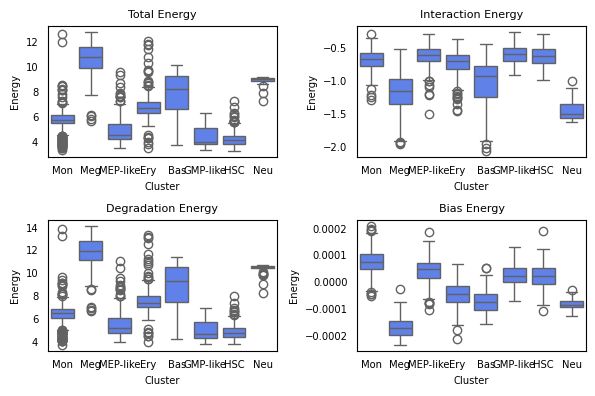

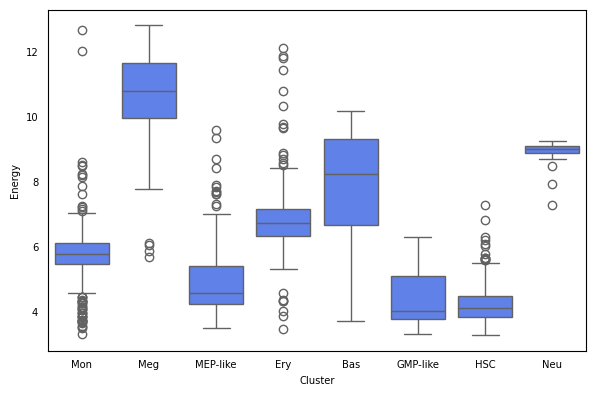

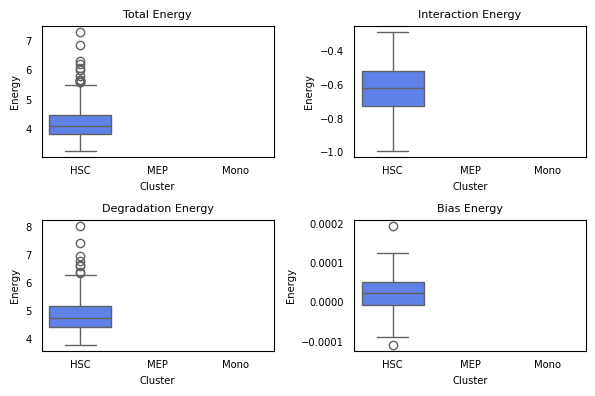

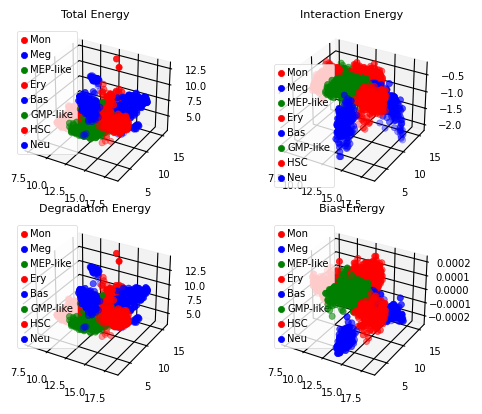

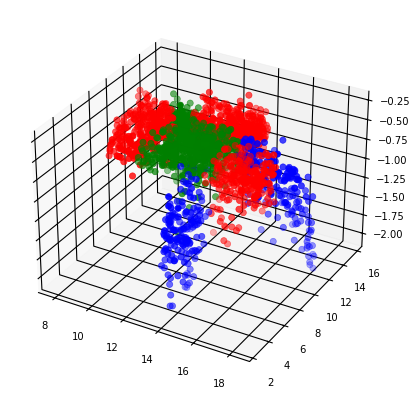

In [15]:
# Plot boxplots for all energy types
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type')

# Plot only total energy boxplot
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type', plot_energy='total')

# Plot with custom order and colors
sch.pl.plot_energy_boxplots(adata, cluster_key='cell_type',
                            order=['HSC', 'MEP', 'Mono'],
                            colors=['red', 'blue', 'green'])

# 3D scatter plots
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                            basis='umap', show_legend=True)

# Plot specific energy type
sch.pl.plot_energy_scatters(adata, cluster_key='cell_type',
                              plot_energy='interaction')

# Dendrograms

## Cell type dendrogram

In [16]:
# Compute celltype correlation using scHopfield
sch.tl.celltype_correlation(adata, spliced_key=SPLICED_KEY,cluster_key=CLUSTER_KEY)

<Figure size 900x300 with 0 Axes>

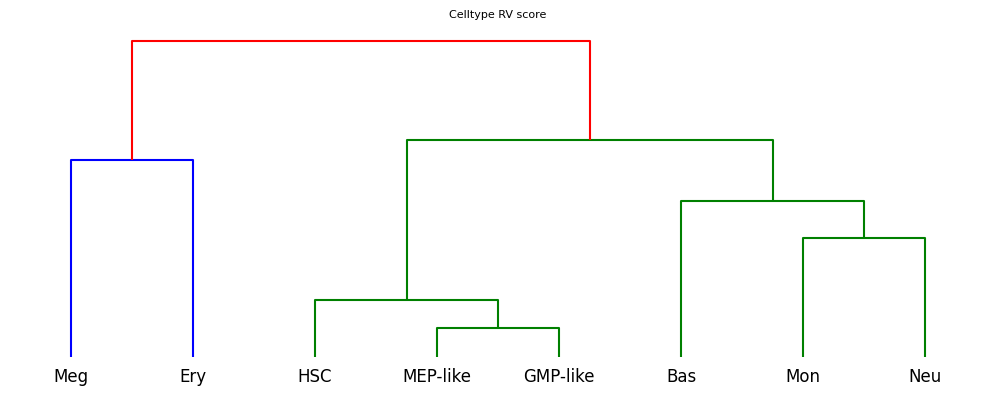

In [17]:
cells_correlation = adata.uns['scHopfield']['celltype_correlation']
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-cells_correlation), 'complete')
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

## Network dendrogram

In [18]:
# Compute network correlations using scHopfield
sch.tl.network_correlations(adata, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [19]:
pearson = adata.uns['scHopfield']['network_correlations']['pearson']
hamming = adata.uns['scHopfield']['network_correlations']['hamming']
pearson_bin = adata.uns['scHopfield']['network_correlations']['pearson_bin']

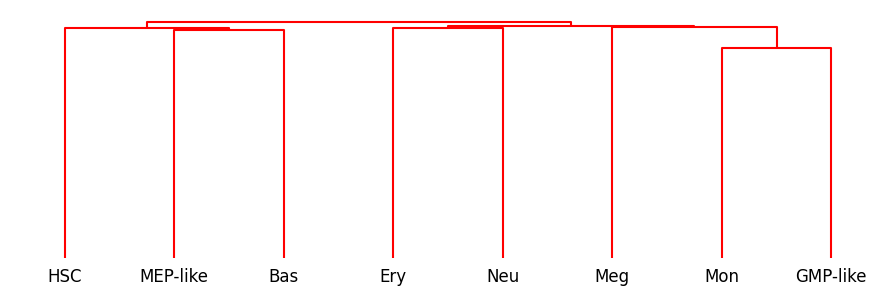

In [20]:
fig,axs = plt.subplots(1,1,figsize=(9, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson.index)
plt.show()

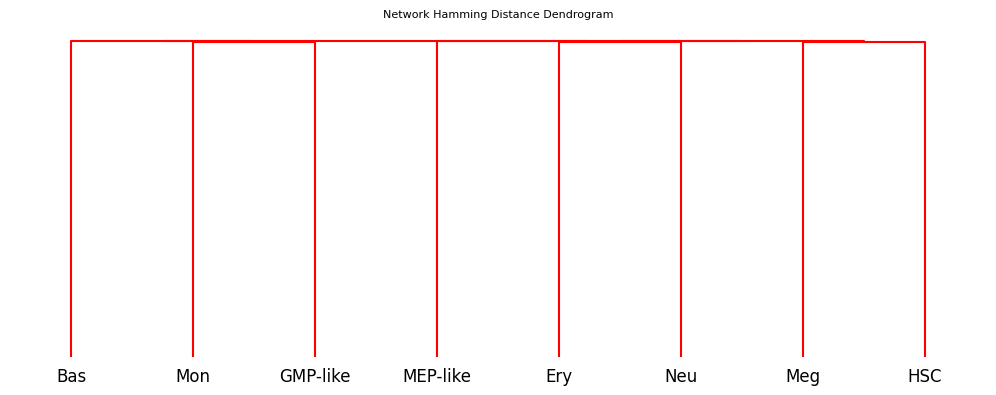

In [21]:
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Network Hamming Distance Dendrogram')

Z = scp.cluster.hierarchy.linkage(squareform(hamming), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = hamming.index)
plt.show()

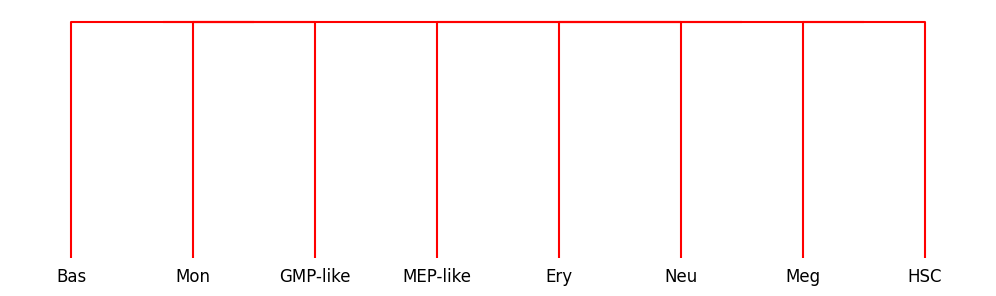

In [22]:
fig,axs = plt.subplots(1,1,figsize=(10, 3), tight_layout=True)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

Z = scp.cluster.hierarchy.linkage(squareform(1-pearson_bin), 'complete')
scp.cluster.hierarchy.dendrogram(Z, labels = pearson_bin.index)
plt.show()

# Symmetricity

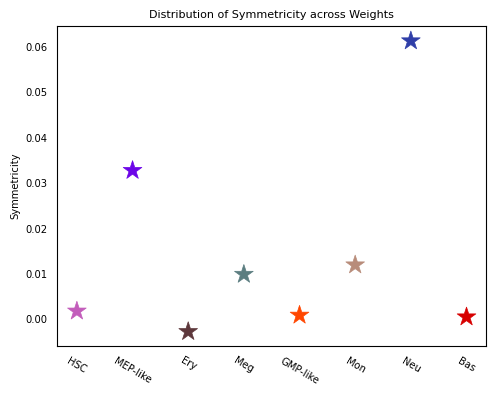

In [23]:
def symmetricity(A, norm=2):
    S = np.linalg.norm((A+A.T)/2, ord=norm)
    As = np.linalg.norm((A-A.T)/2, ord=norm)
    return (S-As)/(S+As)

# Get interaction matrices from scHopfield storage
W = {}
genes_used = adata.var['use_for_dynamics'].values
gene_names = adata.var_names[genes_used]
for cluster in CELL_TYPE_ORDER:
    W[cluster] = adata.varp[f'W_{cluster}'][genes_used][:,genes_used]

syms = np.array([symmetricity(W[k], norm=2) for k in CELL_TYPE_ORDER])
idxs = np.argsort(syms)
plt.figure(figsize=(5,4), tight_layout=True)
plt.scatter(range(len(W)), syms, s=200, marker='*', c=[colors[i] for i in CELL_TYPE_ORDER])
plt.xticks(range(len(W)), np.array(CELL_TYPE_ORDER))
plt.ylabel('Symmetricity')
plt.xticks(rotation=-30)
plt.title('Distribution of Symmetricity across Weights')
plt.show()

# Model Analysis

In [24]:
gamma = {}
I = {}
for cluster in CELL_TYPE_ORDER:
    gamma[cluster] = adata.var[f'gamma_{cluster}'].values[genes_used] if f'gamma_{cluster}' in adata.var.columns else adata.var[DEGRADATION_KEY].values[genes_used]
    I[cluster] = adata.var[f'I_{cluster}'].values[genes_used] if f'I_{cluster}' in adata.var.columns else np.zeros(genes_used.sum())

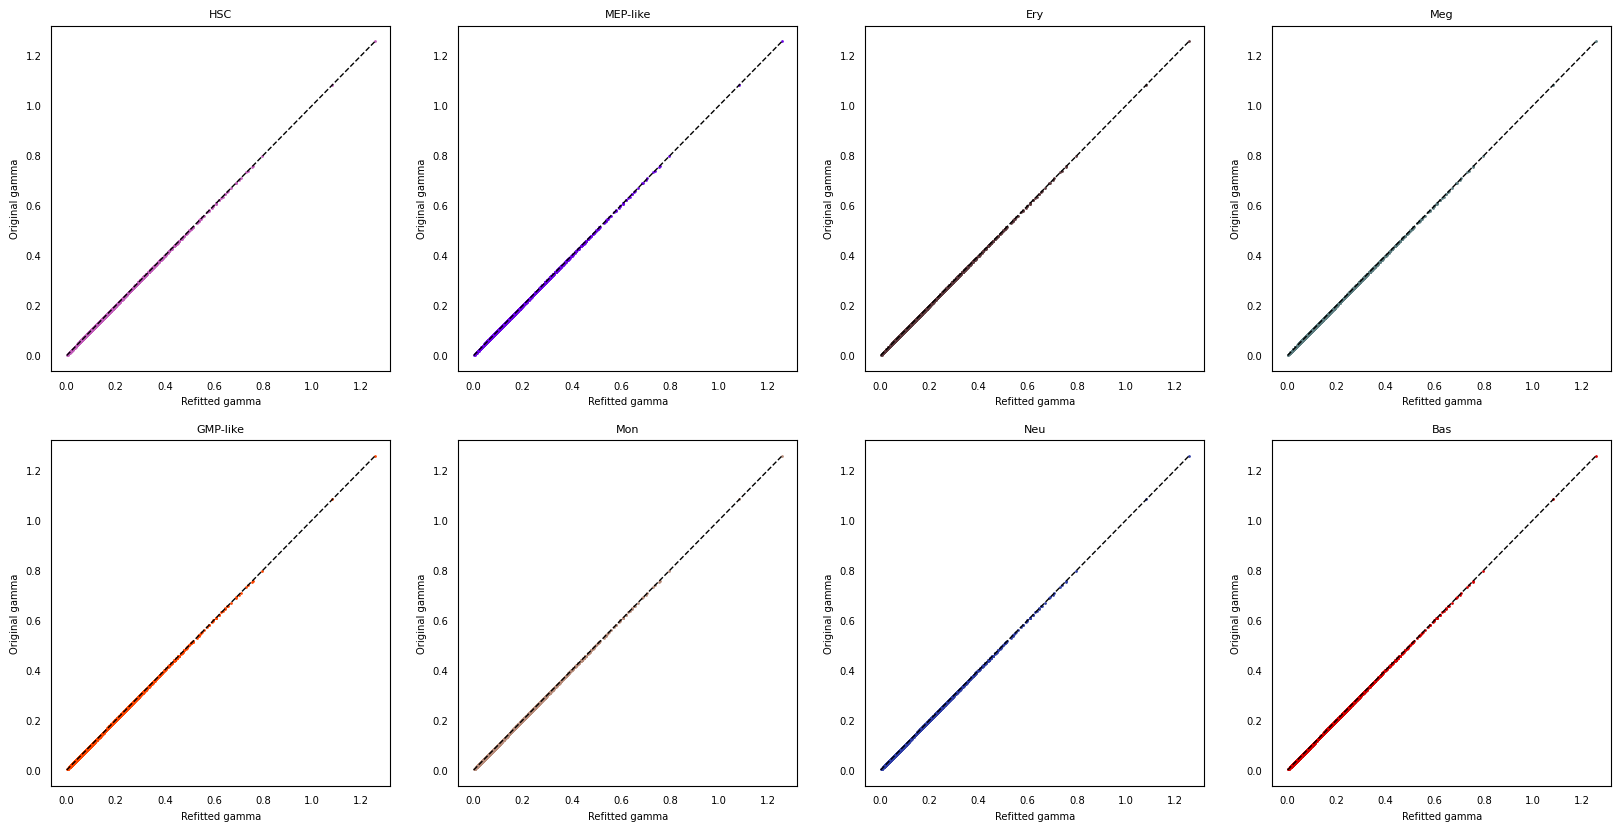

In [25]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
    ax.scatter(gamma[cl], adata.var[DEGRADATION_KEY][genes_used], color=colors[cl], s=2)
    ax.set_title(cl)
    max_gamma = max(np.concatenate([gamma[cl], adata.var[DEGRADATION_KEY][genes_used]]))
    ax.set_xlabel('Refitted gamma')
    ax.set_ylabel('Original gamma')
    ax.plot([0, max_gamma], [0, max_gamma], color='k', ls='--', lw=1)
plt.show()

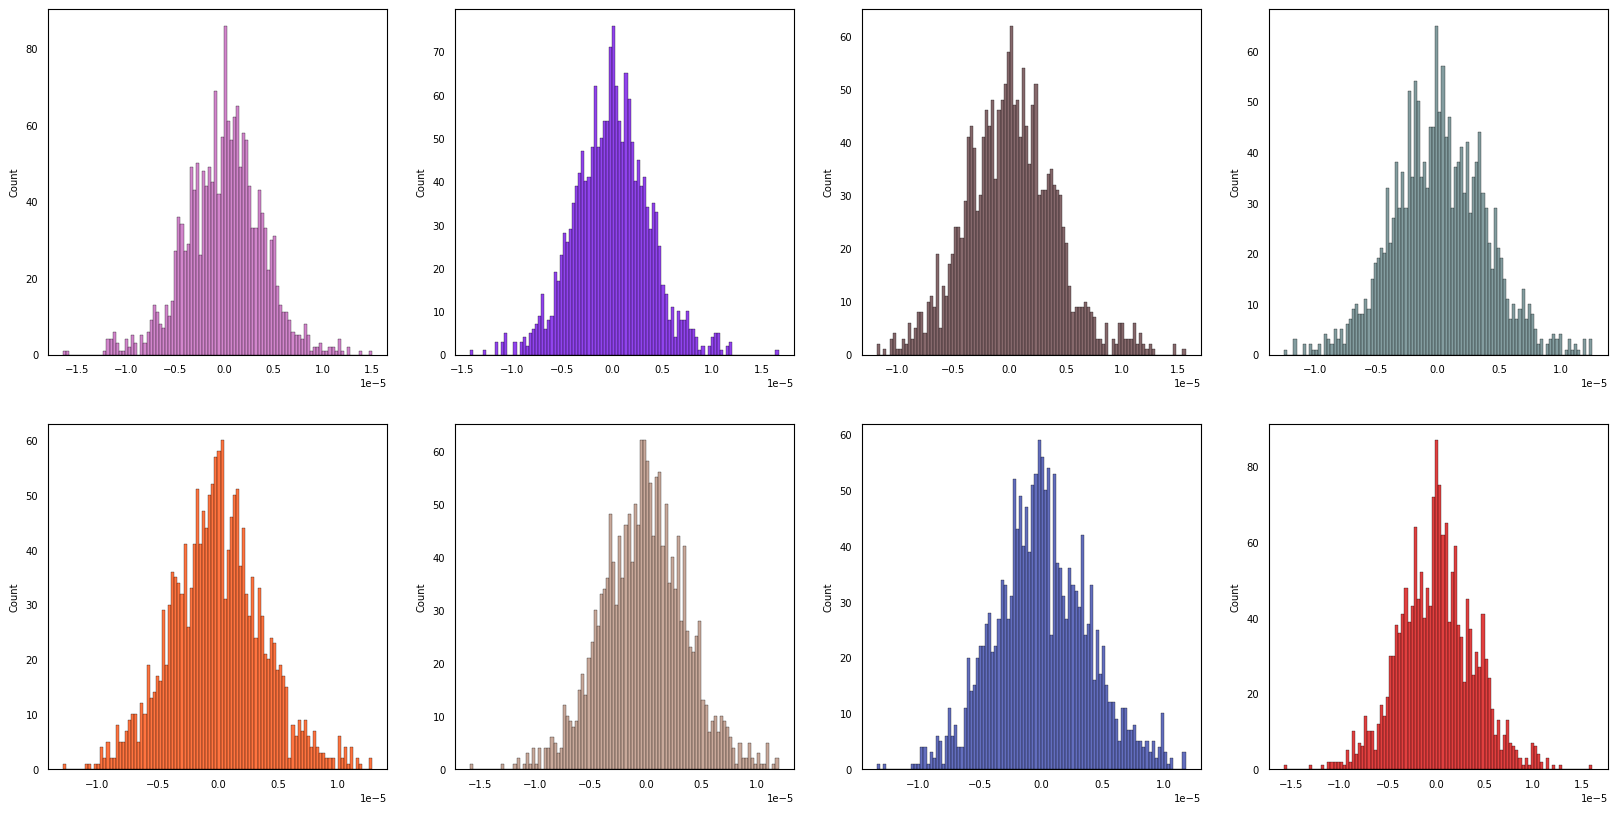

In [26]:
fig,axs = plt.subplots(2,4,figsize=(20,10))
for cl,ax in zip(CELL_TYPE_ORDER,axs.flatten()):
   sns.histplot(I[cl].flatten(), bins=100,ax=ax, color=colors[cl])
plt.show()

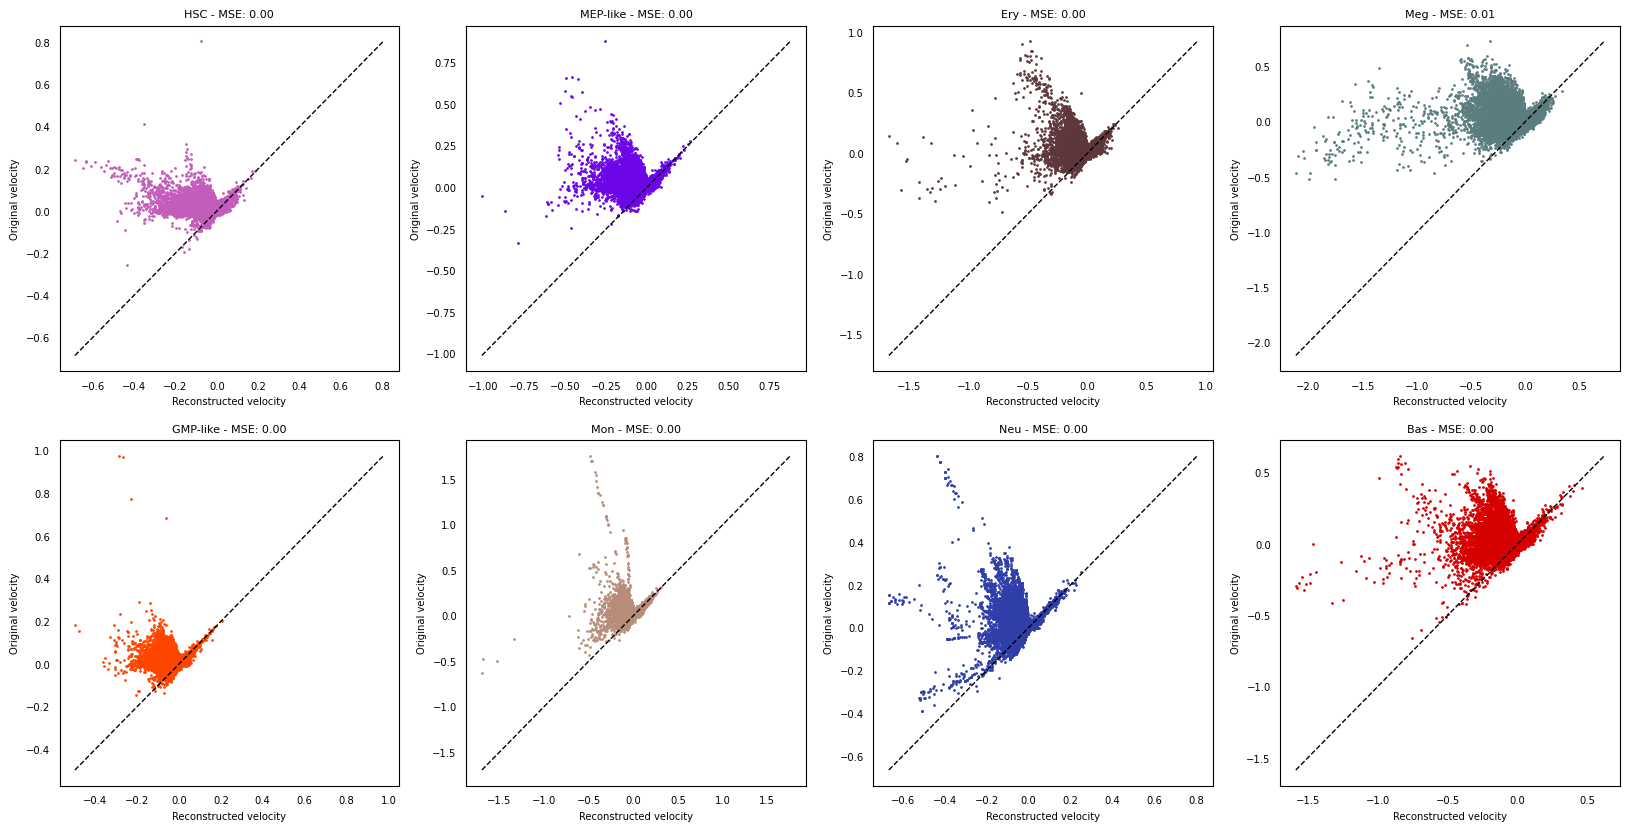

In [27]:
# Get MSE for each cluster
mse_dict = sch.tl.validate_velocity(
    adata,
    velocity_key=VELOCITY_KEY,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    return_mse=False  # Returns dict with per-cluster MSE
)

# Then plot
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for cl, ax in zip(CELL_TYPE_ORDER, axs.flatten()):
    reconstructed_v = sch.tl.compute_reconstructed_velocity(
        adata, cluster=cl, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY
    )

    genes_used = sch._utils.io.get_genes_used(adata)
    cluster_mask = (adata.obs[CLUSTER_KEY] == cl).values
    original_v = adata.layers[VELOCITY_KEY][cluster_mask][:, genes_used]

    ax.scatter(reconstructed_v.flatten(), original_v.toarray().flatten(), color=colors[cl], s=2)
    ax.set_title(f'{cl} - MSE: {mse_dict[cl]:.2f}')
    ax.set_xlabel('Reconstructed velocity')
    ax.set_ylabel('Original velocity')

    min_v = min(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    max_v = max(np.concatenate([reconstructed_v.flatten(), original_v.toarray().flatten()]))
    ax.plot([min_v, max_v], [min_v, max_v], c='k', ls='--', lw=1)

plt.show()

# Correlations

In [28]:
# Compute energy-gene correlations using scHopfield
sch.tl.energy_gene_correlation(adata, spliced_key=SPLICED_KEY, cluster_key=CLUSTER_KEY)

/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/miniconda3/envs/SCH/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered i

In [29]:
df_correlations = sch.tl.get_correlation_table(
      adata,
      cluster_key=CLUSTER_KEY,
      energy_type='total',  # or 'interaction', 'degradation', 'bias'
      n_top_genes=100,
      order=CELL_TYPE_ORDER  # optional: specify cluster order
  )
df_correlations

HSC                MEP-like                   Ery              \
        Gene Correlation        Gene Correlation      Gene Correlation   
0       CRYM    0.738057        RORA    0.830472    DIAPH1    0.852259   
1       RORA    0.707064    SLC30A10    0.820693    ITGA2B    0.834533   
2   SLC30A10    0.702620  AC108519.1    0.813960    HEXIM1    0.832440   
3      TIAM1    0.696503     PGAM1P5    0.811414     PTGS1    0.826834   
4      EXTL3    0.693417       MBNL3    0.811352     IL21R    0.822440   
..       ...         ...         ...         ...       ...         ...   
95   PLEKHG3    0.442989         EYS    0.553818  KIAA0513    0.671851   
96      NOL6    0.442832       IGF2R    0.553697    SH3BP5    0.670372   
97  C15orf39    0.441984     SMARCD2    0.550268     ITGB5    0.670271   
98     INTS5    0.441710     CDK2AP2    0.548118    SAMD14    0.669812   
99     DDX41    0.441207        CTSD    0.548004       MN1    0.666968   

       Meg             GMP-like                  Mon                  Neu  \
      Gene Correlation     Gene Correlation     Gene Correlation     Gene   
0    LTBP1    0.927437     RORA    0.868942     GPX1    0.688218  S100A11   
1     GPX1    0.913565  PGAM1P5    0.867664     PPIF    0.687938    CD151   
2      GSN    0.900536    MBNL3    0.866050  PGAM1P5    0.655374    FMNL3   
3     PLEK    0.896953    EXTL3    0.864642     LMNA    0.644039     LGMN   
4   FERMT3    0.896041    TIAM1    0.858938     PATJ    0.641881    PPM1F   
..     ...         ...      ...         ...      ...         ...      ...   
95    PBX1    0.741959     BYSL    0.603931   HEXIM1    0.503882     MYL6   
96  C2CD2L    0.740730      FBL    0.602635    ABCC3    0.503098     DGKH   
97    FLI1    0.738321    PSMB3    0.602557   WASH4P    0.498714    GGPS1   
98  NCKAP1    0.736467   PLCXD1    0.600729    RAB3C    0.498263     CBX6   
99     ILK    0.734588   SDF2L1    0.600167    VPS18    0.497339     SRGN   

                      Bas              
   Correlation       Gene Correlation  
0     0.909808        LIF    0.901967  
1     0.897035      CKAP4    0.897799  
2     0.891752       JUND    0.888242  
3     0.887108      AHNAK    0.880252  
4     0.885801       MYL6    0.876926  
..         ...        ...         ...  
95    0.811159       CRYM    0.739921  
96    0.811090  LINC00623    0.737697  
97    0.809379    ALOX5AP    0.736837  
98    0.808213       PATJ    0.735757  
99    0.806937      IL2RG    0.735116  

[100 rows x 16 columns]

In [30]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

In [31]:
# Get genes used in analysis
genes = sch._utils.io.get_genes_used(adata)
gene_names = adata.var.index[genes]

# Build correlation dictionary from adata.var columns
correlation = {}
for cluster in CELL_TYPE_ORDER:
    corr_col = f'correlation_total_{cluster}'
    if corr_col in adata.var.columns:
        correlation[cluster] = adata.var[corr_col].values[genes]
    else:
        print(f"Warning: No correlation data for {cluster}")

# Also check for 'all' if it exists
if 'correlation_total_all' in adata.var.columns:
    correlation['all'] = adata.var['correlation_total_all'].values[genes]

# Find corner genes
corner_genes = np.array([])
clus1_low = -0.4
clus1_high = 0.4
clus2_low = -0.4
clus2_high = 0.4
nn = 5

for corr1, corr2 in itertools.combinations(CELL_TYPE_ORDER, 2):
    if corr1 not in correlation or corr2 not in correlation:
        continue

    corr1_vals = correlation[corr1]
    corr2_vals = correlation[corr2]

    positions_corners = np.logical_or(
        np.logical_and(corr1_vals >= clus1_high, corr2_vals <= clus2_low),
        np.logical_and(corr1_vals <= clus1_low, corr2_vals >= clus2_high)
    )

    corr_corners = np.where(positions_corners)[0]
    corr_indices = np.argsort((corr1_vals[corr_corners])**2 + (corr2_vals[corr_corners])**2)[-nn:]
    corr_corners = corr_corners[corr_indices]
    corner_genes = np.concatenate((corner_genes, gene_names[corr_corners]))

corner_genes = np.unique(corner_genes)

# Create DataFrame from correlation dictionary
df_corr_corners = pd.DataFrame.from_dict(correlation)
df_corr_corners.drop('all', axis=1, inplace=True, errors='ignore')
df_corr_corners.index = gene_names
df_corr_corners = df_corr_corners.loc[corner_genes]

print(f"Found {len(corner_genes)} corner genes")

Found 57 corner genes


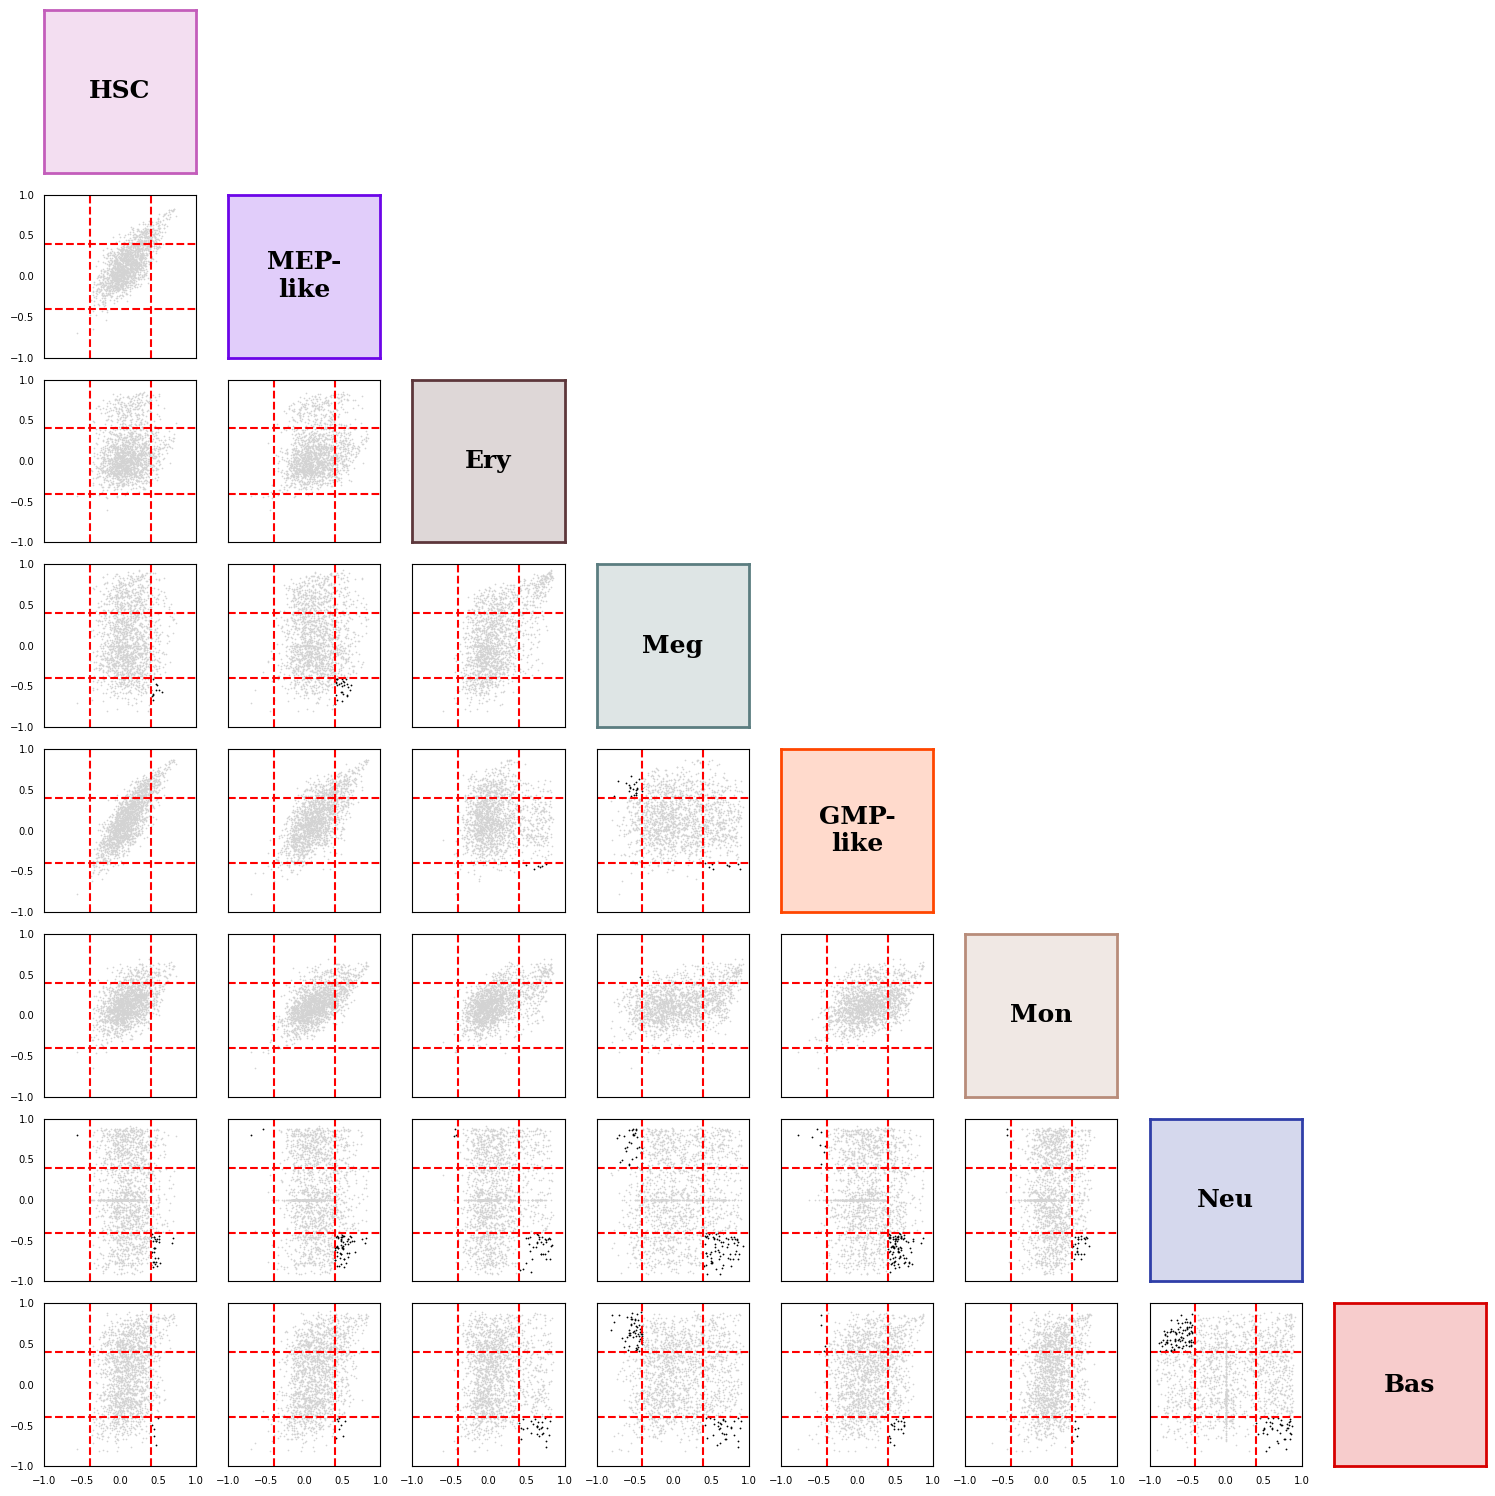

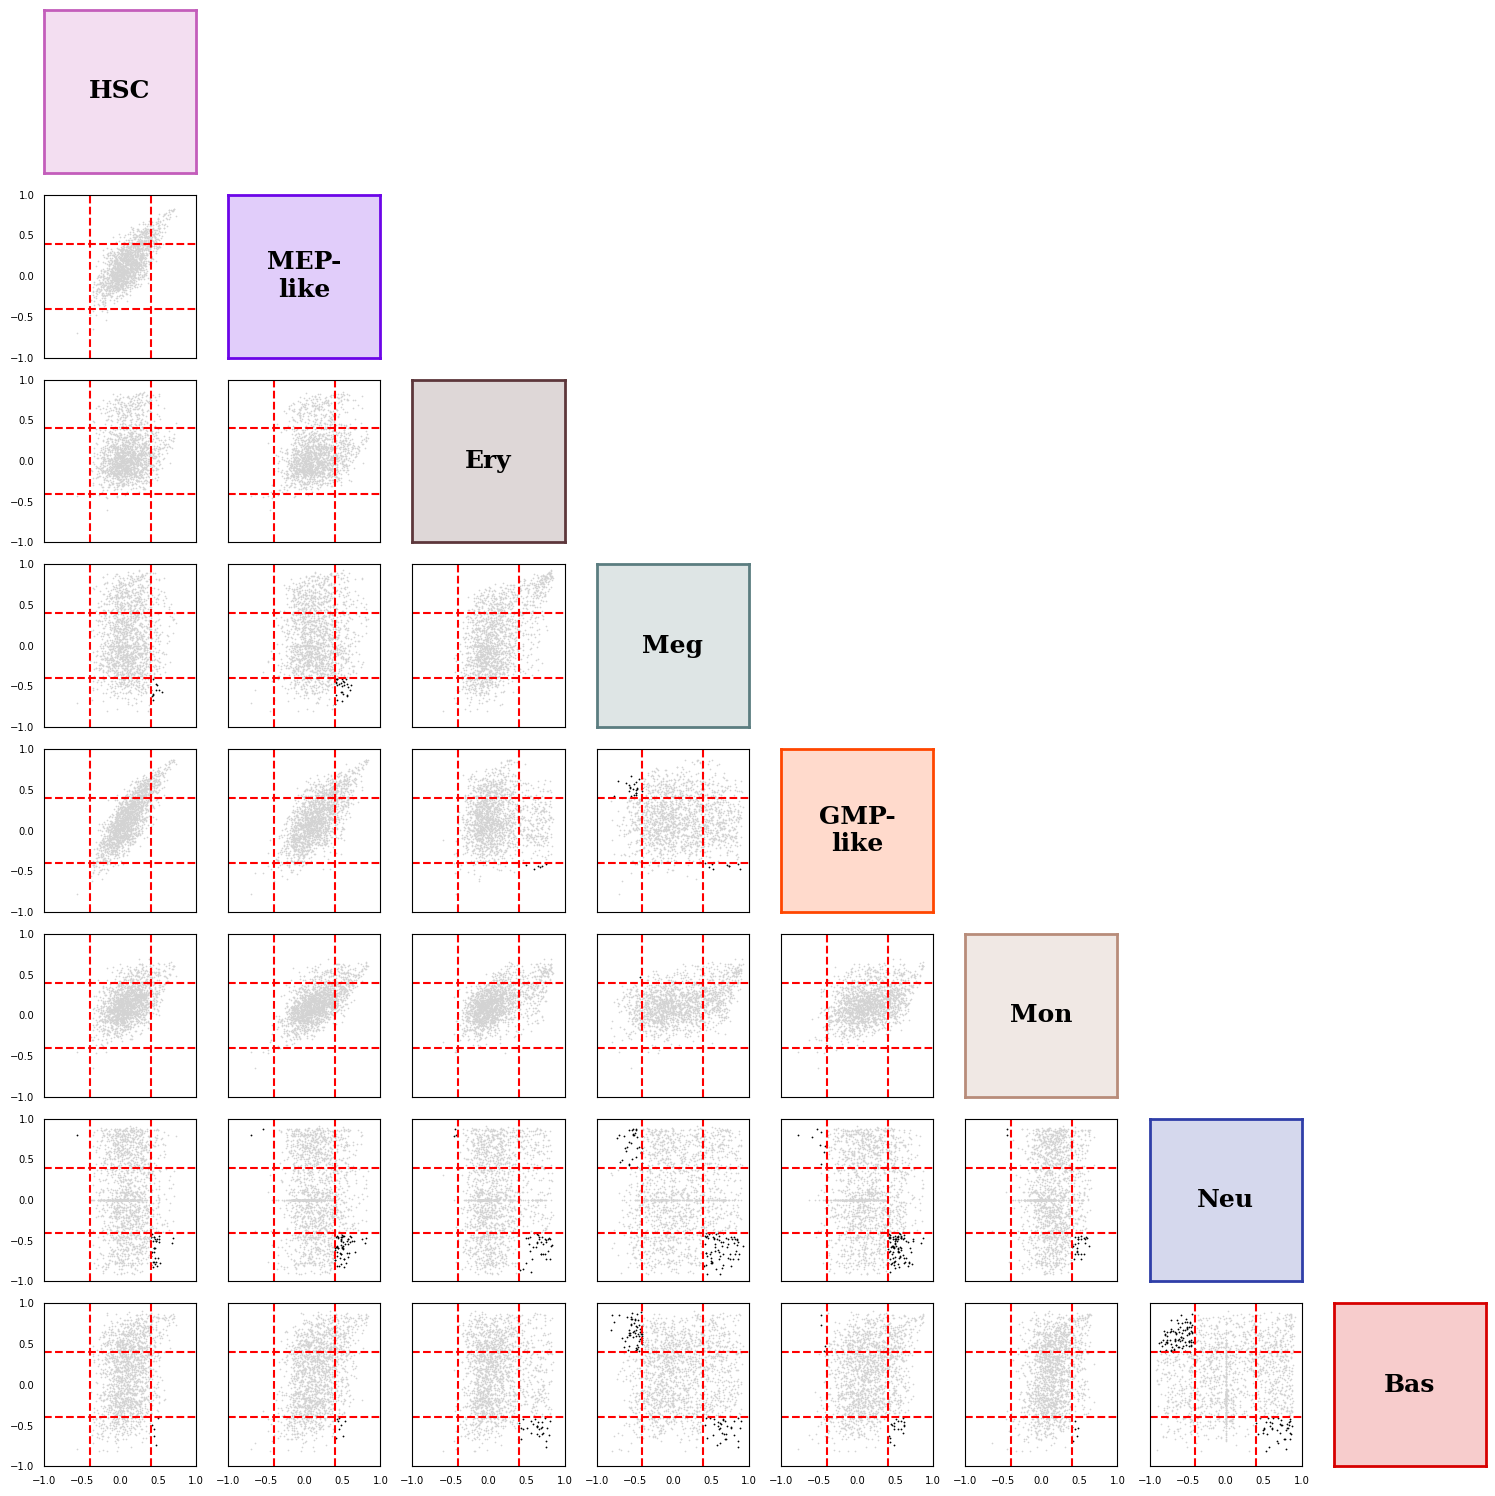

In [32]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='total',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

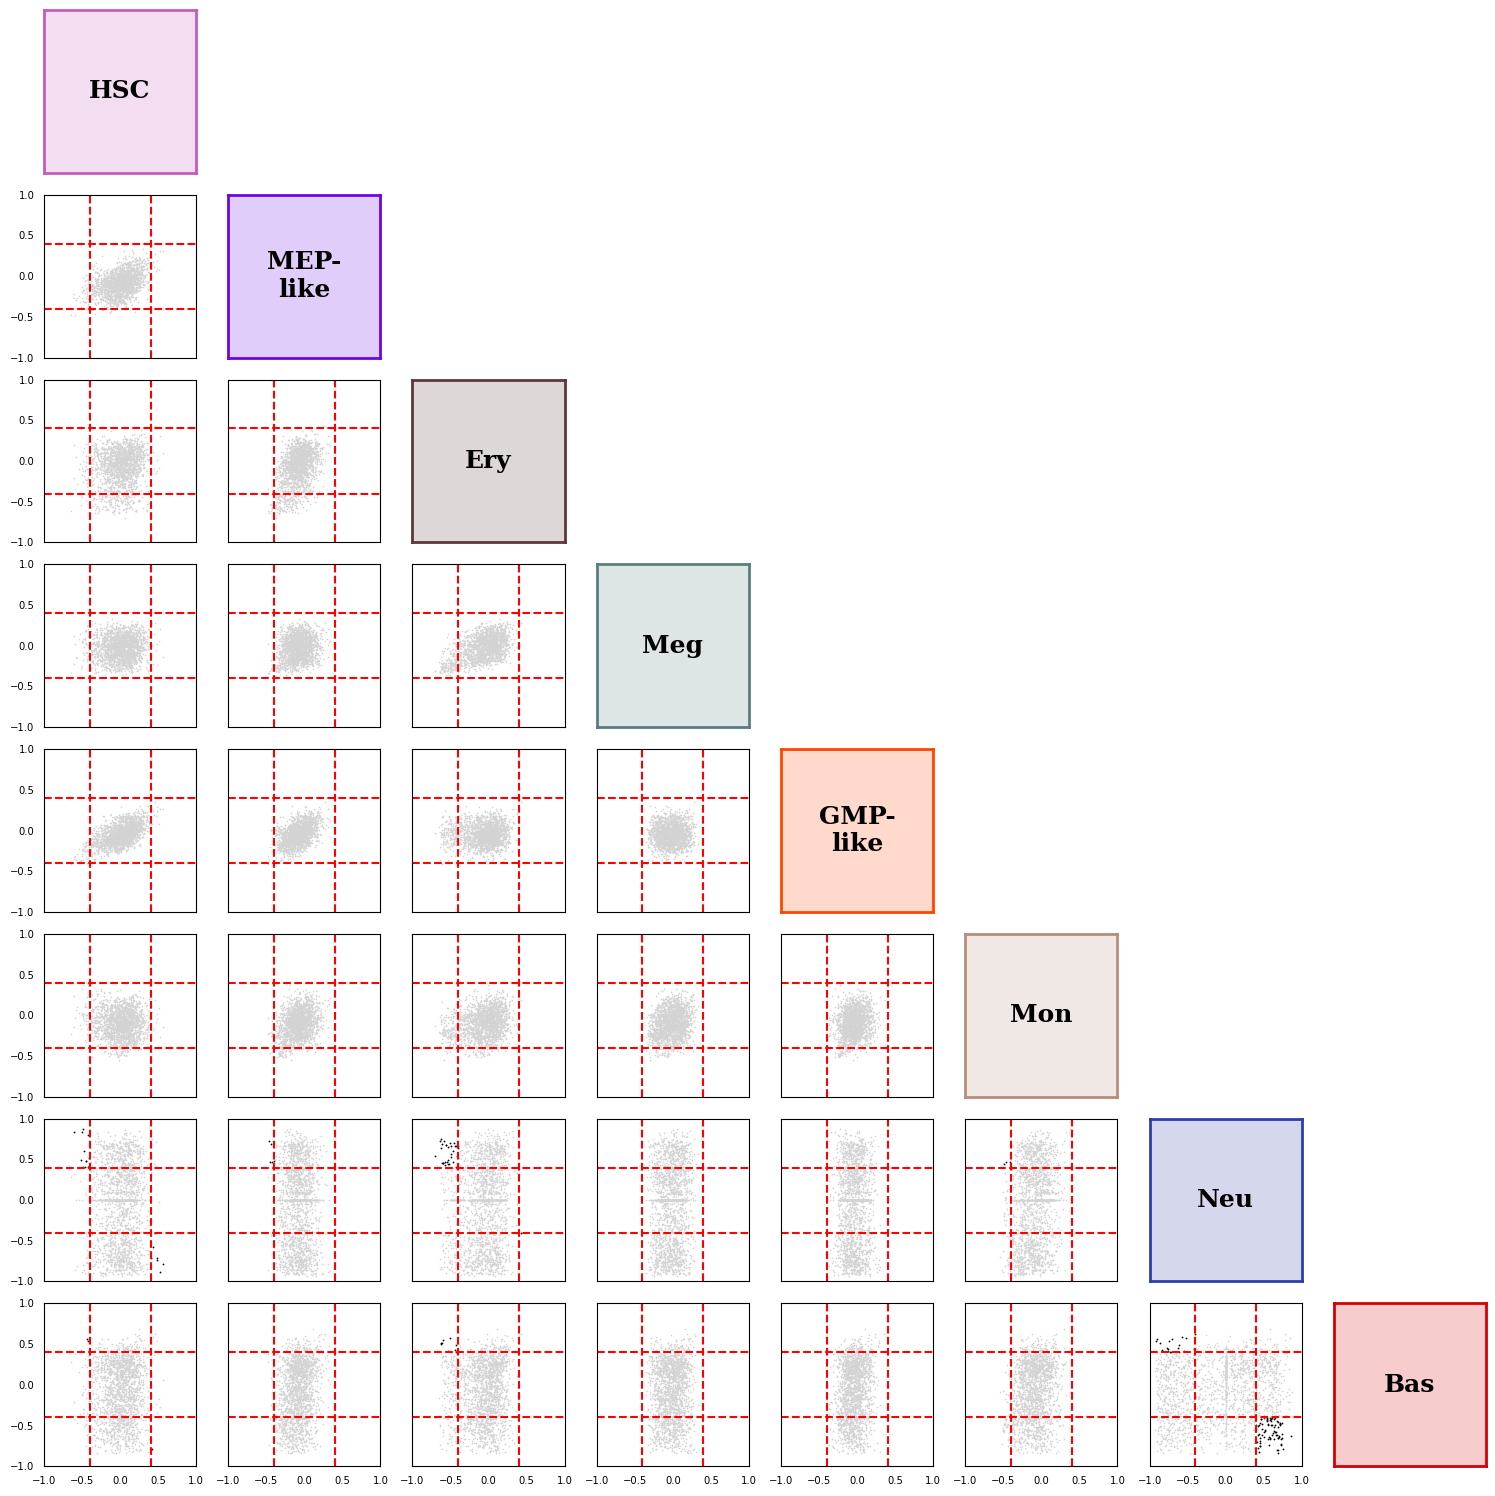

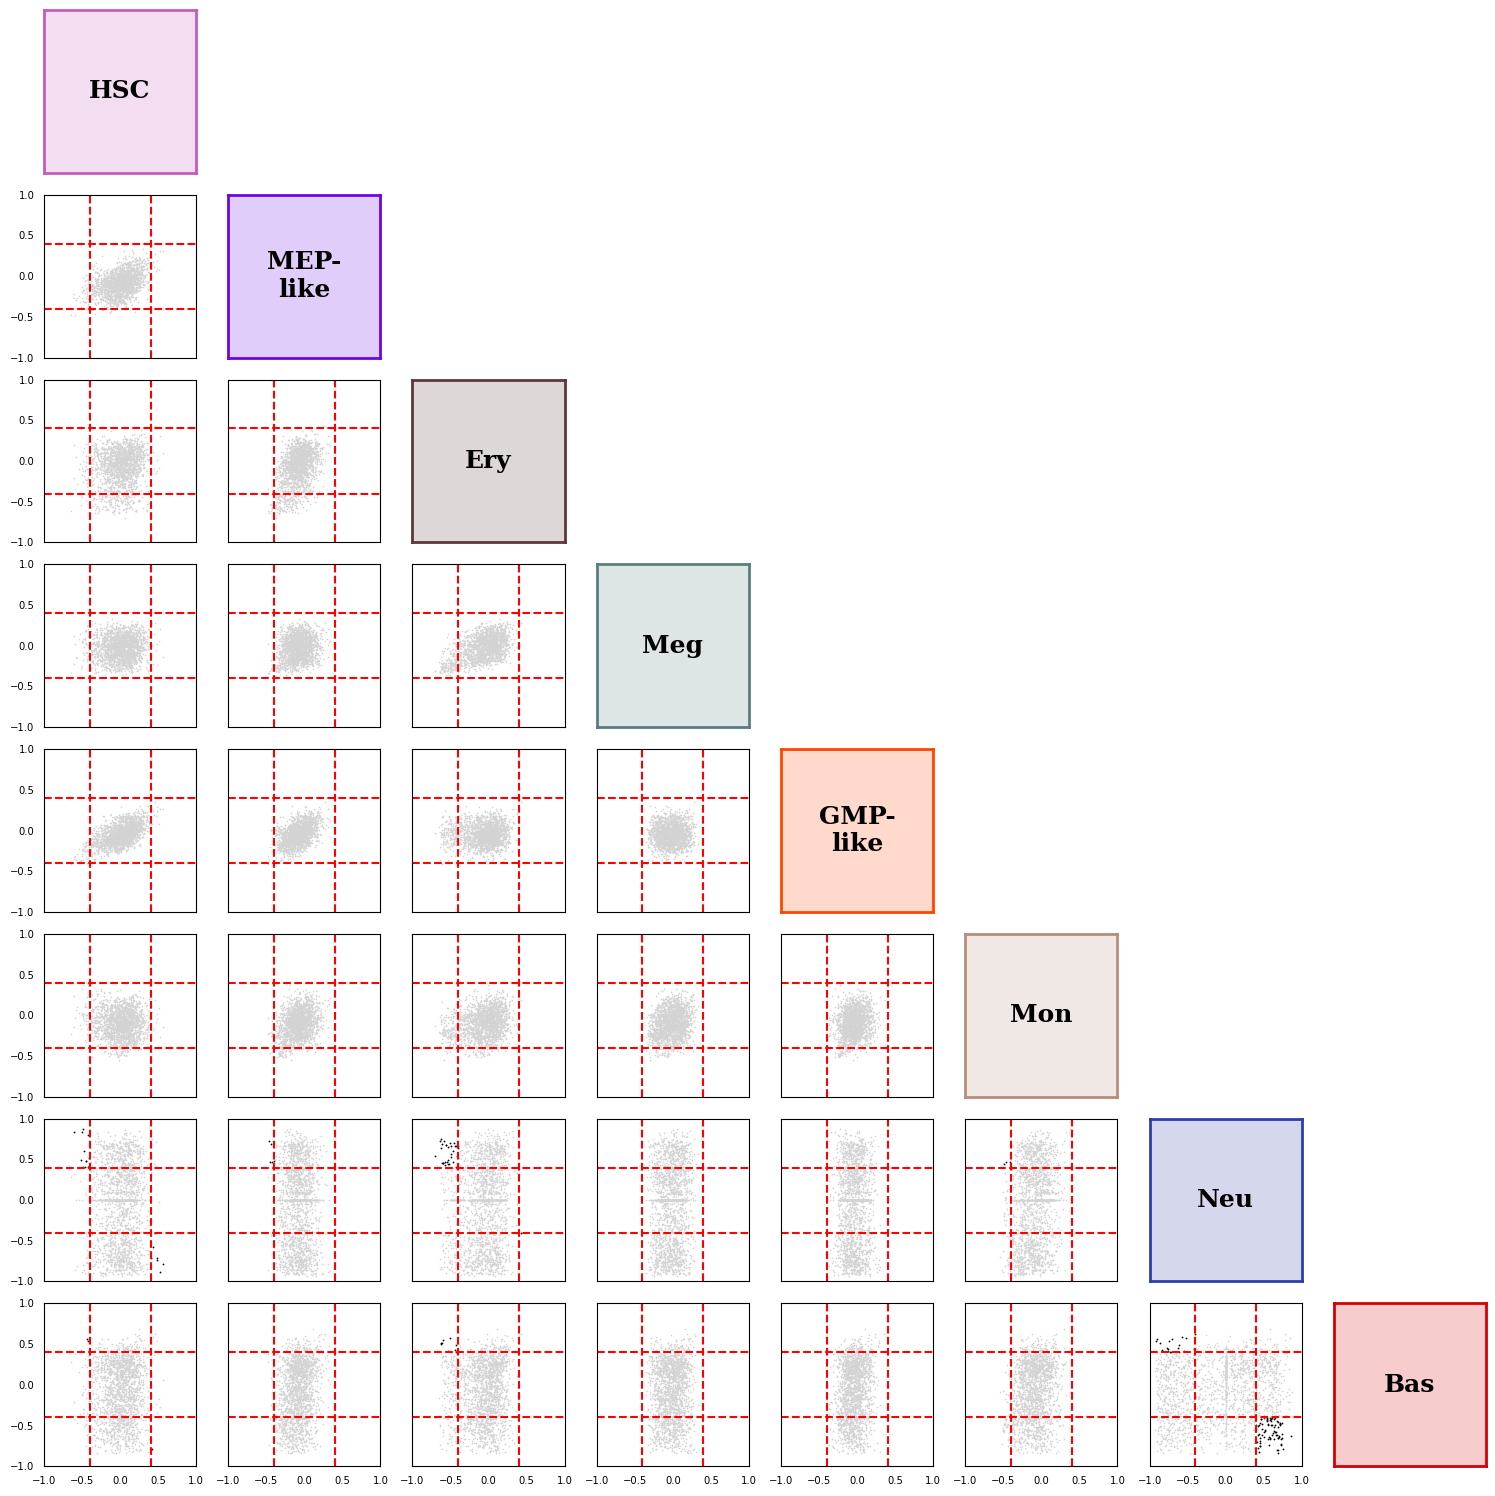

In [33]:
sch.pl.plot_correlations_grid(
      adata,
      cluster_key=CLUSTER_KEY,
      energy='interaction',
      order=CELL_TYPE_ORDER,
      colors=colors,
      x_low=-0.4,
      x_high=0.4,
      y_low=-0.4,
      y_high=0.4
  )

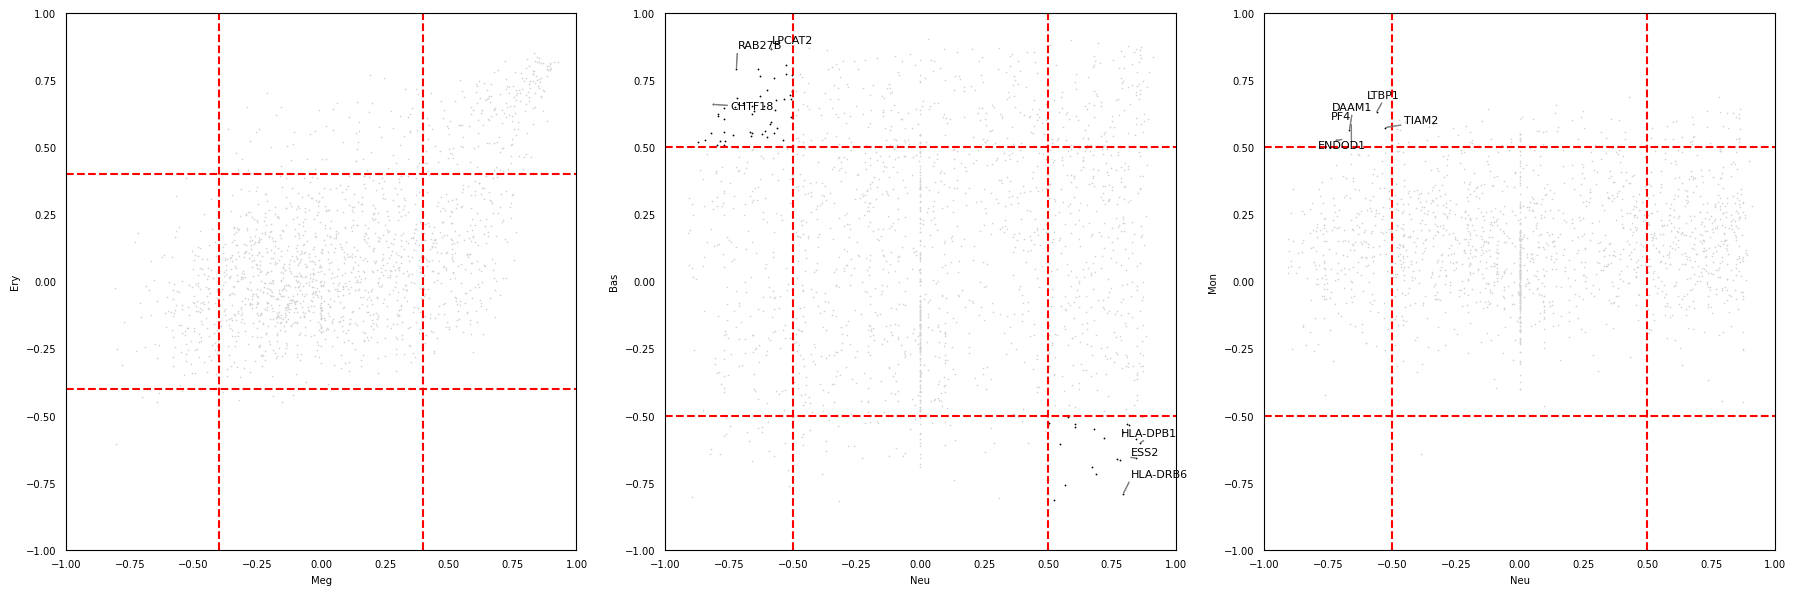

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)

sch.pl.plot_gene_correlation_scatter(adata, 'Meg', 'Ery', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[0], clus1_low=-0.4, clus1_high=0.4,
clus2_low=-0.4, clus2_high=0.4)
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Bas', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[1])
sch.pl.plot_gene_correlation_scatter(adata, 'Neu', 'Mon', cluster_key=CLUSTER_KEY, energy='total', annotate=6, ax=ax[2])

plt.show()


# Network scores

In [35]:
sch.tl.compute_network_centrality(
      adata,
      cluster_key='cell_type',
      threshold_number=20000  # Top 2000 edges per cluster
  )

In [36]:
adata

AnnData object with n_obs × n_vars = 1947 × 1728
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori', 'energy_total', 'energy_interaction', 'energy_degradation', 'ene

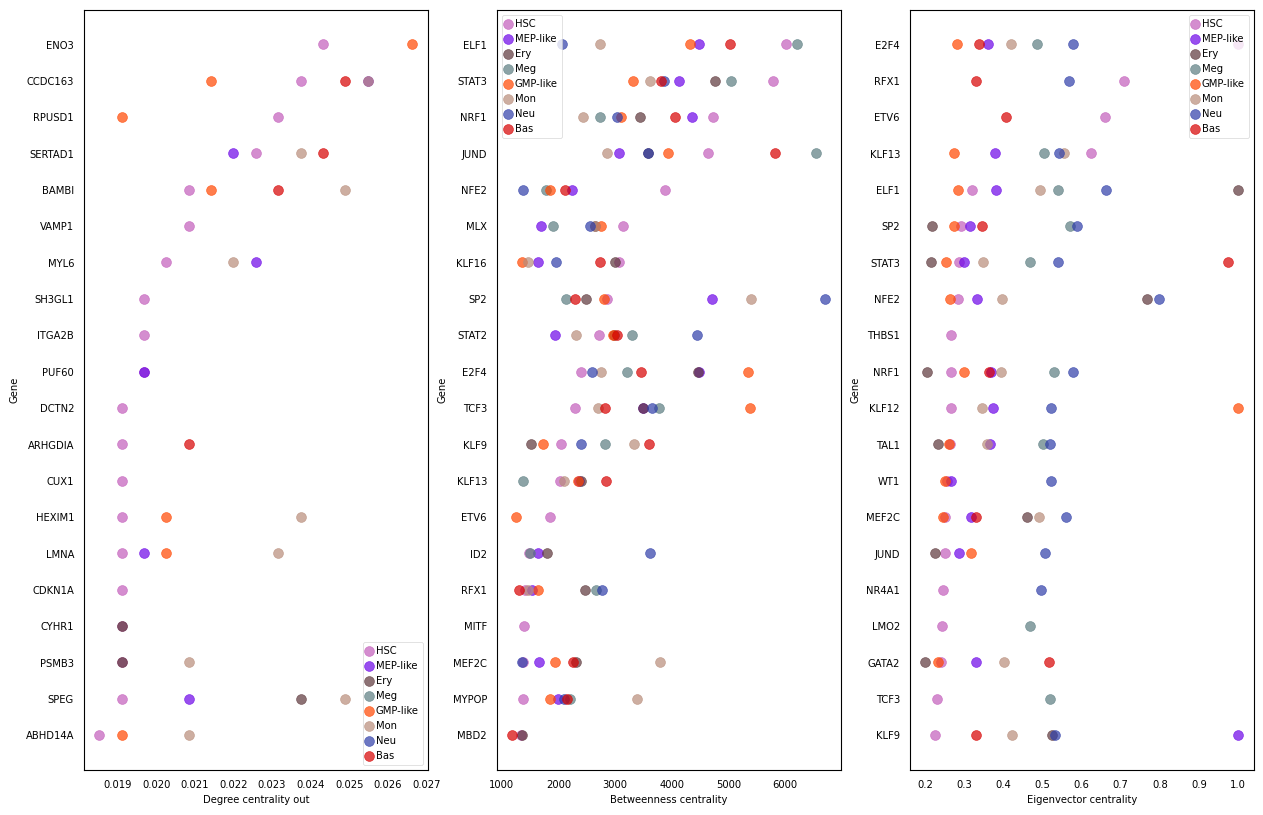

In [37]:
# ============================================================
# 2. Plot ranked genes by different centrality metrics
# ============================================================
# Create figure with multiple centrality rankings
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

metrics = ['degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
for ax, metric in zip(axes, metrics):
    sch.pl.plot_network_centrality_rank(
        adata,
        metric=metric,
        clusters=CELL_TYPE_ORDER,
        cluster_key=CLUSTER_KEY,
        n_genes=20,
        colors=colors,
        ax=ax
    )
plt.show()

In [38]:
# ============================================================
# 3. Get top genes tables for different metrics
# ============================================================
# Betweenness centrality table
df_betweenness = sch.tl.get_top_genes_table(
    adata,
    metric='betweenness_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_betweenness)

# Degree centrality table
df_degree = sch.tl.get_top_genes_table(
    adata,
    metric='degree_centrality_out',
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER,
)
display(df_degree)

# Eigenvector centrality table
df_eigenvector = sch.tl.get_top_genes_table(
    adata,
    metric='eigenvector_centrality',
    cluster_key=CLUSTER_KEY,
    n_genes=10,
    order=CELL_TYPE_ORDER,
)
display(df_eigenvector)

# Get just the gene names (every other column)
genes_only = df_degree[[((cl, 'Gene')) for cl in CELL_TYPE_ORDER]]
display(genes_only)

HSC                        MEP-like                            Ery  \
     Gene Betweenness Centrality     Gene Betweenness Centrality    Gene   
0    ELF1                 6020.0      SP2                 4705.0   STAT3   
1   STAT3                 5793.0     E2F4                 4482.0    E2F4   
2    NRF1                 4725.0     ELF1                 4480.0    JUND   
3    JUND                 4643.0     NRF1                 4351.0    TCF3   
4    NFE2                 3881.0    STAT3                 4133.0    NRF1   
5     MLX                 3143.0     TCF3                 3497.0   KLF16   
6   KLF16                 3068.0     JUND                 3070.0   STAT2   
7     SP2                 2860.0     EBF1                 2412.0     MLX   
8   STAT2                 2717.0    KLF13                 2357.0     SP2   
9    E2F4                 2400.0     NFE2                 2240.0    RFX1   
10   TCF3                 2288.0    MYPOP                 1997.0   KLF13   
11   KLF9                 2043.0    STAT2                 1936.0   MEF2C   
12  KLF13                 2033.0     LYL1                 1866.0     ID2   
13   ETV6                 1855.0   GTF3C2                 1710.0   ATF6B   
14    ID2                 1487.0      MLX                 1686.0    CUX1   
15   RFX1                 1414.0    MEF2C                 1655.0  GTF3C2   
16   MITF                 1390.0      ID2                 1646.0    KLF9   
17  MEF2C                 1378.0    KLF16                 1631.0    LYL1   
18  MYPOP                 1365.0     KLF1                 1579.0    MBD2   
19   MBD2                 1341.0     RFX1                 1527.0    RORA   

                              Meg                        GMP-like  \
   Betweenness Centrality    Gene Betweenness Centrality     Gene   
0                  4763.0    JUND                 6545.0     TCF3   
1                  4472.0    ELF1                 6219.0     E2F4   
2                  3586.0   STAT3                 5055.0     ELF1   
3                  3485.0    TCF3                 3778.0     JUND   
4                  3432.0   STAT2                 3294.0    STAT3   
5                  2992.0    E2F4                 3202.0     NRF1   
6                  2973.0    KLF9                 2819.0    STAT2   
7                  2640.0    NRF1                 2733.0      SP2   
8                  2486.0    RFX1                 2661.0      MLX   
9                  2472.0    FLI1                 2657.0    KLF13   
10                 2405.0   MYPOP                 2210.0     RORA   
11                 2302.0  HIVEP1                 2182.0    MEF2C   
12                 1802.0     SP2                 2135.0    MYPOP   
13                 1703.0     MLX                 1911.0     NFE2   
14                 1633.0    NFE2                 1785.0    GATA1   
15                 1606.0    LYL1                 1699.0     KLF9   
16                 1507.0    CUX1                 1528.0     RFX1   
17                 1502.0     ID2                 1499.0     LYL1   
18                 1357.0   KLF13                 1376.0    KLF16   
19                 1314.0    ETV4                 1356.0     ETV6   

                             Mon                           Neu  \
   Betweenness Centrality   Gene Betweenness Centrality   Gene   
0                  5384.0    SP2                 5395.0    SP2   
1                  5354.0  MEF2C                 3797.0  STAT2   
2                  4315.0  STAT3                 3621.0  STAT3   
3                  3938.0  MYPOP                 3383.0   TCF3   
4                  3316.0   KLF9                 3341.0    ID2   
5                  3107.0   JUND                 2860.0   JUND   
6                  2966.0   E2F4                 2753.0   NRF1   
7                  2801.0   ELF1                 2730.0   RFX1   
8                  2758.0   TCF3                 2704.0   E2F4   
9                  2347.0    MLX                 2648.0    MLX   
10                 232

HSC                        MEP-like                             Ery  \
       Gene Degree Centrality Out      Gene Degree Centrality Out      Gene   
0      ENO3              0.024320   CCDC163              0.025478       HLF   
1   CCDC163              0.023741      MYL6              0.022583      FIBP   
2    RPUSD1              0.023162   SERTAD1              0.022003      SPEG   
3   SERTAD1              0.022583      DTX4              0.021424      ABI3   
4     BAMBI              0.020845   TRAPPC1              0.020845     SYNPO   
5     VAMP1              0.020845    SLC1A4              0.020845    POU6F1   
6      MYL6              0.020266      SPEG              0.020845     HYOU1   
7    SH3GL1              0.019687      ABI3              0.020266      OAZ1   
8    ITGA2B              0.019687     FGFR1              0.020266   ABHD14B   
9     PUF60              0.019687       LPP              0.019687  SLC25A39   
10    DCTN2              0.019108     PUF60              0.019687      DTX4   
11  ARHGDIA              0.019108     SYNPO              0.019687     ABCA2   
12     CUX1              0.019108  SLC25A39              0.019687     HDAC7   
13   HEXIM1              0.019108     TESK2              0.019687      PKIB   
14     LMNA              0.019108     UBAC1              0.019687     TESK2   
15   CDKN1A              0.019108      LMNA              0.019687     DACT3   
16    CYHR1              0.019108    RPL18A              0.019687     PSMB3   
17    PSMB3              0.019108      OAZ1              0.019687      NCLN   
18     SPEG              0.019108    MRPL14              0.019108    SEMA4D   
19  ABHD14A              0.018529     EIF3K              0.019108     CYHR1   

                               Meg                       GMP-like  \
   Degree Centrality Out      Gene Degree Centrality Out     Gene   
0               0.024899     UBTD1              0.032426     ENO3   
1               0.024320   TMEM205              0.029531     DMWD   
2               0.023741     FBXW9              0.027794   CACNB1   
3               0.023162    CACNB4              0.026057    BAMBI   
4               0.023162    MAD1L1              0.024899  CCDC163   
5               0.022003     RGS14              0.024899    HYOU1   
6               0.021424  RNASEH2A              0.024320   TRIP10   
7               0.021424    PRSS57              0.024320     TCF3   
8               0.020845    METTL1              0.024320   HEXIM1   
9               0.020845     IL2RG              0.023741     LMNA   
10              0.020266    SEMA4A              0.023741     RORA   
11              0.020266     KIF5C              0.023162    MTSS1   
12              0.020266       HLF              0.023162     BAG6   
13              0.020266    SLC1A4              0.022583      LPP   
14              0.019687   ANKRD16              0.022003  ABHD14A   
15              0.019108      BIN1              0.022003   SEMA4D   
16              0.019108      LDB1              0.021424  PLEKHG3   
17              0.019108     RUSC2              0.021424   RPUSD1   
18              0.019108    RNF122              0.021424     OAZ1   
19              0.019108     USP19              0.021424     SOD2   

                               Mon                             Neu  \
   Degree Centrality Out      Gene Degree Centrality Out      Gene   
0               0.026636   CCDC163              0.025478    FAM89B   
1               0.022583     BAMBI              0.024899    SEC16A   
2               0.022003      SPEG              0.024899   SMARCD2   
3               0.021424   SERTAD1              0.023741      FIBP   
4               0.021424    HEXIM1              0.023741      OAZ1   
5               0.020266      LMNA              0.023162     RUSC2   
6               0.020266      GPX1              0.022003     HYOU1   
7               0.020266     PTPRD              0.022003    RAB11B   
8               0.020266     ZFPM1              0.

HSC                        MEP-like                           Ery  \
    Gene Eigenvector Centrality     Gene Eigenvector Centrality   Gene   
0   E2F4               1.000000     KLF9               1.000000   ELF1   
1   RFX1               0.707026     ELF1               0.379962   NFE2   
2   ETV6               0.660345    KLF13               0.378715  MYPOP   
3  KLF13               0.624249    KLF12               0.372473   KLF9   
4   ELF1               0.321084     NRF1               0.367995  MEF2C   
5    SP2               0.290452     TAL1               0.366337  SYNPO   
6  STAT3               0.286495     E2F4               0.361227   SPEG   
7   NFE2               0.282952     NFE2               0.333859  FOSL2   
8  THBS1               0.266224    GATA2               0.329721   TAL1   
9   NRF1               0.265619     FLI1               0.320371   RDM1   

                               Meg                        GMP-like  \
  Eigenvector Centrality      Gene Eigenvector Centrality     Gene   
0               1.000000     TFCP2               1.000000    KLF12   
1               0.766235      MYCN               0.828819    STAT2   
2               0.645798      IER3               0.811574   SAMD14   
3               0.525210     FBXW9               0.669207     JUND   
4               0.460123  RNASEH2A               0.639966     NRF1   
5               0.306767       SP2               0.569096     ELF1   
6               0.247654      ELF1               0.538364     E2F4   
7               0.236924      NRF1               0.528994    KLF13   
8               0.232369      TCF3               0.519312      SP2   
9               0.229050   TMEM205               0.518274     FLI1   

                             Mon                           Neu  \
  Eigenvector Centrality    Gene Eigenvector Centrality   Gene   
0               1.000000   BAMBI               1.000000   LYL1   
1               0.575244  SAMD14               0.600250   NFE2   
2               0.427432   KLF13               0.555331   ELF1   
3               0.317161  ZNF263               0.495066    SP2   
4               0.298799    ELF1               0.494226   E2F4   
5               0.283426   MEF2C               0.491341   NRF1   
6               0.280736    KLF9               0.422990   EBF1   
7               0.275025    E2F4               0.420070   RFX1   
8               0.274036   GATA2               0.401750  MEF2C   
9               0.270441    NFE2               0.397065  KLF13   

                              Bas                         
  Eigenvector Centrality     Gene Eigenvector Centrality  
0               1.000000     AHRR               1.000000  
1               0.798893    STAT3               0.973660  
2               0.662890     KLF1               0.813045  
3               0.587955     GNAZ               0.575754  
4               0.578582    BAMBI               0.573410  
5               0.576902    GATA2               0.517723  
6               0.574220     SPI1               0.496623  
7               0.568698    ITGB2               0.482607  
8               0.559526     ETV6               0.406472  
9               0.542677  ST6GAL2               0.384573

HSC  MEP-like       Ery       Meg GMP-like       Mon       Neu  \
       Gene      Gene      Gene      Gene     Gene      Gene      Gene   
0      ENO3   CCDC163       HLF     UBTD1     ENO3   CCDC163    FAM89B   
1   CCDC163      MYL6      FIBP   TMEM205     DMWD     BAMBI    SEC16A   
2    RPUSD1   SERTAD1      SPEG     FBXW9   CACNB1      SPEG   SMARCD2   
3   SERTAD1      DTX4      ABI3    CACNB4    BAMBI   SERTAD1      FIBP   
4     BAMBI   TRAPPC1     SYNPO    MAD1L1  CCDC163    HEXIM1      OAZ1   
5     VAMP1    SLC1A4    POU6F1     RGS14    HYOU1      LMNA     RUSC2   
6      MYL6      SPEG     HYOU1  RNASEH2A   TRIP10      GPX1     HYOU1   
7    SH3GL1      ABI3      OAZ1    PRSS57     TCF3     PTPRD    RAB11B   
8    ITGA2B     FGFR1   ABHD14B    METTL1   HEXIM1     ZFPM1     WDR18   
9     PUF60       LPP  SLC25A39     IL2RG     LMNA      MYL6       CBL   
10    DCTN2     PUF60      DTX4    SEMA4A     RORA  SLC25A39  TMEM229B   
11  ARHGDIA     SYNPO     ABCA2     KIF5C    MTSS1     RPS19   MAP3K14   
12     CUX1  SLC25A39     HDAC7       HLF     BAG6      NCLN   SLC27A1   
13   HEXIM1     TESK2      PKIB    SLC1A4      LPP    CCDC71  SLC25A39   
14     LMNA     UBAC1     TESK2   ANKRD16  ABHD14A     TIAM1      NAT9   
15   CDKN1A      LMNA     DACT3      BIN1   SEMA4D     LIMS1   ABHD14B   
16    CYHR1    RPL18A     PSMB3      LDB1  PLEKHG3     PSMB3     RRAGC   
17    PSMB3      OAZ1      NCLN     RUSC2   RPUSD1   ABHD14A     DUSP7   
18     SPEG    MRPL14    SEMA4D    RNF122     OAZ1    SLC5A5   MAP3K12   
19  ABHD14A     EIF3K     CYHR1     USP19     SOD2     PSMD4    CACNB1   

         Bas  
        Gene  
0       DTX4  
1     SLC5A5  
2    CCDC163  
3    SERTAD1  
4      BAMBI  
5     METTL1  
6    ARHGDIA  
7    MAP3K12  
8   SLC22A23  
9    TRAPPC1  
10     RASA3  
11     TMCC2  
12      FIBP  
13      RERE  
14     TYRO3  
15      ABI3  
16       HLF  
17     ARVCF  
18      BIN1  
19    TALDO1

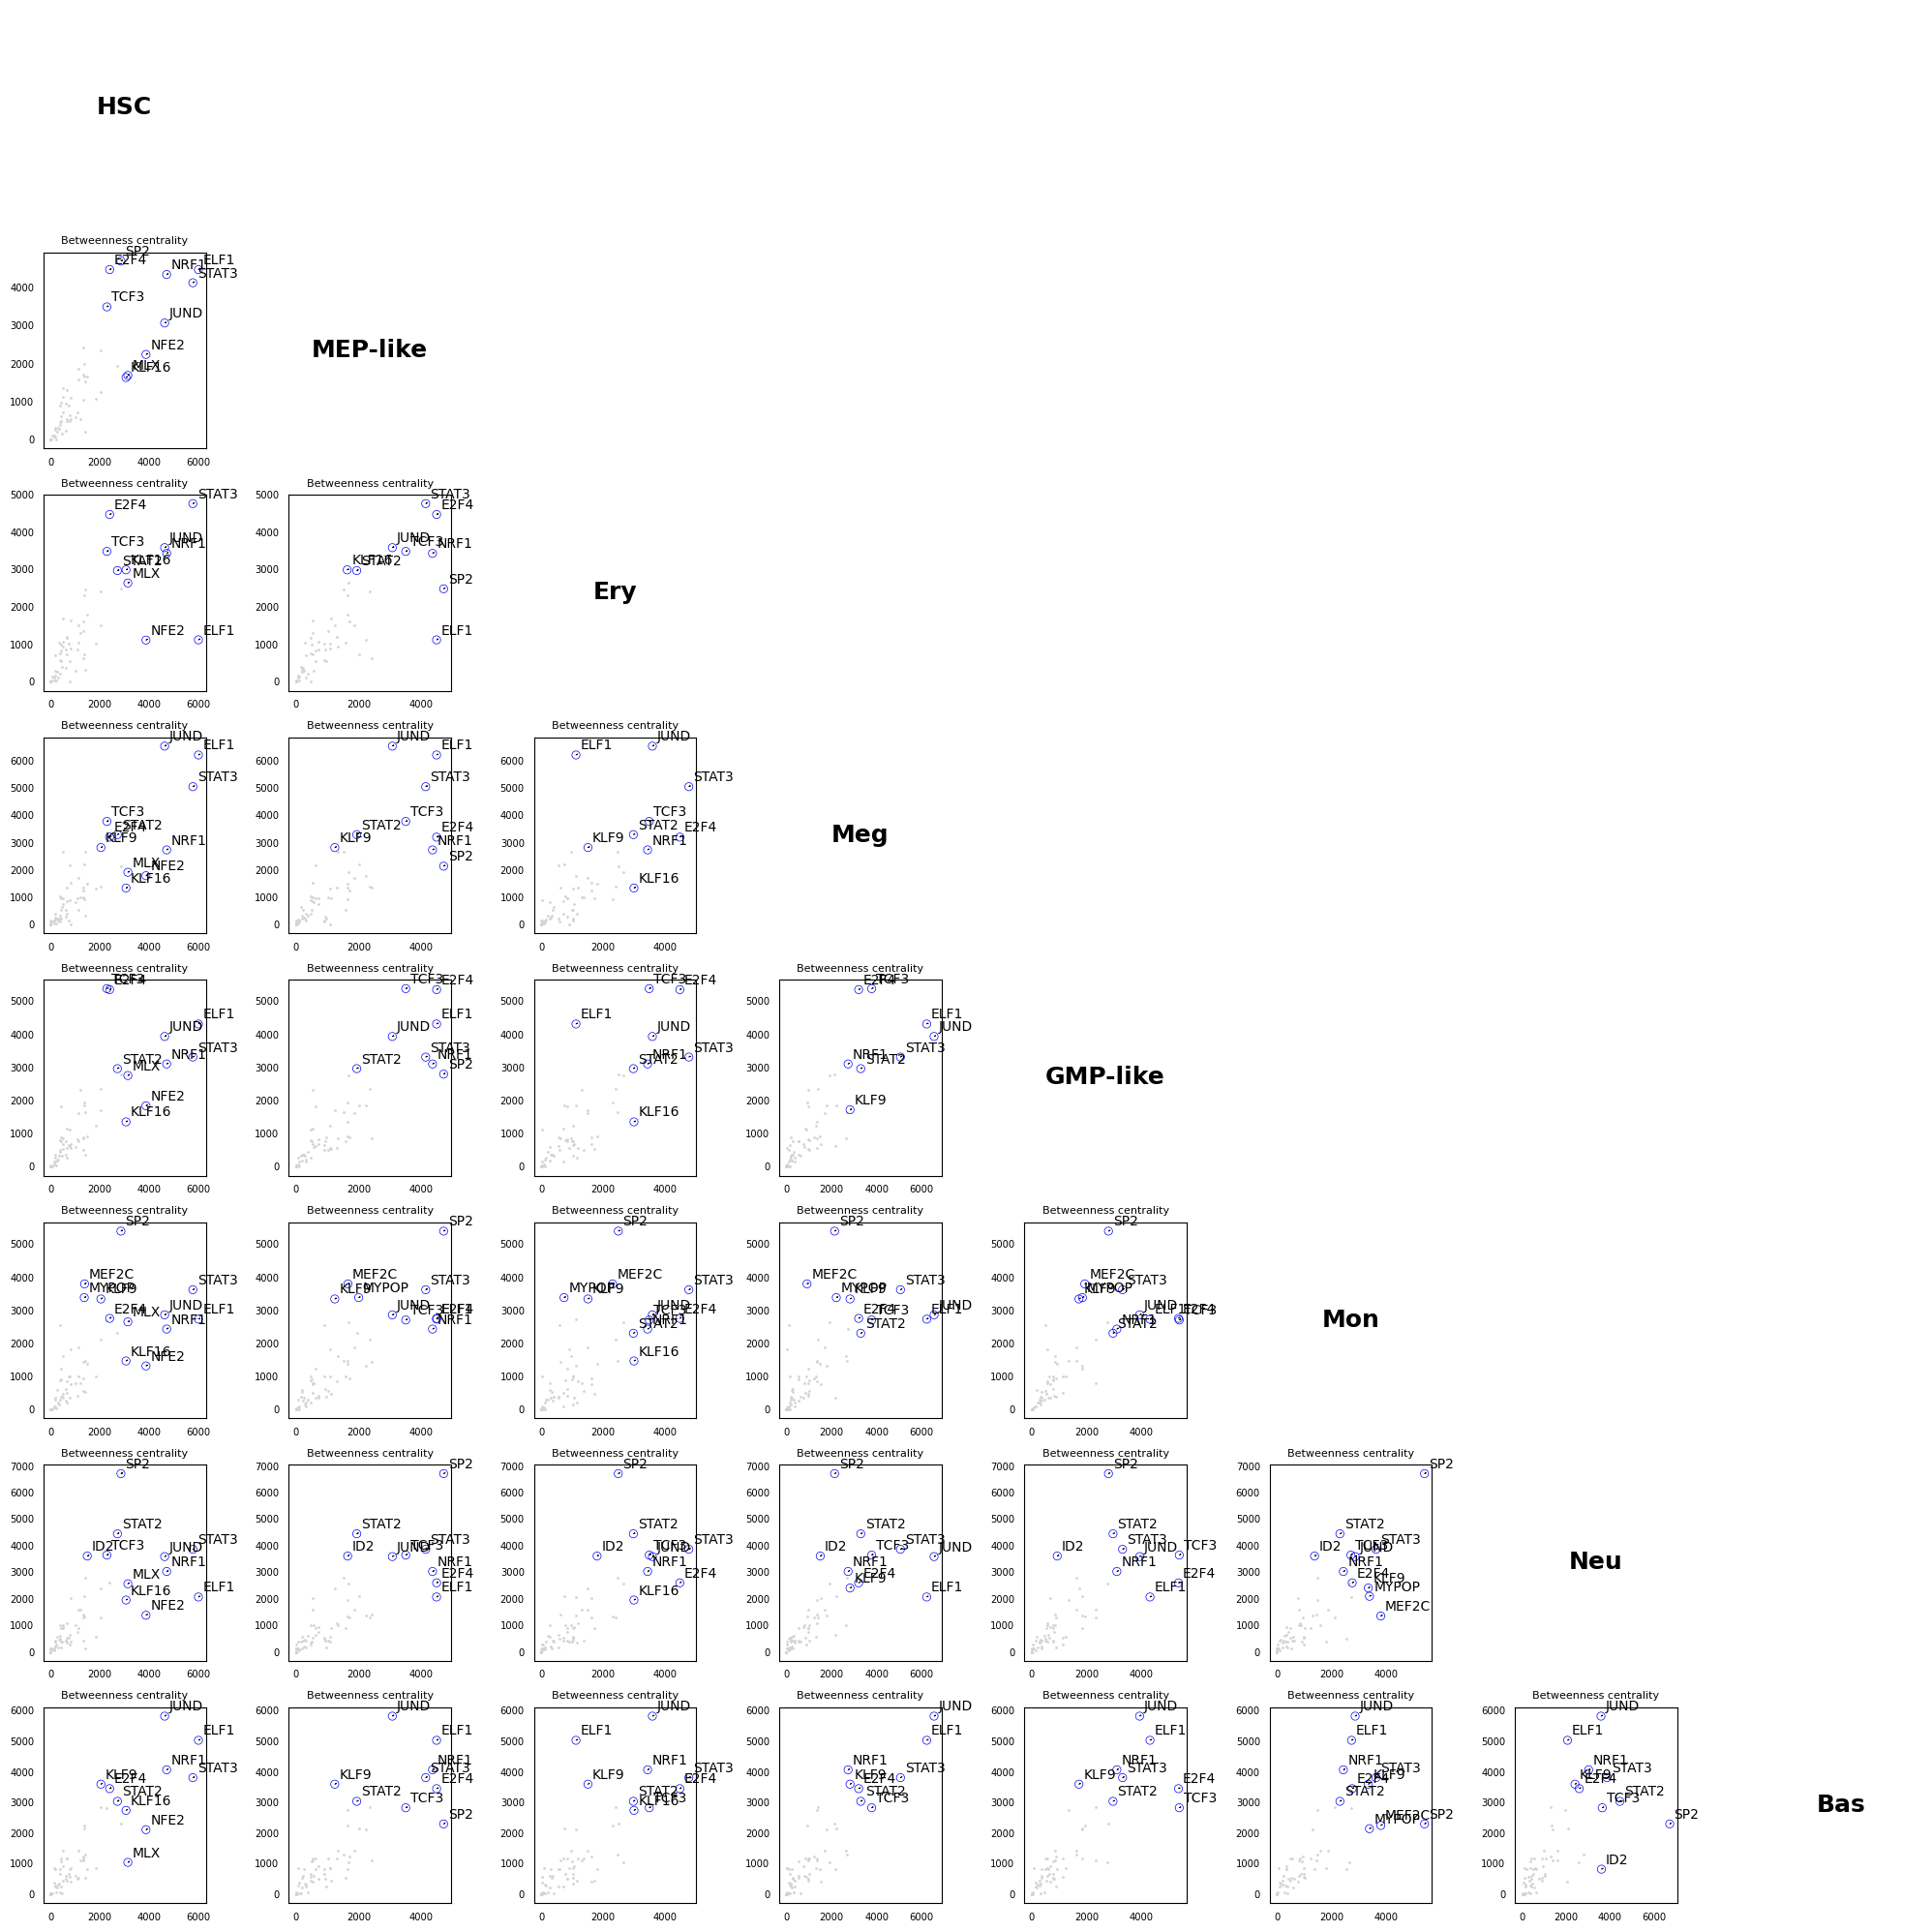

In [39]:
# ============================================================
# 4. Compare centrality between clusters (grid of comparisons)
# ============================================================
# This is similar to plot_score_comparison_grid but for one pair at a time
# You can create a grid manually or plot specific comparisons:
fig, axes = plt.subplots(len(CELL_TYPE_ORDER), len(CELL_TYPE_ORDER), figsize=(20, 20))

for i, clus1 in enumerate(CELL_TYPE_ORDER):
    for j, clus2 in enumerate(CELL_TYPE_ORDER):
        if i == j:
            # Diagonal: show cluster name
            axes[i, j].text(0.5, 0.5, clus1, ha='center', va='center',
                        fontsize=18, fontweight='bold',
                        transform=axes[i, j].transAxes)
            axes[i, j].axis('off')
        elif i < j:
            # Upper triangle: turn off
            axes[i, j].axis('off')
        else:
            # Lower triangle: plot comparison
            sch.pl.plot_centrality_comparison(
                adata,
                cluster1=CELL_TYPE_ORDER[j],
                cluster2=CELL_TYPE_ORDER[i],
                metric='betweenness_centrality',
                cluster_key=CLUSTER_KEY,
                percentile=99.6,
                annotate=True,
                ax=axes[i, j]
            )
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()

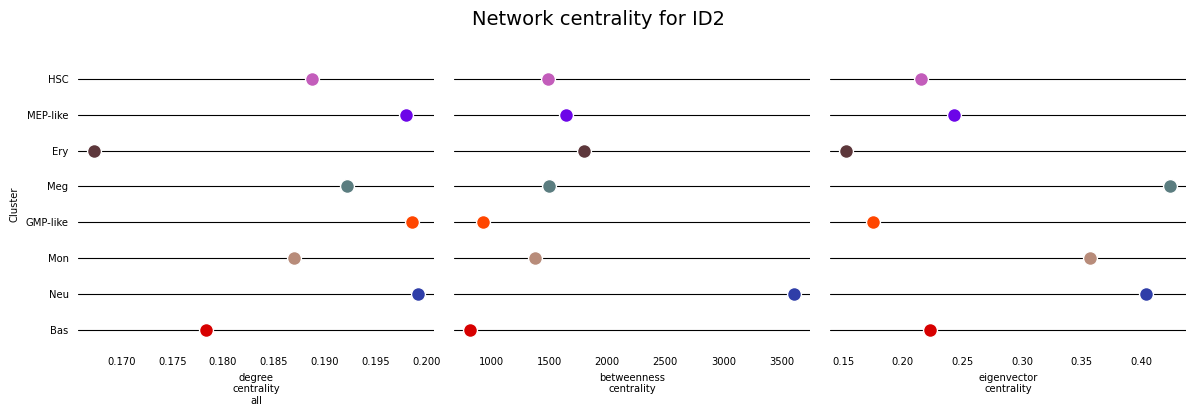

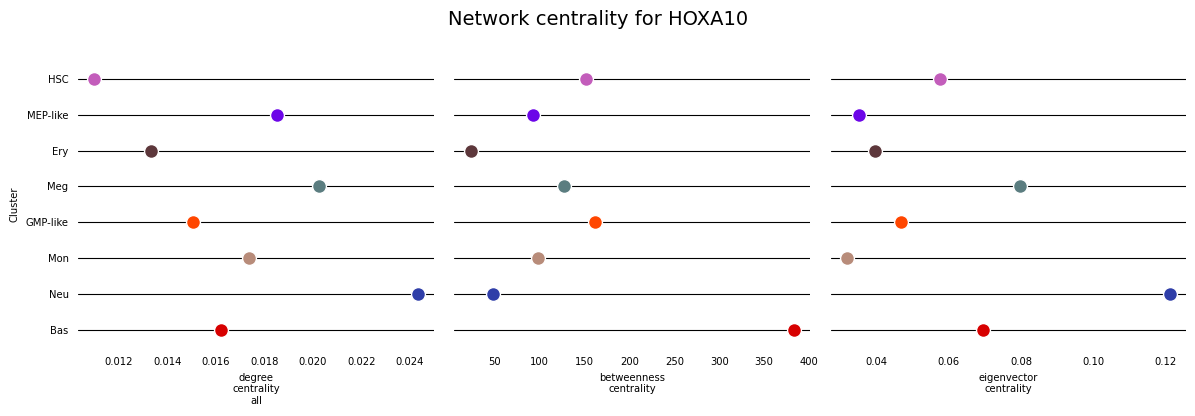

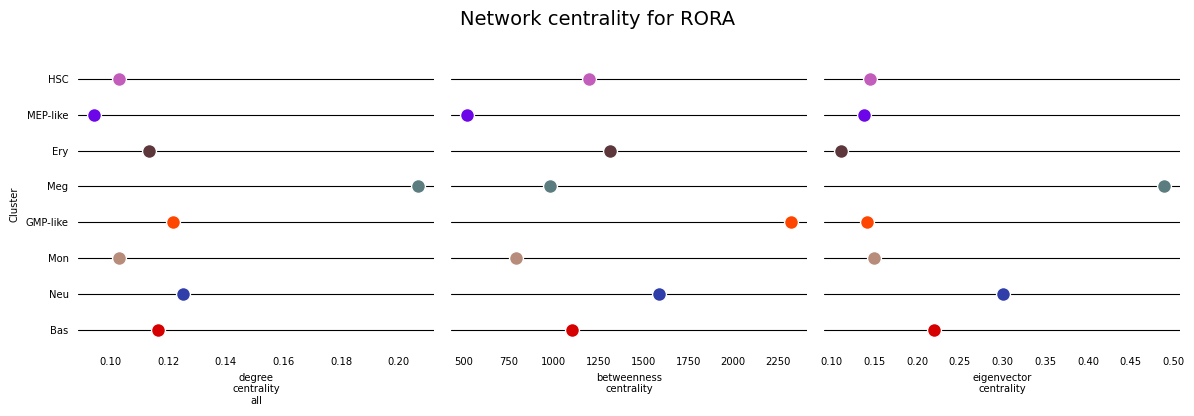

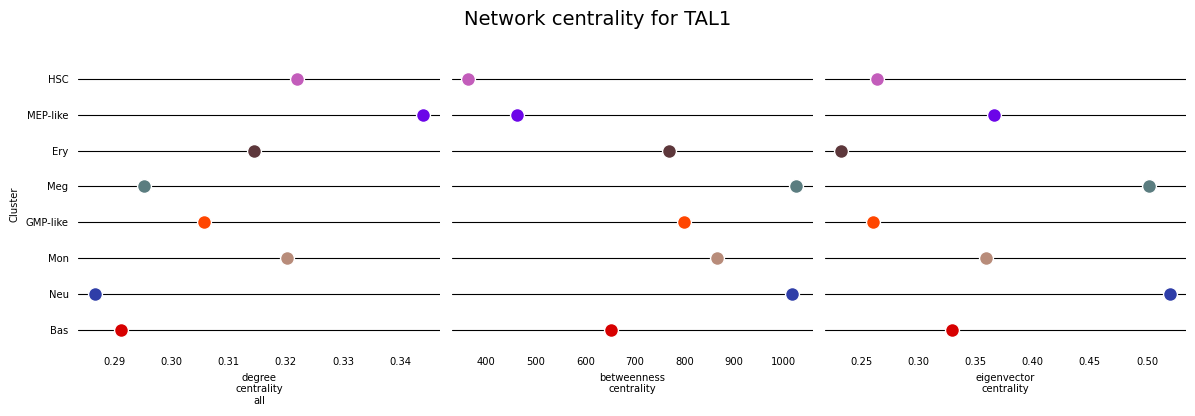

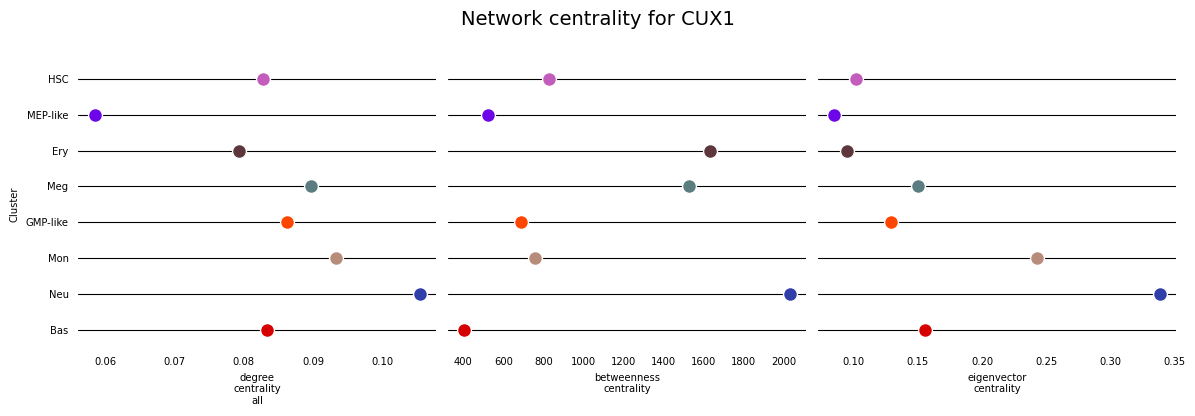

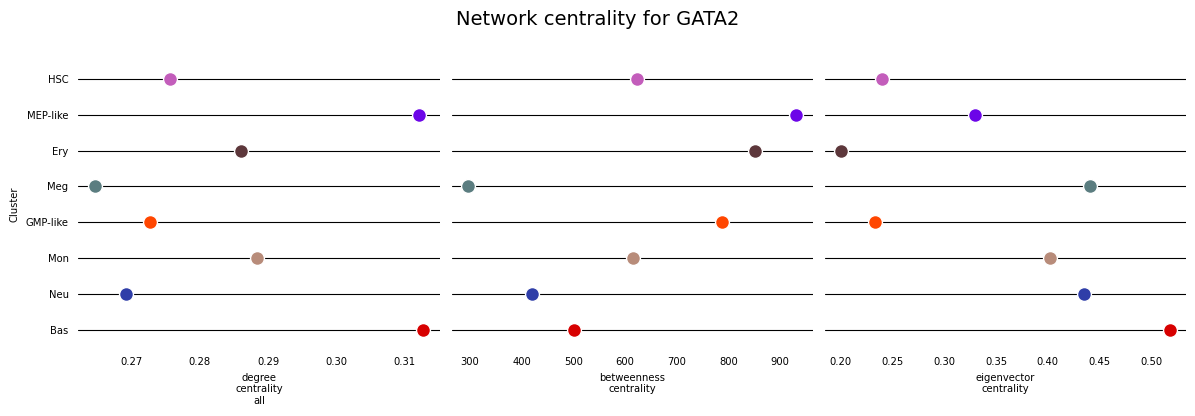

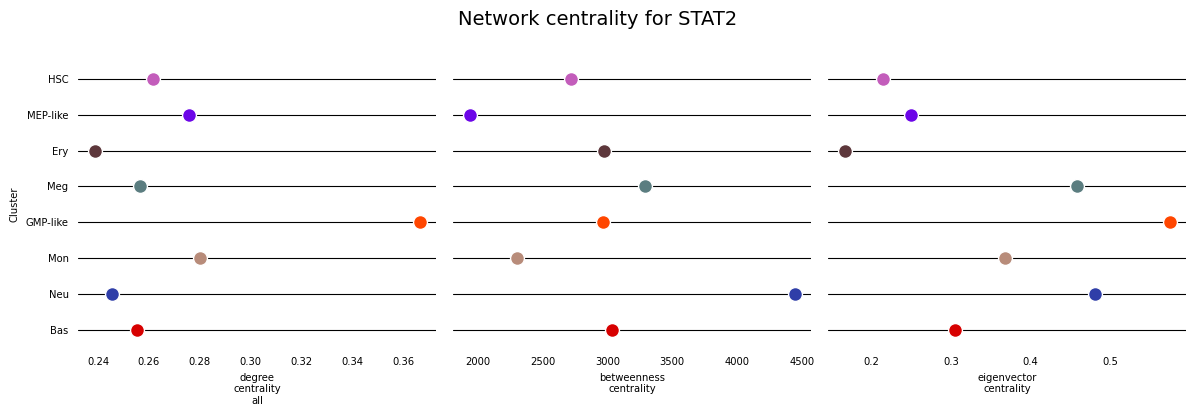

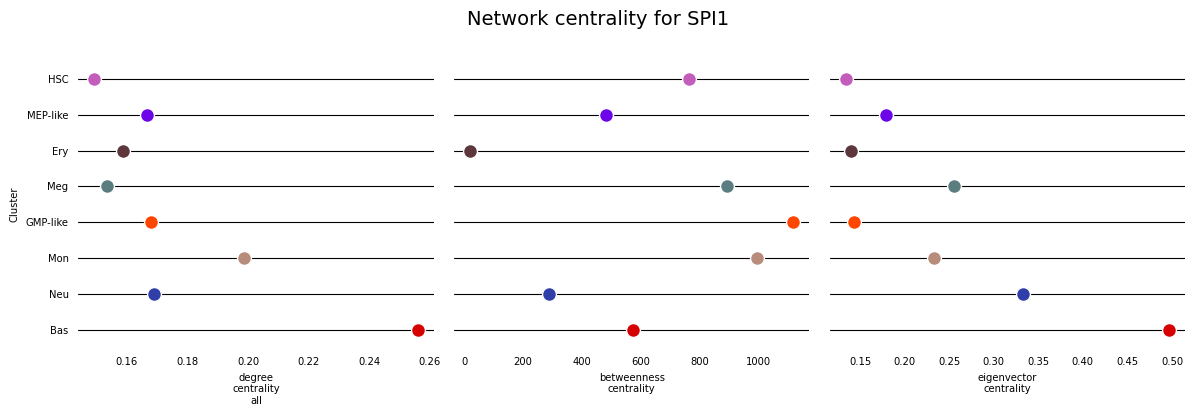

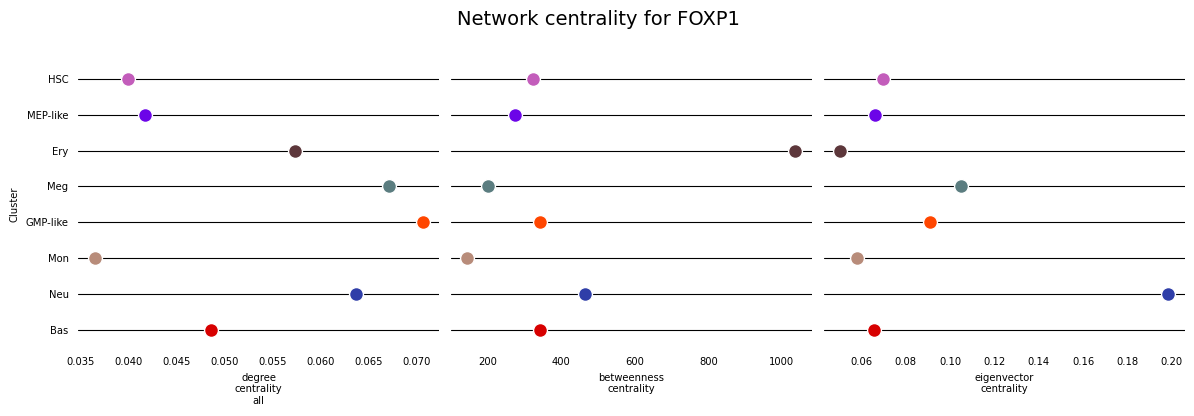

In [40]:
# ============================================================
# 5. Plot centrality for specific genes across clusters
# ============================================================
list_of_genes = ['ID2', 'HOXA10', 'RORA', 'TAL1', 'CUX1', 'GATA2',
                    'STAT2', 'SPI1', 'FOXP1']

for gene in list_of_genes:
    fig = sch.pl.plot_gene_centrality(
        adata,
        gene=gene,
        cluster_key=CLUSTER_KEY,
        order=CELL_TYPE_ORDER,
        colors=colors,
        figsize=(12, 4)
    )
    plt.show()

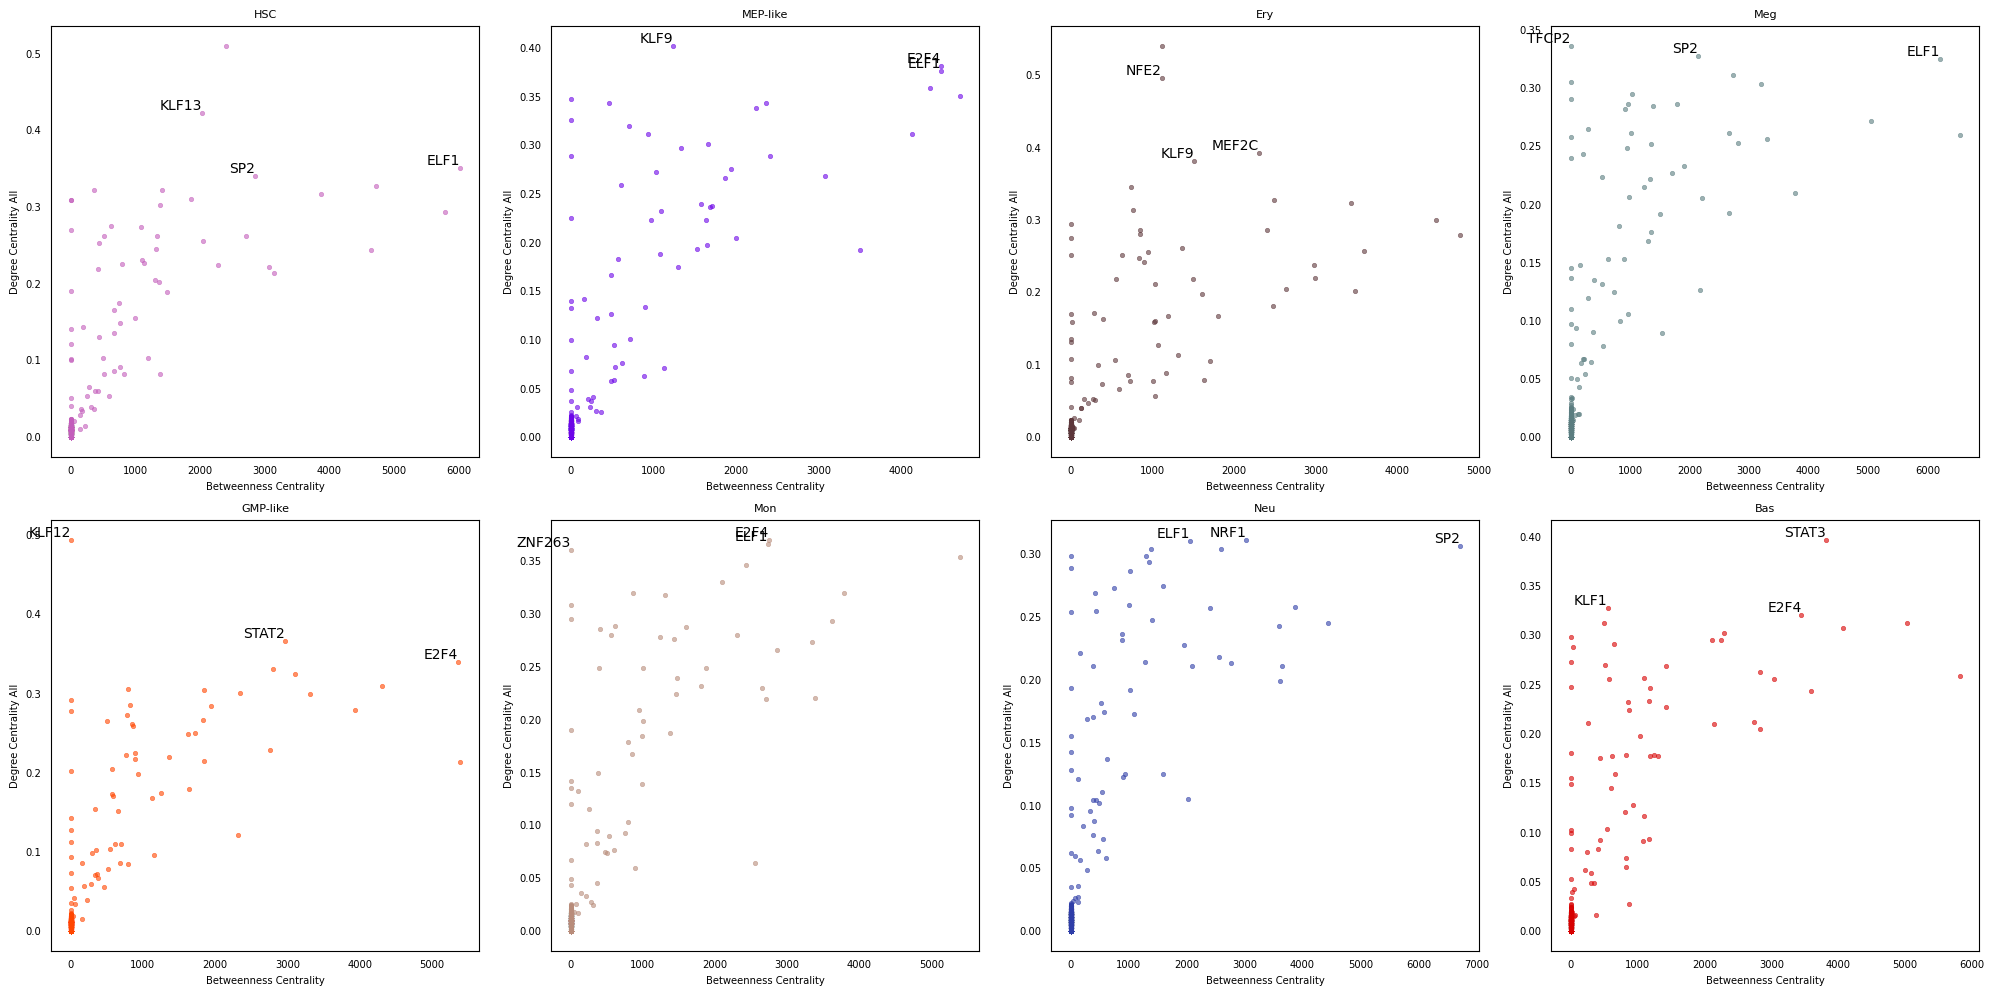

In [41]:
# ============================================================
# 6. Scatter plots: Betweenness vs Degree (high betweenness, low degree)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality_all',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('degree_centrality_all', '<', 0.5),  # Find high betweenness with low degree
    figsize=(20, 10)
)
plt.show()

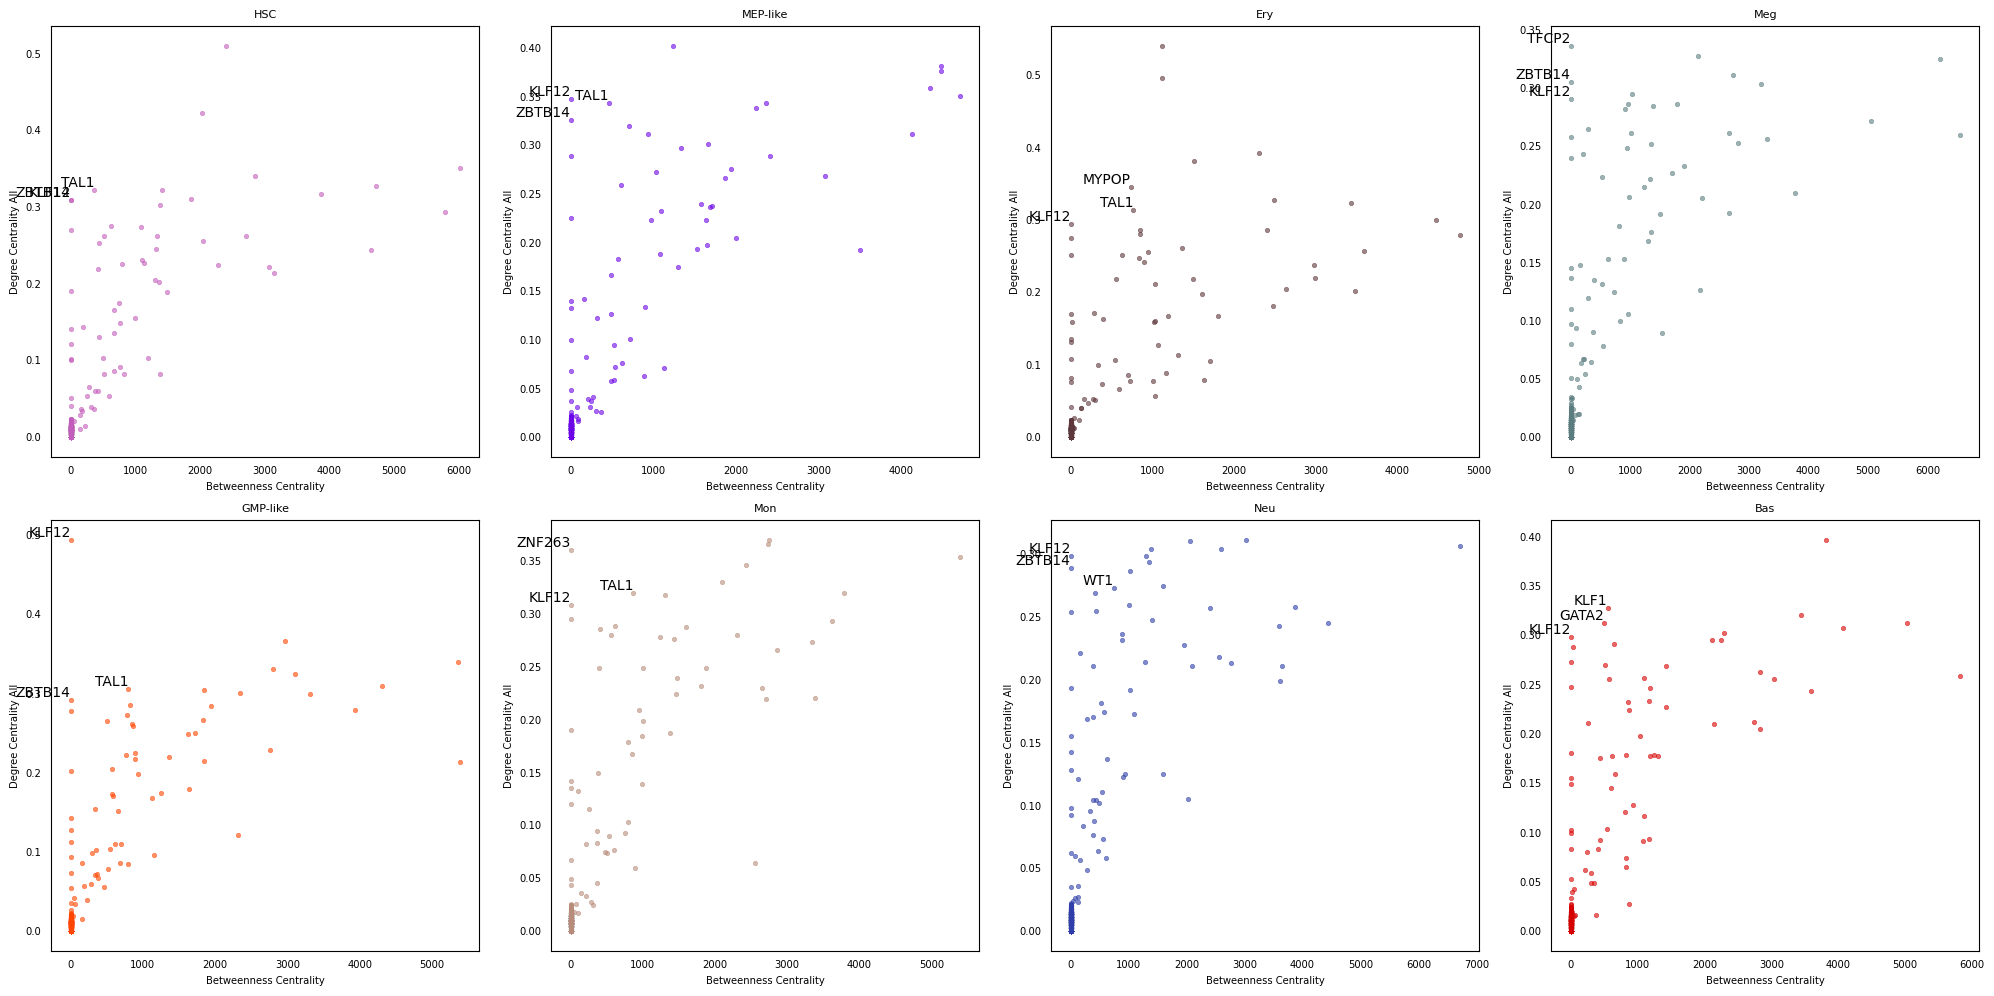

In [42]:
# ============================================================
# 7. Scatter plots: Betweenness vs Degree (high degree, low betweenness)
# ============================================================
fig = sch.pl.plot_centrality_scatter(
    adata,
    x_metric='betweenness_centrality',
    y_metric='degree_centrality_all',
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_top_genes=3,
    filter_threshold=('betweenness_centrality', '<', 1000),  # Find high degree with low betweenness
    figsize=(20, 10)
)
plt.show()

# Eigenvalues

## 1. Compute eigenanalysis for all clusters

In [43]:
# ============================================================
# 1. Compute eigenanalysis for all clusters
# ============================================================
sch.tl.compute_eigenanalysis(adata, cluster_key=CLUSTER_KEY)

# 2. Plot comprehensive eigenanalysis grid

This creates a grid showing:
- Column 1: Eigenvalue spectrum in complex plane
- Column 2: Eigenvector for max eigenvalue (unstable direction)
- Column 3: Eigenvector for min eigenvalue (stable direction)

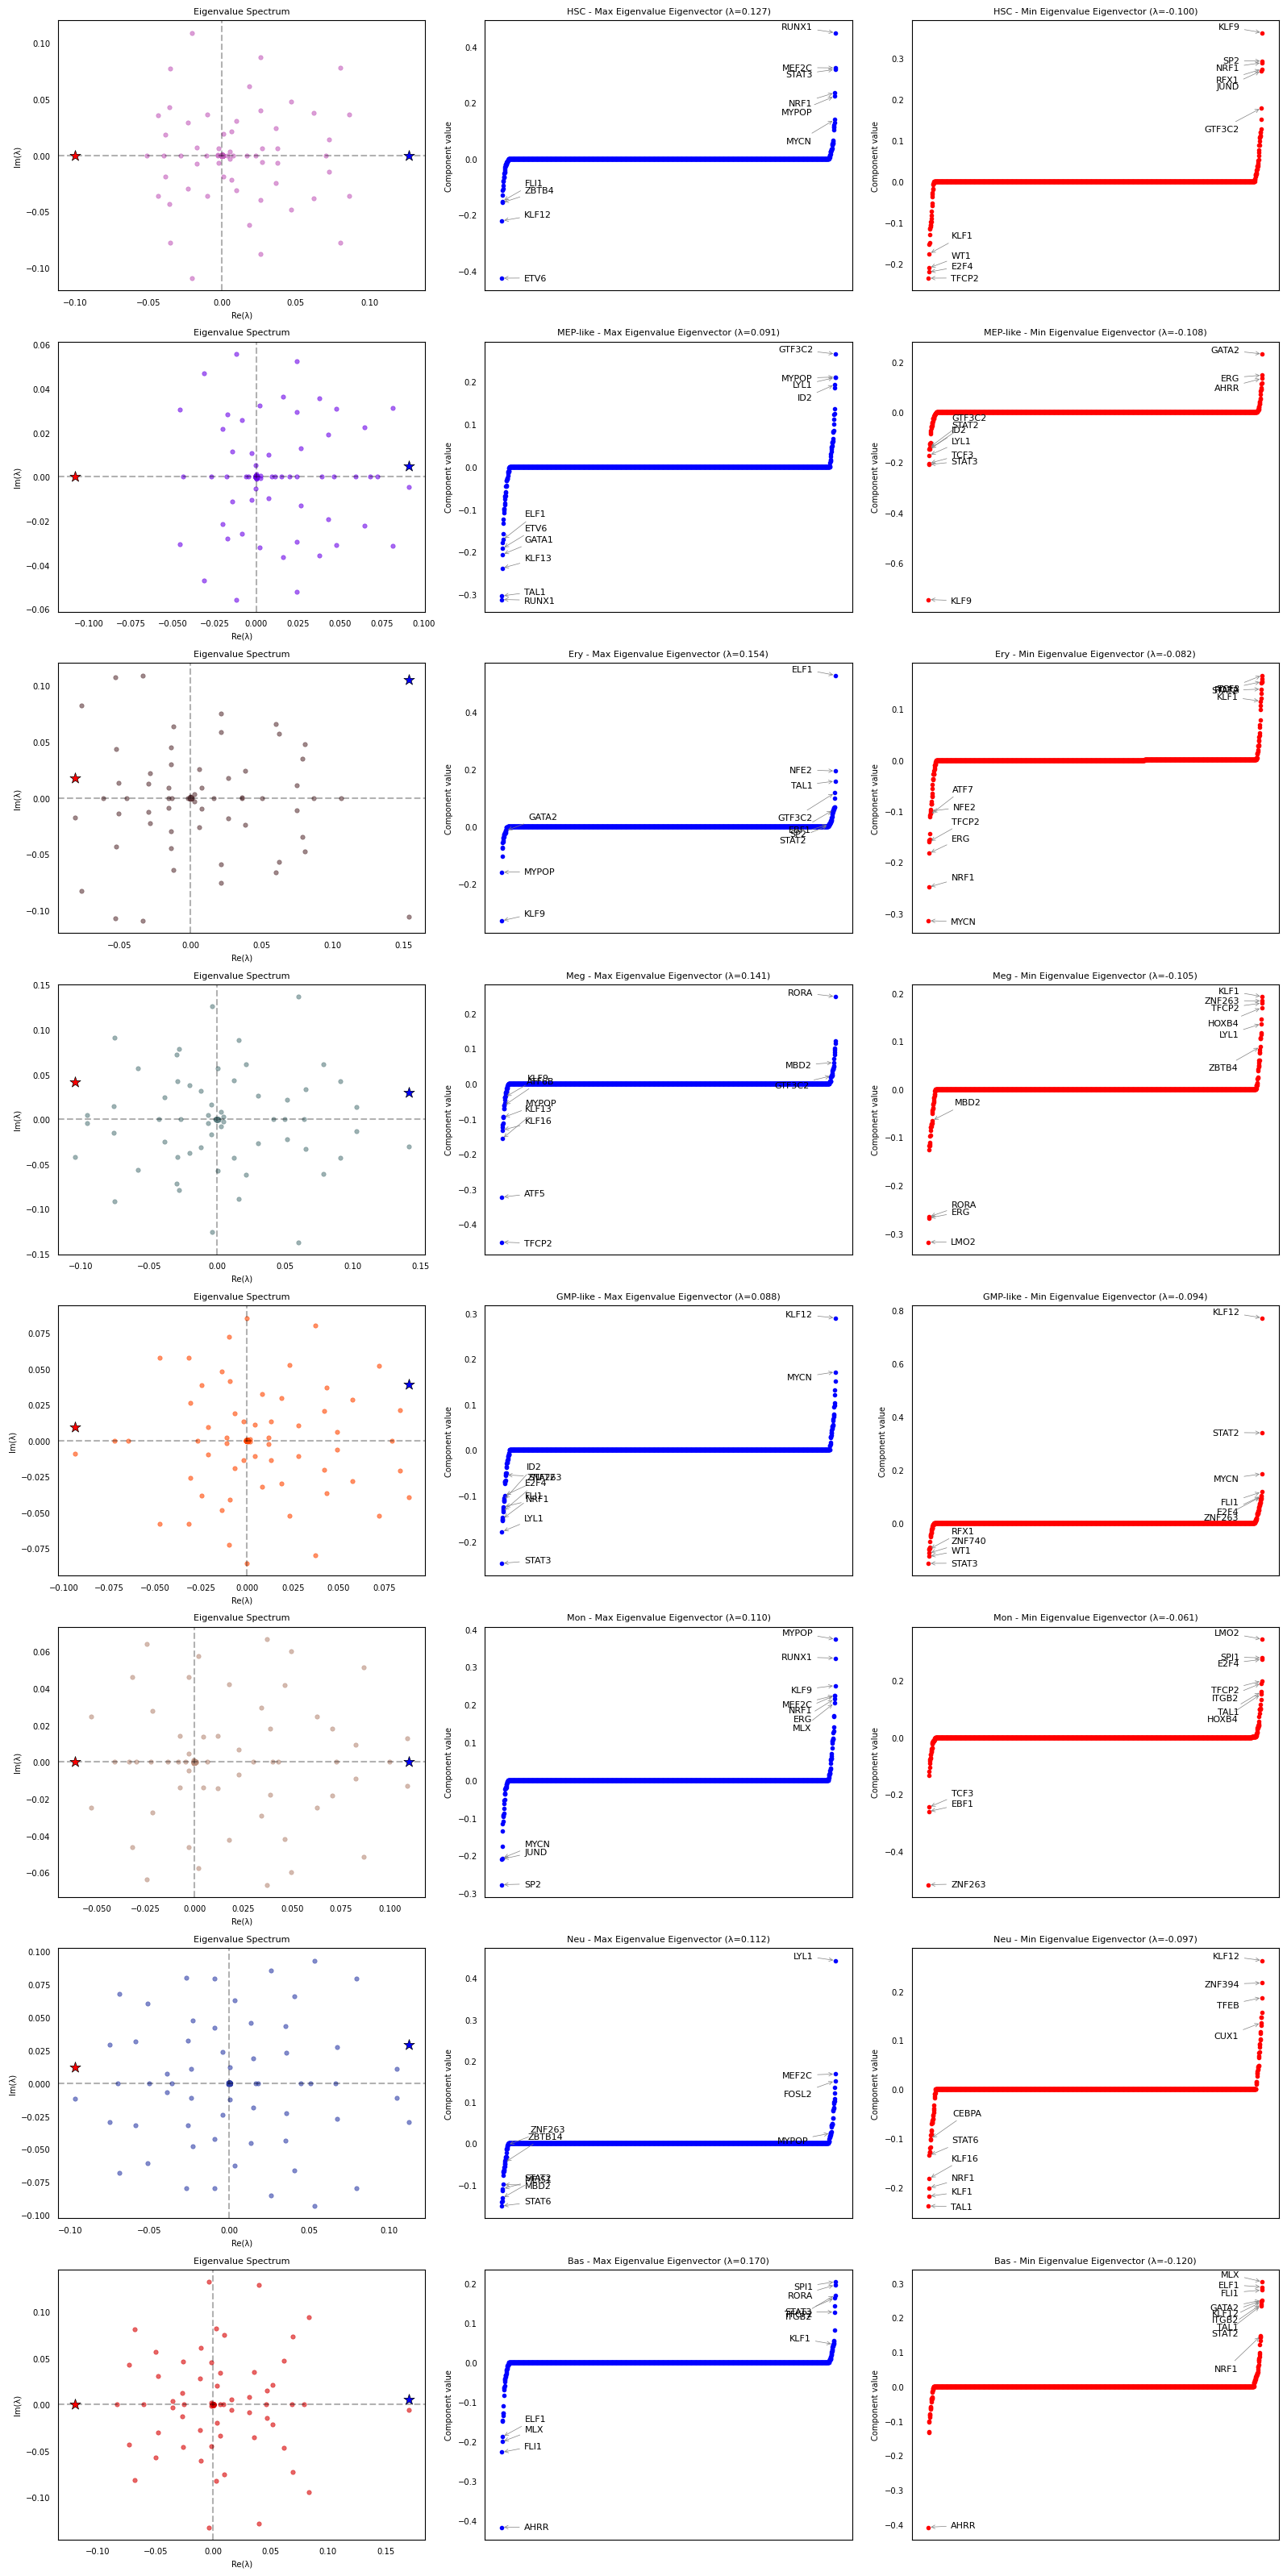

In [44]:
fig = sch.pl.plot_eigenanalysis_grid(
    adata,
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    n_genes=10,  # Number of top genes to annotate
    figsize=(16, 4 * len(CELL_TYPE_ORDER))
)
plt.show()

## 3. Get table of top genes from extreme eigenvectors

In [45]:
df_eigenanalysis = sch.tl.get_eigenanalysis_table(
    adata,
    cluster_key=CLUSTER_KEY,
    n_genes=20,
    order=CELL_TYPE_ORDER
)

# Display top 10 genes
print("Top genes from extreme eigenvectors:")
display(df_eigenanalysis.head(10))

Top genes from extreme eigenvectors:


HSC                              MEP-like                               \
  +EV gene +EV value -EV gene -EV value +EV gene +EV value -EV gene -EV value   
0    RUNX1     0.449     KLF9     0.361    RUNX1    -0.312     KLF9    -0.745   
1     ETV6    -0.426      SP2     0.292     TAL1    -0.304    GATA2     0.230   
2    MEF2C     0.324     NRF1     0.288   GTF3C2     0.265    STAT3    -0.209   
3    STAT3     0.318     RFX1     0.273    KLF13    -0.238     TCF3    -0.204   
4     NRF1     0.235     JUND     0.269    MYPOP     0.211     LYL1    -0.172   
5    MYPOP     0.223    TFCP2    -0.235     LYL1     0.209      ID2    -0.148   
6    KLF12    -0.221     E2F4    -0.220    GATA1    -0.206    STAT2    -0.148   
7    ZBTB4    -0.157      WT1    -0.210      ID2     0.193      ERG     0.146   
8     FLI1    -0.152   GTF3C2     0.178     ETV6    -0.192   GTF3C2    -0.141   
9     MYCN     0.139     KLF1    -0.176      MLX     0.185     AHRR     0.133   

       Ery            ...      Mon                Neu                     \
  +EV gene +EV value  ... -EV gene -EV value +EV gene +EV value -EV gene   
0     ELF1     0.529  ...   ZNF263    -0.517     LYL1     0.443    KLF12   
1     KLF9    -0.331  ...     LMO2     0.343    MEF2C     0.168     TAL1   
2     NFE2     0.194  ...     SPI1     0.277    STAT6    -0.151     KLF1   
3    MYPOP    -0.161  ...     E2F4     0.272    FOSL2     0.151   ZNF394   
4     TAL1     0.158  ...     EBF1    -0.260    KLF16    -0.141     NRF1   
5   GTF3C2     0.117  ...     TCF3    -0.245     ETV4    -0.140     TFEB   
6     MBD2    -0.106  ...    TFCP2     0.197     JUND     0.134    KLF16   
7    FOSL2     0.099  ...    ITGB2     0.189    STAT2    -0.133    FOXP1   
8    GATA1    -0.077  ...     TAL1     0.159   GTF3C2     0.121      WT1   
9    TFCP2    -0.075  ...    HOXB4     0.150    TFCP2    -0.115     E2F4   

                 Bas                               
  -EV value +EV gene +EV value -EV gene -EV value  
0     0.263     AHRR    -0.418     AHRR    -0.409  
1    -0.238     FLI1    -0.228      MLX     0.304  
2    -0.219     SPI1     0.205     ELF1     0.289  
3     0.217      MLX    -0.201     FLI1     0.280  
4    -0.202     RORA     0.197    GATA2     0.250  
5     0.187     ELF1    -0.189    KLF12     0.249  
6    -0.183    ITGB2     0.171    ITGB2     0.245  
7     0.156    TFCP2     0.163     TAL1     0.239  
8     0.147    STAT2    -0.150    STAT2     0.235  
9     0.146    KLF13    -0.146     NRF1     0.147  

[10 rows x 32 columns]

## 4. Plot individual eigenvalue spectra (optional)
Compare eigenvalue spectra across multiple clusters


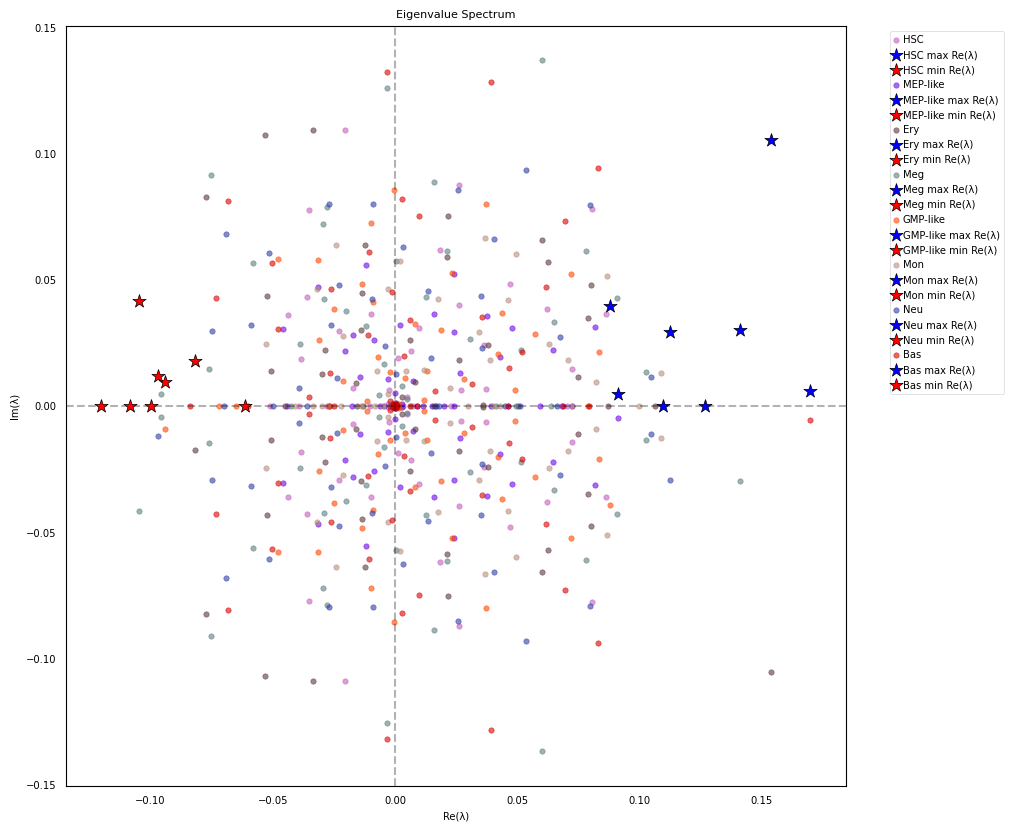

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
sch.pl.plot_eigenvalue_spectrum(
    adata,
    clusters=CELL_TYPE_ORDER,
    cluster_key=CLUSTER_KEY,
    colors=colors,
    highlight_extremes=True,
    ax=ax
)
plt.show()

## 5. Plot individual eigenvector components (optional)

Detailed view of eigenvector for a specific cluster

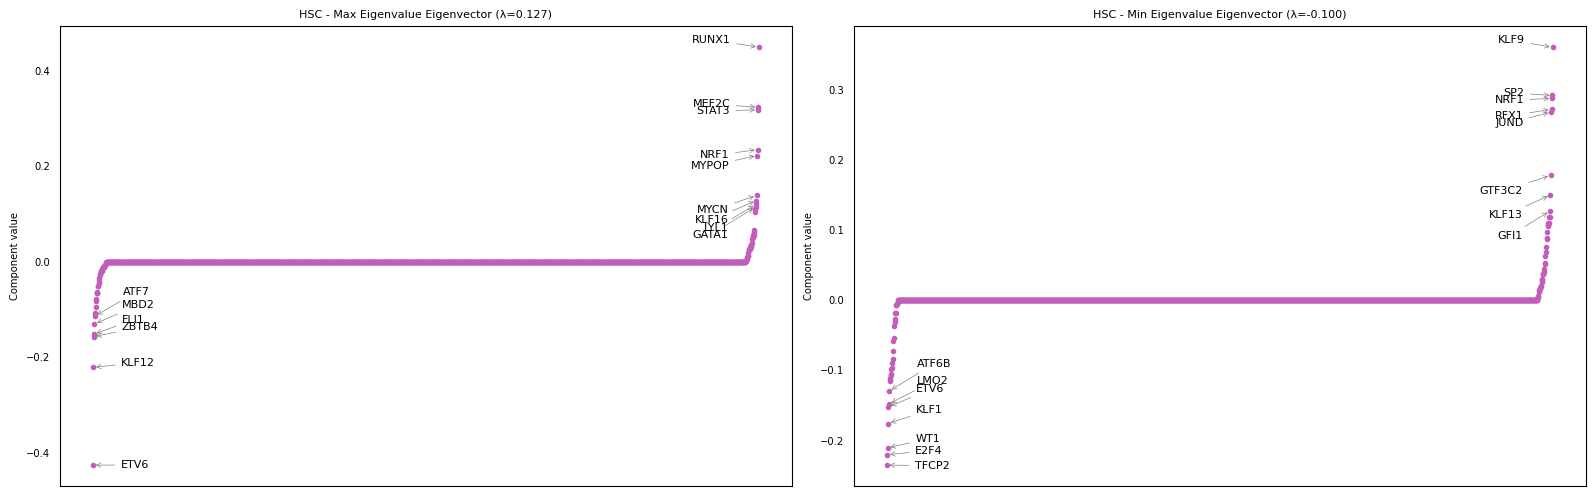

In [47]:
cluster_of_interest = 'HSC'

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Max eigenvalue eigenvector
sch.pl.plot_eigenvector_components(
    adata,
    cluster=cluster_of_interest,
    which='max',
    n_genes=15,
    cluster_key=CLUSTER_KEY,
    color=colors[cluster_of_interest],
    ax=axes[0]
)

# Min eigenvalue eigenvector
sch.pl.plot_eigenvector_components(
    adata,
    cluster=cluster_of_interest,
    which='min',
    n_genes=15,
    cluster_key=CLUSTER_KEY,
    color=colors[cluster_of_interest],
    ax=axes[1]
)

plt.tight_layout()
plt.show()

## 6. Get top genes for specific eigenvector (optional)

Get top genes from max eigenvalue eigenvector for HSC

In [48]:
df_top_genes_max = sch.tl.get_top_eigenvector_genes(
    adata,
    cluster='HSC',
    which='max',
    n_genes=20,
    part='real',
    cluster_key=CLUSTER_KEY
)

print(f"\nTop genes for HSC max eigenvalue eigenvector:")
print(f"Eigenvalue: {df_top_genes_max['eigenvalue'].iloc[0]}")
display(df_top_genes_max[['gene', 'component_value']])


Top genes for HSC max eigenvalue eigenvector:
Eigenvalue: (0.12664322555065155+0j)


gene  component_value
0    RUNX1         0.449393
1     ETV6        -0.426086
2    MEF2C         0.323812
3    STAT3         0.318392
4     NRF1         0.235006
5    MYPOP         0.222546
6    KLF12        -0.221303
7    ZBTB4        -0.157033
8     FLI1        -0.151819
9     MYCN         0.139003
10    MBD2        -0.130400
11   KLF16         0.128180
12    LYL1         0.119997
13   GATA1         0.114761
14    ATF7        -0.113765
15   KLF13         0.111398
16   FOSL2        -0.107873
17     WT1         0.104288
18     SP2        -0.094444
19  ZBTB14        -0.081947

## 7. Print eigenvalue extremes for all clusters

In [49]:
print("\nExtreme eigenvalues per cluster:")
for cluster in CELL_TYPE_ORDER:
    eigenvalues = adata.uns['scHopfield']['eigenanalysis'][f'eigenvalues_{cluster}']
    max_eigenval = eigenvalues[np.argmax(eigenvalues.real)]
    min_eigenval = eigenvalues[np.argmin(eigenvalues.real)]

    print(f"{cluster:15s} | Max Re(λ): {max_eigenval.real:8.3f} | Min Re(λ): {min_eigenval.real:8.3f}")


Extreme eigenvalues per cluster:
HSC             | Max Re(λ):    0.127 | Min Re(λ):   -0.100
MEP-like        | Max Re(λ):    0.091 | Min Re(λ):   -0.108
Ery             | Max Re(λ):    0.154 | Min Re(λ):   -0.082
Meg             | Max Re(λ):    0.141 | Min Re(λ):   -0.105
GMP-like        | Max Re(λ):    0.088 | Min Re(λ):   -0.094
Mon             | Max Re(λ):    0.110 | Min Re(λ):   -0.061
Neu             | Max Re(λ):    0.112 | Min Re(λ):   -0.097
Bas             | Max Re(λ):    0.170 | Min Re(λ):   -0.120


# Jacobian

## 1. Compute Jacobian eigenvalues
This computes eigenvalues for all cells\
WARNING: This can be memory intensive!  \
Consider saving to disk immediately after computation

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')



sch.tl.compute_jacobians(
    adata,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    compute_eigenvectors=False,  # Set True if you need eigenvectors (much larger!)
    device=device
)

## 2. Save Jacobians to disk (recommended!)
This saves eigenvalues to HDF5 file and removes from memory

In [ ]:
# sch.tl.save_jacobians(
#     adata,
#     filename='jacobian_eigenvalues.h5',
#     cluster_key=CLUSTER_KEY,
#     compression='gzip'
# )

# print("Jacobians saved to disk!")

## 3. Compute summary statistics from eigenvalues
This extracts useful summary stats and stores them in adata.obs

In [54]:
sch.tl.compute_jacobian_stats(
    adata,
    filename=None,  # Uses adata.obsm if None, or loads from file
    store_in_obs=True
)

print("Computed Jacobian statistics:")
print("- jacobian_eig1_real: First eigenvalue (real)")
print("- jacobian_eig1_imag: First eigenvalue (imag)")
print("- jacobian_positive_evals: Count of positive eigenvalues")
print("- jacobian_negative_evals: Count of negative eigenvalues")
print("- jacobian_trace: Trace of Jacobian")

Computed Jacobian statistics:
- jacobian_eig1_real: First eigenvalue (real)
- jacobian_eig1_imag: First eigenvalue (imag)
- jacobian_positive_evals: Count of positive eigenvalues
- jacobian_negative_evals: Count of negative eigenvalues
- jacobian_trace: Trace of Jacobian


## 4. Compute rotational part of Jacobian
This computes the antisymmetric part: A = 0.5*(J - J^T)\
Indicates local rotation strength

In [55]:
sch.tl.compute_rotational_part(
    adata,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    device=device
)

print("Computed jacobian_rotational in adata.obs")

Computing rotational part for cluster Mon


Cluster Mon: 100%|██████████| 423/423 [00:00<00:00, 4025.45it/s]


Computing rotational part for cluster Meg


Cluster Meg: 100%|██████████| 154/154 [00:00<00:00, 4120.54it/s]


Computing rotational part for cluster MEP-like


Cluster MEP-like: 100%|██████████| 457/457 [00:00<00:00, 4138.66it/s]


Computing rotational part for cluster Ery


Cluster Ery: 100%|██████████| 234/234 [00:00<00:00, 4175.28it/s]


Computing rotational part for cluster Bas


Cluster Bas: 100%|██████████| 177/177 [00:00<00:00, 4163.65it/s]


Computing rotational part for cluster GMP-like


Cluster GMP-like: 100%|██████████| 161/161 [00:00<00:00, 4181.32it/s]


Computing rotational part for cluster HSC


Cluster HSC: 100%|██████████| 309/309 [00:00<00:00, 4192.77it/s]


Computing rotational part for cluster Neu


Cluster Neu: 100%|██████████| 32/32 [00:00<00:00, 4082.30it/s]

Computed jacobian_rotational in adata.obs


## 5. Plot eigenvalue spectrum in complex plane

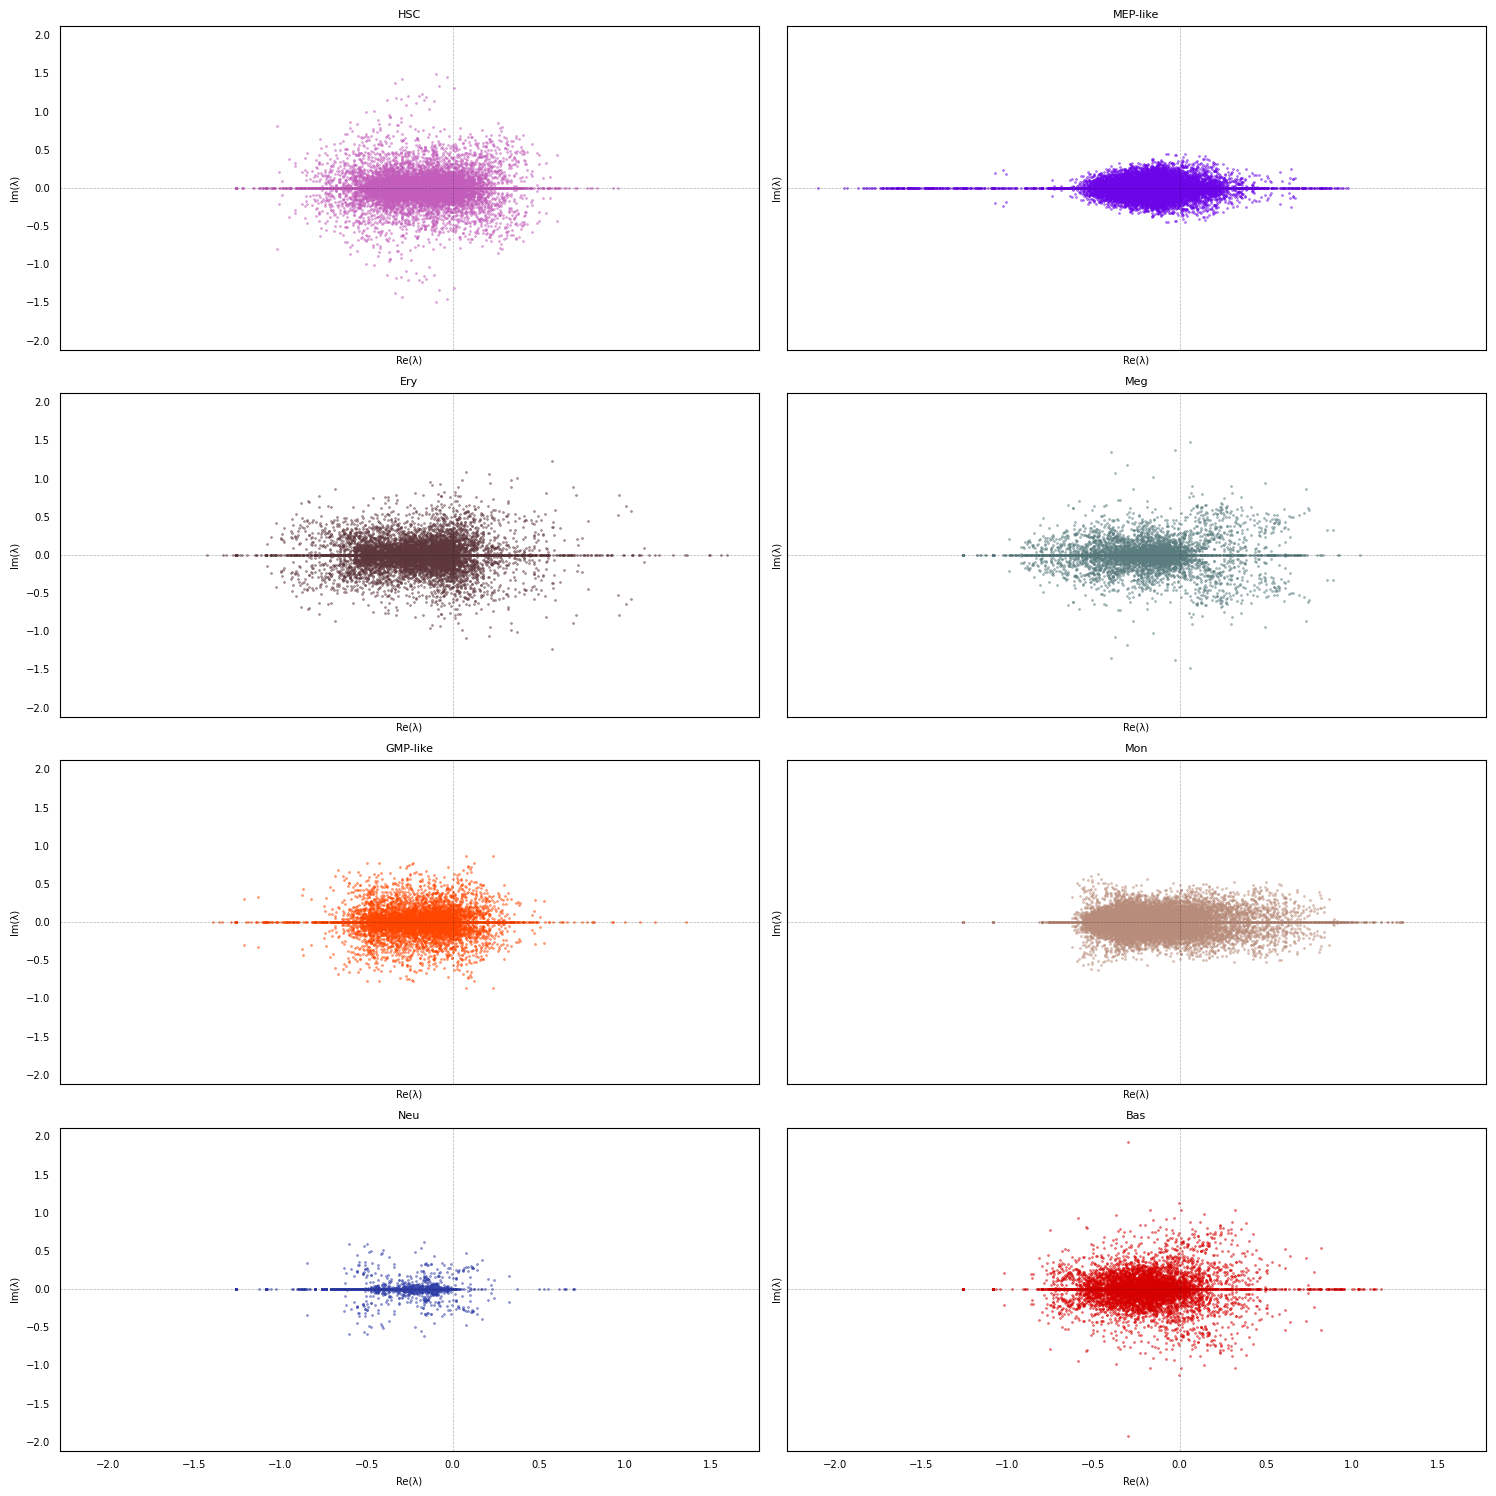

In [56]:
fig = sch.pl.plot_jacobian_eigenvalue_spectrum(
    adata,
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    figsize=(15, 15)
)
plt.show()

## 6. Plot boxplots of positive eigenvalues

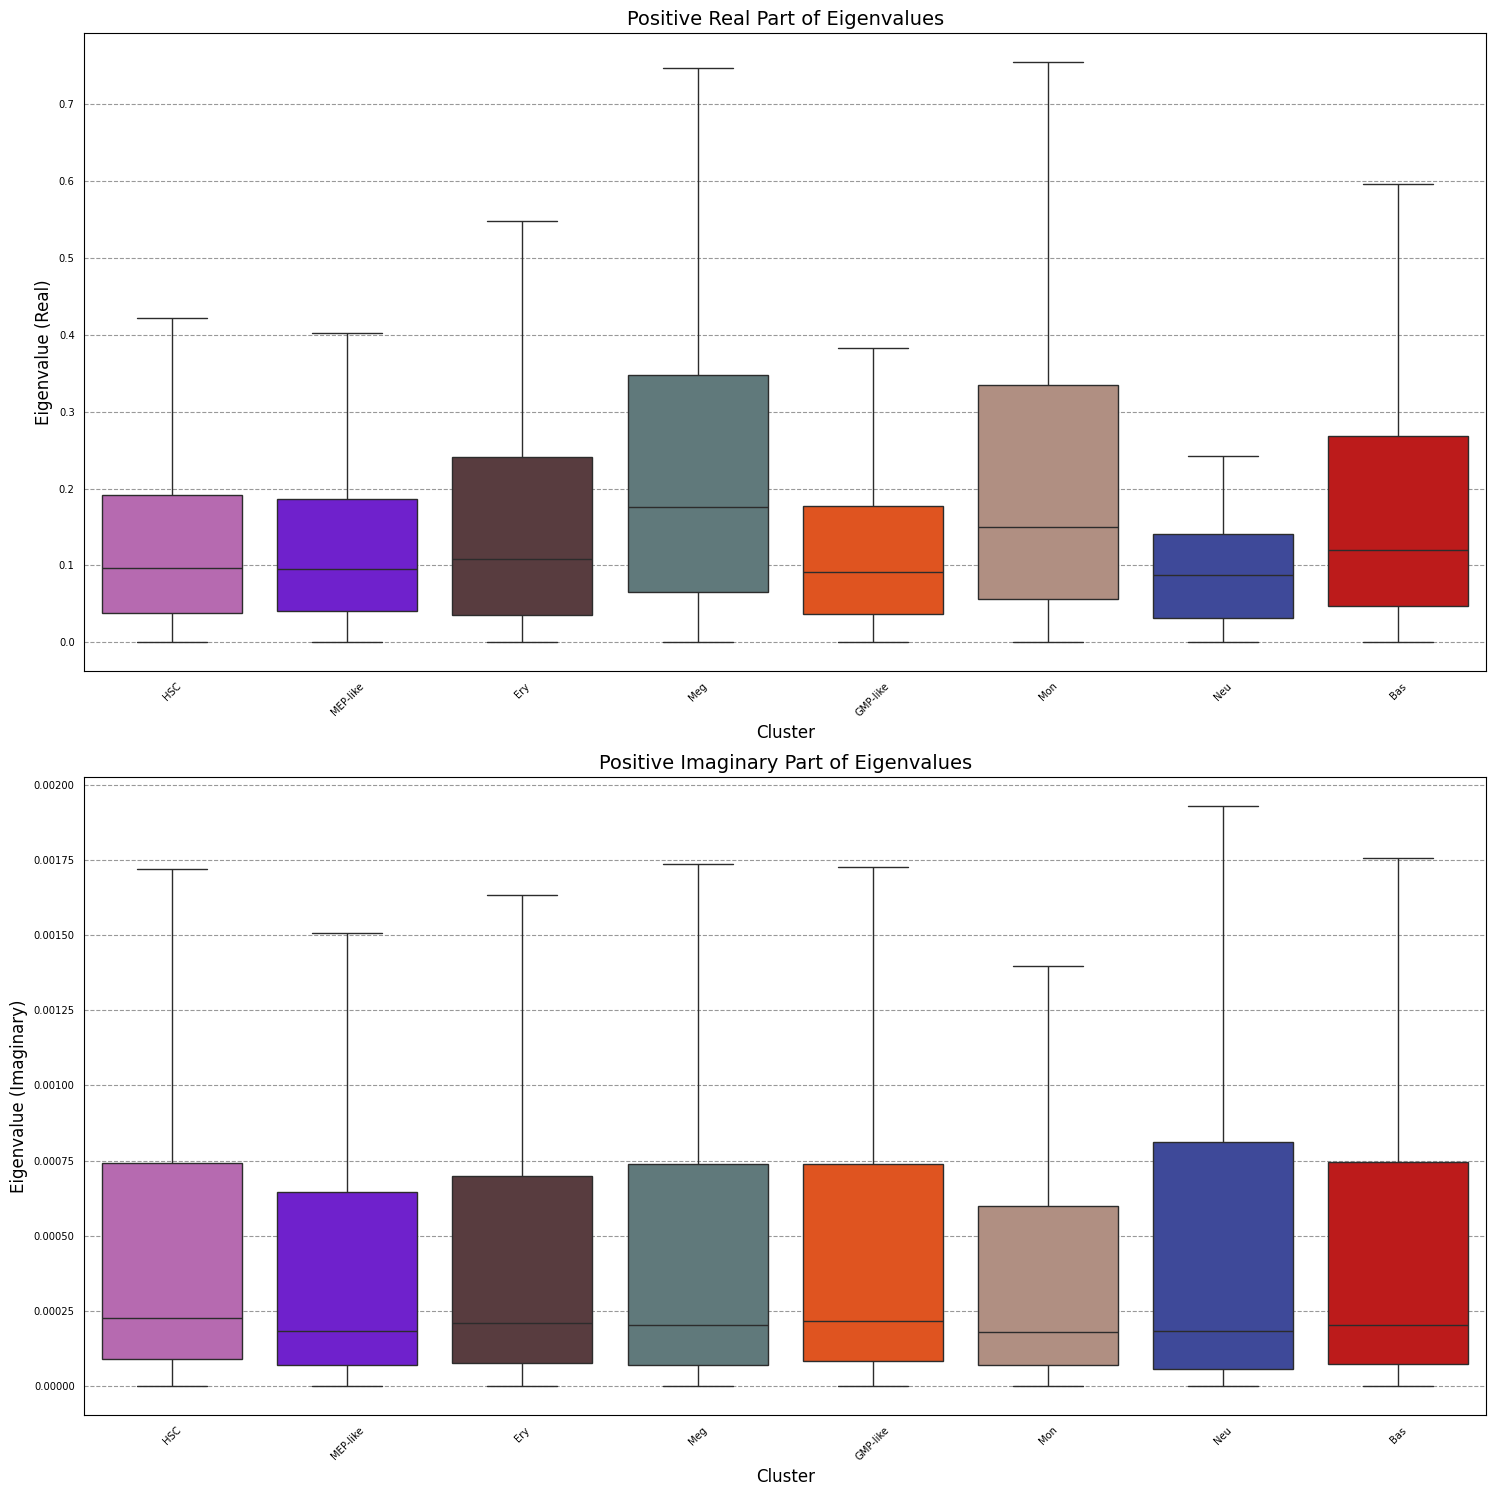

In [57]:
fig = sch.pl.plot_jacobian_eigenvalue_boxplots(
    adata,
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    figsize=(15, 15)
)
plt.show()

## 7. Plot Jacobian summary statistics

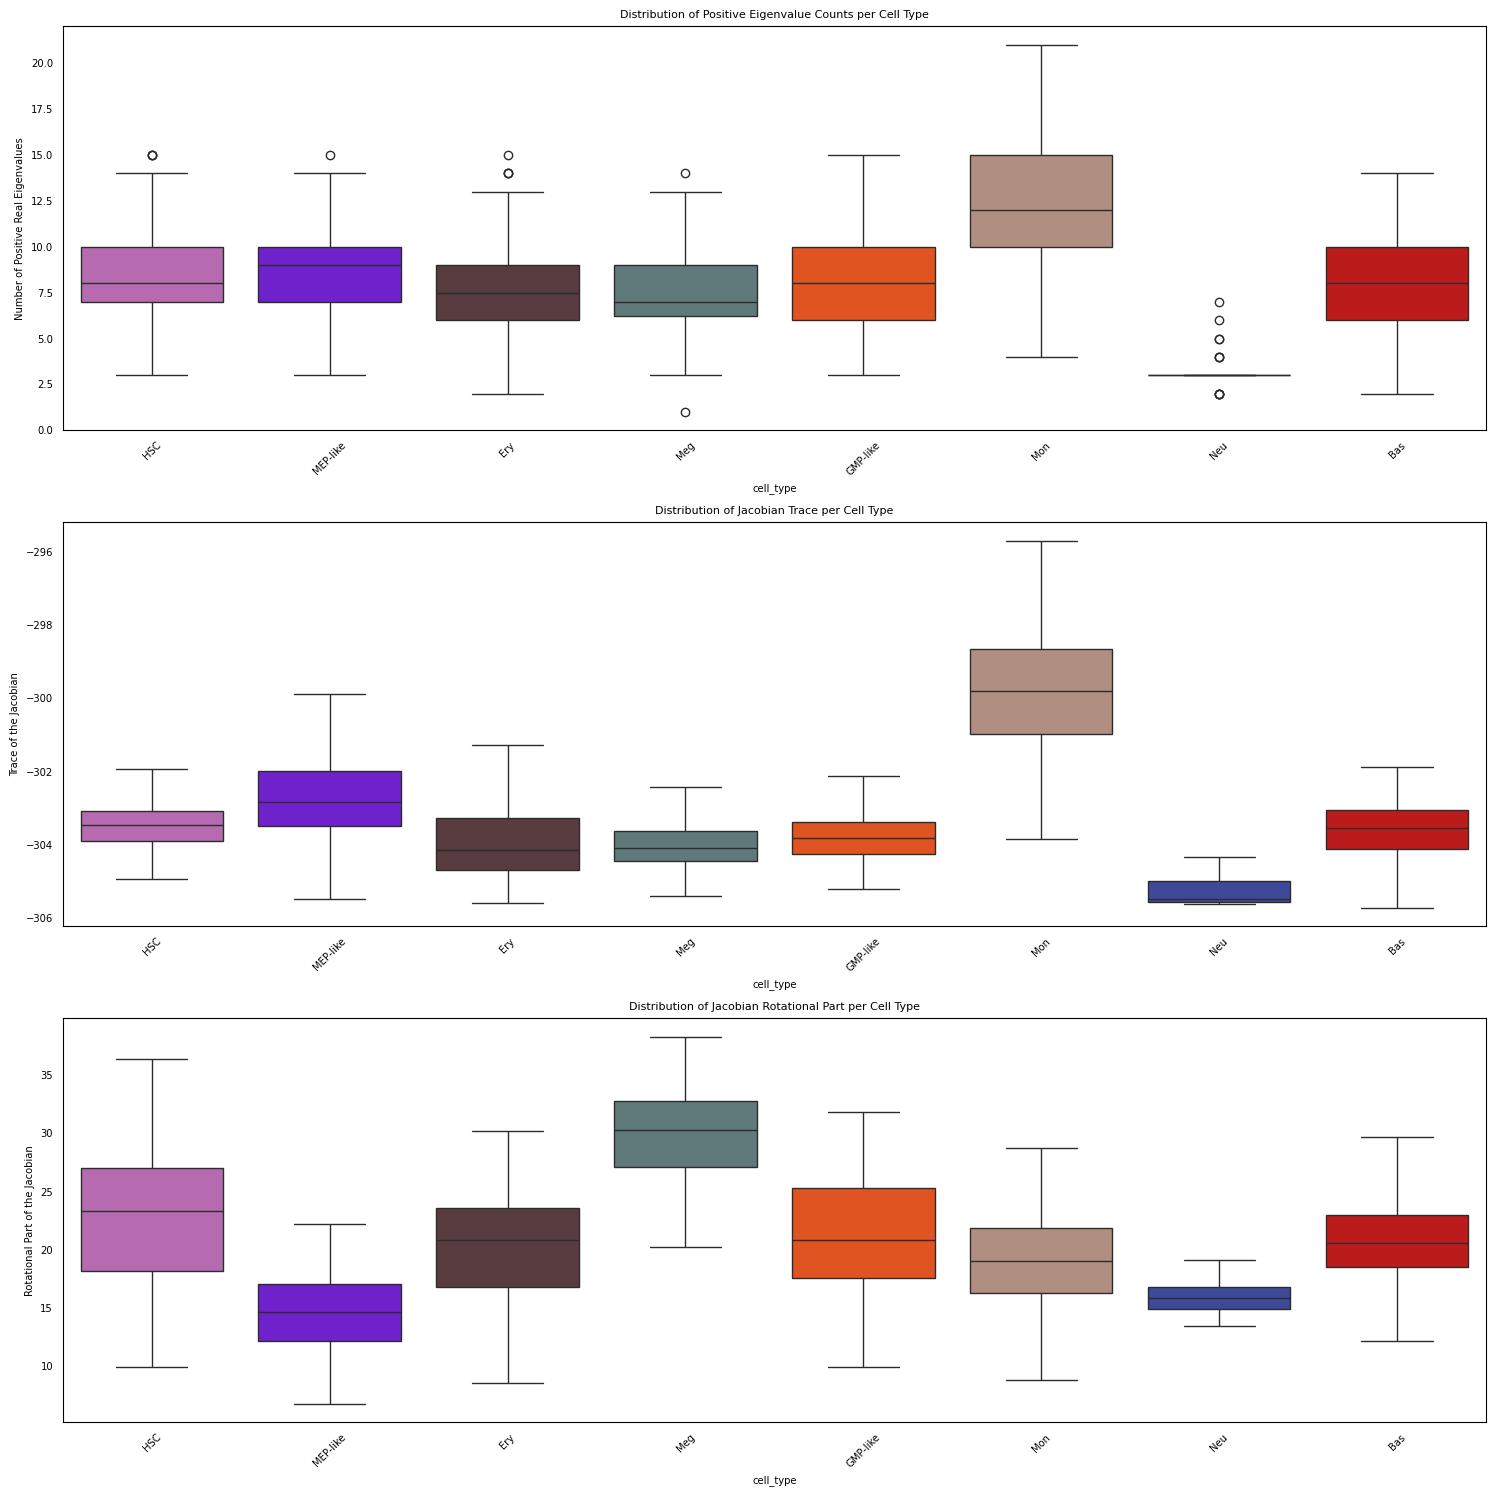

In [58]:
fig = sch.pl.plot_jacobian_stats_boxplots(
    adata,
    cluster_key=CLUSTER_KEY,
    order=CELL_TYPE_ORDER,
    colors=colors,
    figsize=(15, 15)
)
plt.show()

## 8. Compute specific Jacobian elements (partial derivatives)
For specific gene pairs of interest

In [59]:
gene_pairs = [
    ('FLI1', 'KLF1'),
    ('KLF1', 'FLI1'),
    ('FLI1', 'FLI1'),
    ('KLF1', 'KLF1'),
    ('GATA1', 'GATA2'),
    ('GATA2', 'GATA1'),
    ('GATA1', 'KLF1'),
    ('KLF1', 'GATA1'),
    ('GATA1', 'FLI1'),
    ('FLI1', 'GATA1'),
    ('CEBPA', 'RUNX1'),
    ('RUNX1', 'CEBPA'),
    ('CEBPA', 'GATA2'),
    ('GATA2', 'CEBPA'),
    ('GATA2', 'RUNX1'),
    ('RUNX1', 'GATA2'),
    ('GATA2', 'GATA2'),
    ('RUNX1', 'RUNX1'),
]

In [60]:
sch.tl.compute_jacobian_elements(
    adata,
    gene_pairs=gene_pairs,
    spliced_key=SPLICED_KEY,
    cluster_key=CLUSTER_KEY,
    device=device,
    store_in_obs=True
)

print("Computed Jacobian elements for gene pairs")
print("Stored in adata.obs with names like: jacobian_df_GATA1_dx_GATA2")

Computing Jacobian elements for cluster Mon


Cluster Mon: 100%|██████████| 423/423 [00:01<00:00, 404.77it/s]


Computing Jacobian elements for cluster Meg


Cluster Meg: 100%|██████████| 154/154 [00:00<00:00, 405.51it/s]


Computing Jacobian elements for cluster MEP-like


Cluster MEP-like: 100%|██████████| 457/457 [00:01<00:00, 405.27it/s]


Computing Jacobian elements for cluster Ery


Cluster Ery: 100%|██████████| 234/234 [00:00<00:00, 405.47it/s]


Computing Jacobian elements for cluster Bas


Cluster Bas: 100%|██████████| 177/177 [00:00<00:00, 403.67it/s]


Computing Jacobian elements for cluster GMP-like


Cluster GMP-like: 100%|██████████| 161/161 [00:00<00:00, 405.20it/s]


Computing Jacobian elements for cluster HSC


Cluster HSC: 100%|██████████| 309/309 [00:00<00:00, 400.41it/s]


Computing Jacobian elements for cluster Neu


Cluster Neu: 100%|██████████| 32/32 [00:00<00:00, 406.47it/s]

Computed Jacobian elements for gene pairs
Stored in adata.obs with names like: jacobian_df_GATA1_dx_GATA2


## 9. Plot Jacobian elements on UMAP

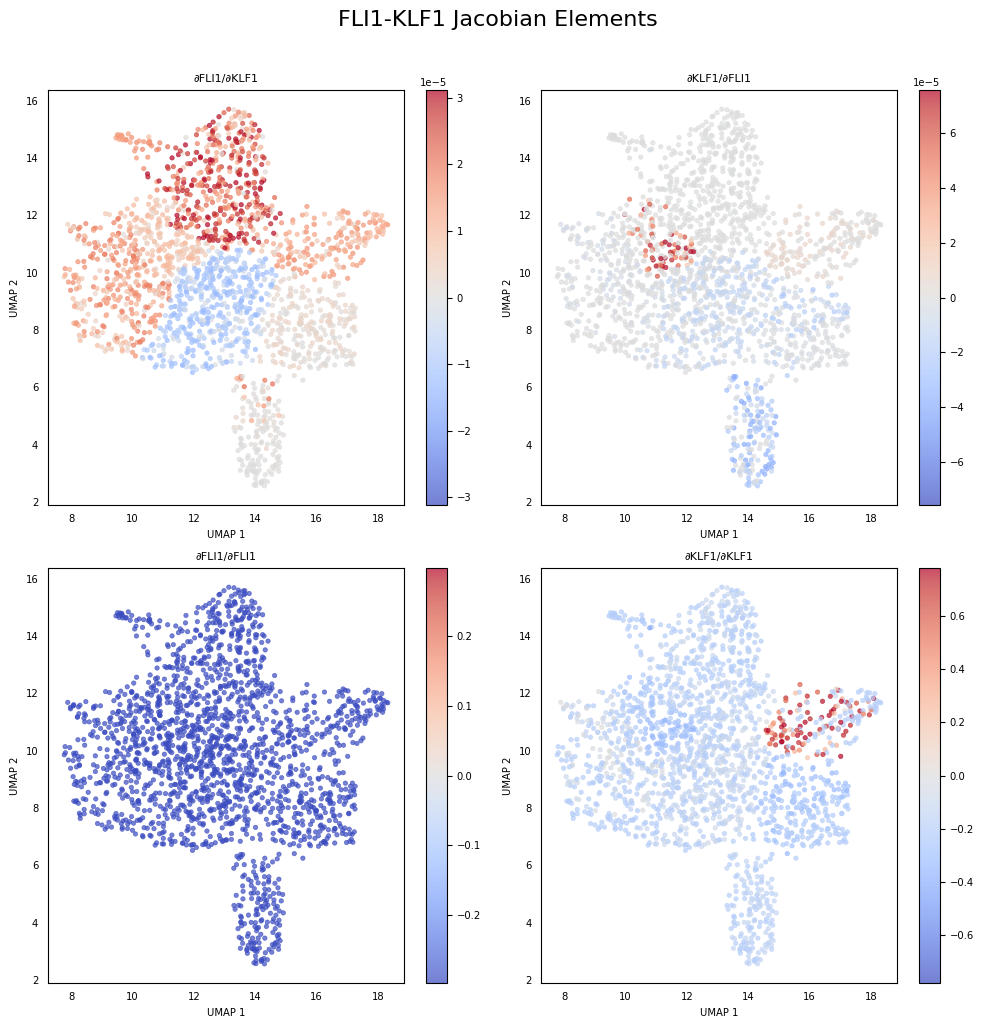

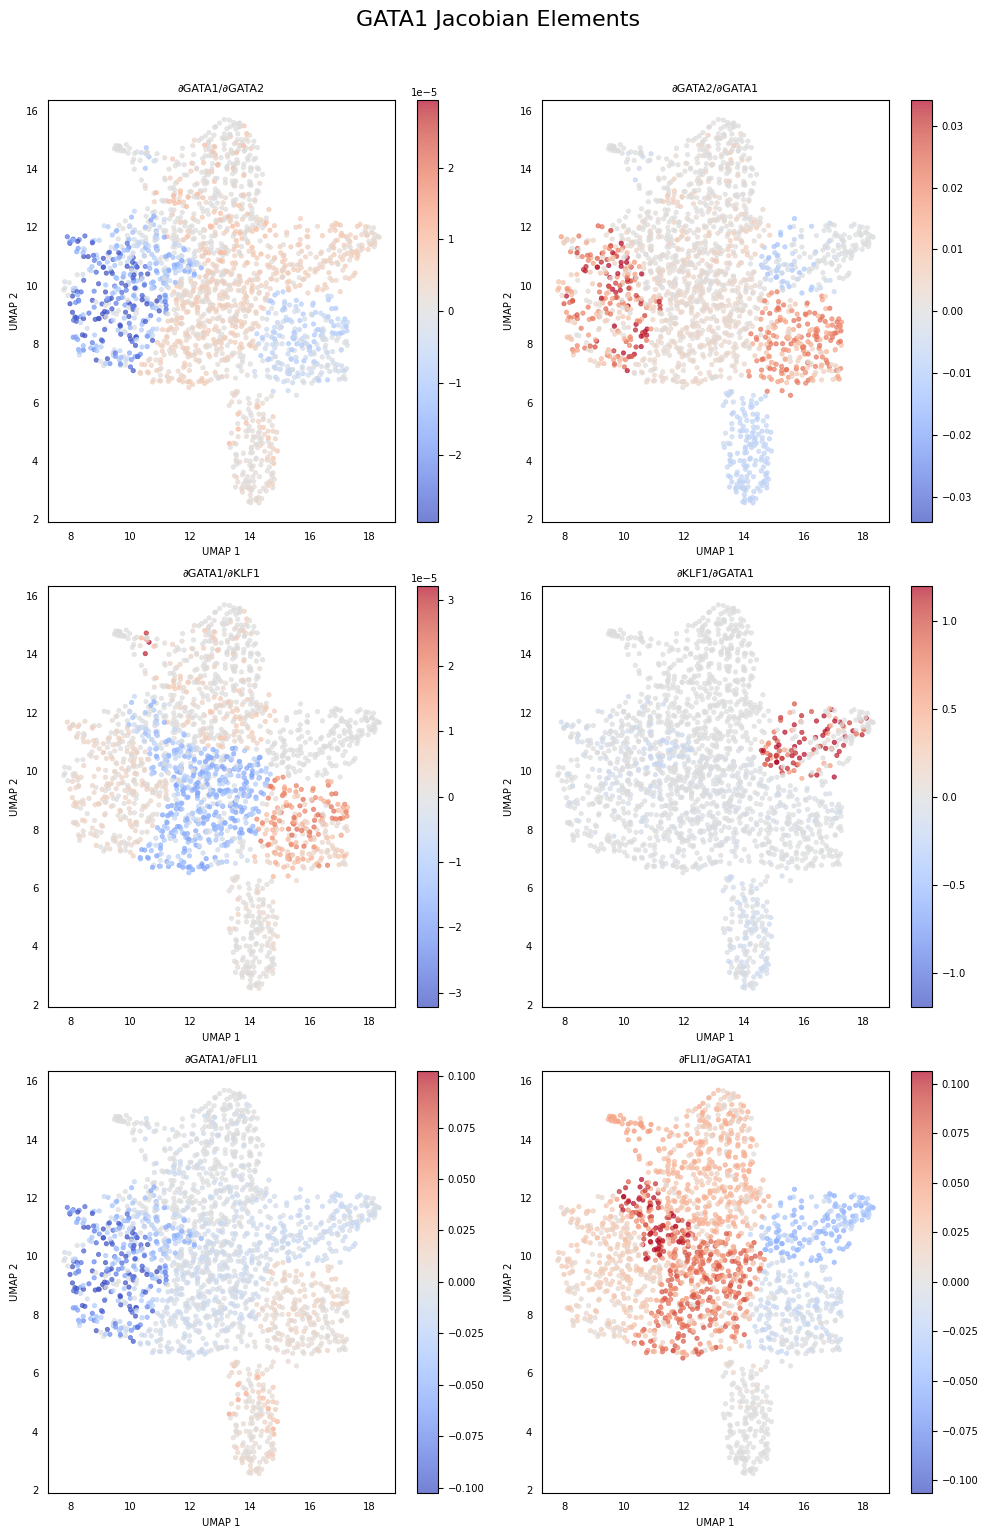

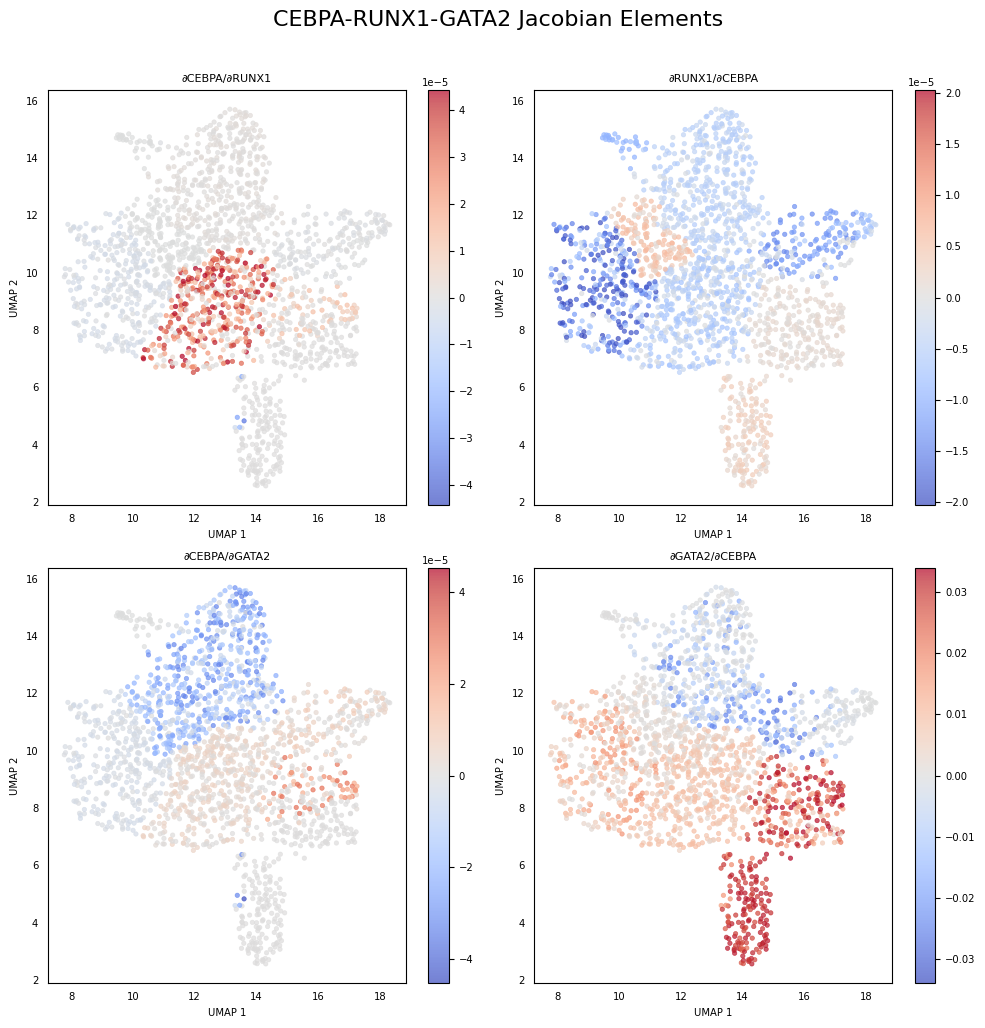

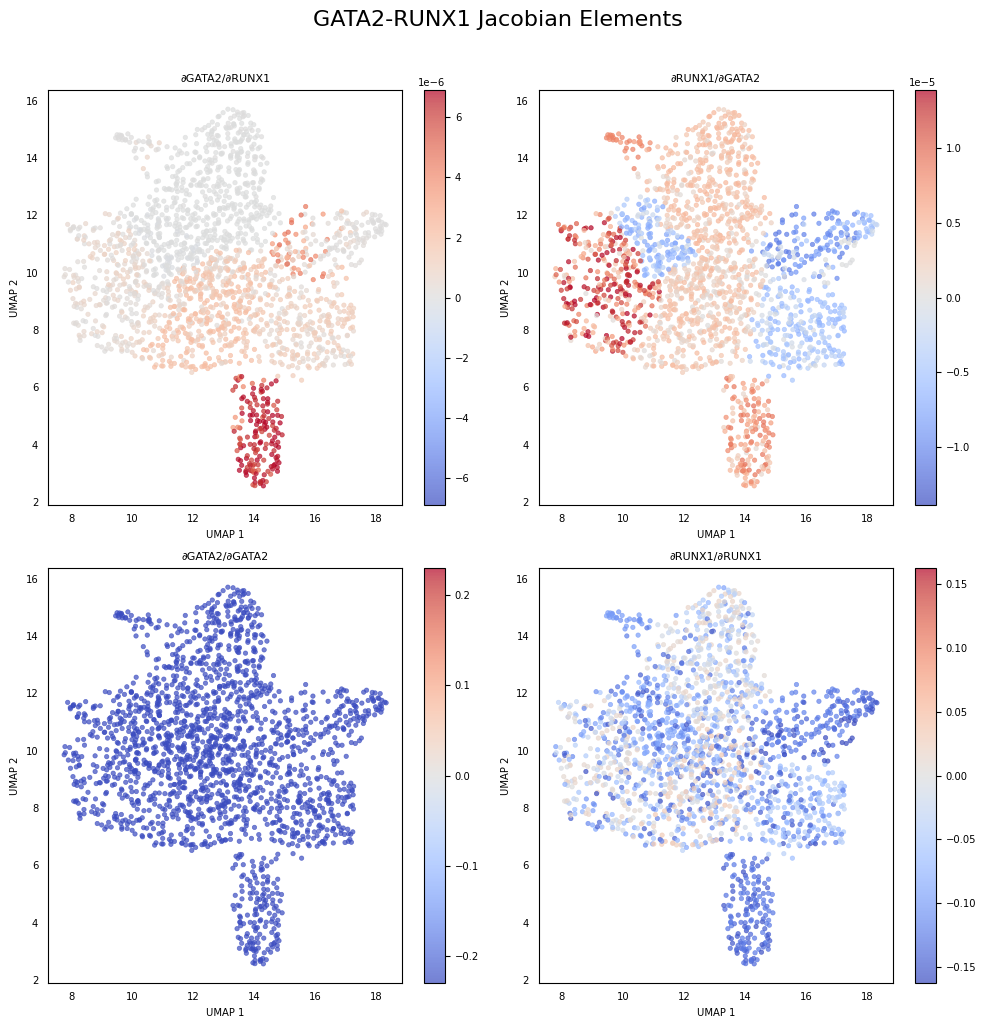

In [61]:
# FLI1-KLF1 interactions
fig = sch.pl.plot_jacobian_element_grid(
    adata,
    gene_pairs=[('FLI1', 'KLF1'), ('KLF1', 'FLI1'),
                ('FLI1', 'FLI1'), ('KLF1', 'KLF1')],
    ncols=2,
    figsize=(10, 10),
    s=10,
    alpha=0.7
)
plt.suptitle('FLI1-KLF1 Jacobian Elements', fontsize=16, y=1.02)
plt.show()

# GATA1-GATA2-KLF1-FLI1 interactions
fig = sch.pl.plot_jacobian_element_grid(
    adata,
    gene_pairs=[('GATA1', 'GATA2'), ('GATA2', 'GATA1'),
                ('GATA1', 'KLF1'), ('KLF1', 'GATA1'),
                ('GATA1', 'FLI1'), ('FLI1', 'GATA1')],
    ncols=2,
    figsize=(10, 15),
    s=10,
    alpha=0.7
)
plt.suptitle('GATA1 Jacobian Elements', fontsize=16, y=1.02)
plt.show()

# CEBPA-RUNX1-GATA2 interactions
fig = sch.pl.plot_jacobian_element_grid(
    adata,
    gene_pairs=[('CEBPA', 'RUNX1'), ('RUNX1', 'CEBPA'),
                ('CEBPA', 'GATA2'), ('GATA2', 'CEBPA')],
    ncols=2,
    figsize=(10, 10),
    s=10,
    alpha=0.7
)
plt.suptitle('CEBPA-RUNX1-GATA2 Jacobian Elements', fontsize=16, y=1.02)
plt.show()

# GATA2-RUNX1 interactions
fig = sch.pl.plot_jacobian_element_grid(
    adata,
    gene_pairs=[('GATA2', 'RUNX1'), ('RUNX1', 'GATA2'),
                ('GATA2', 'GATA2'), ('RUNX1', 'RUNX1')],
    ncols=2,
    figsize=(10, 10),
    s=10,
    alpha=0.7
)
plt.suptitle('GATA2-RUNX1 Jacobian Elements', fontsize=16, y=1.02)
plt.show()

## 10. (Optional) Load Jacobians from disk later

In [62]:
# If you saved to disk and want to reload later:

# sch.tl.load_jacobians(
#     adata,
#     filename='jacobian_eigenvalues.h5',
#     load_eigenvectors=False
# )
#
# # Then recompute stats:
# sch.tl.compute_jacobian_stats(adata, store_in_obs=True)

## 11. Summary table of Jacobian properties per cluster

In [63]:
summary = adata.obs.groupby(CLUSTER_KEY).agg({
    'jacobian_positive_evals': ['mean', 'std'],
    'jacobian_negative_evals': ['mean', 'std'],
    'jacobian_trace': ['mean', 'std'],
    'jacobian_rotational': ['mean', 'std']
})

print("\nJacobian Statistics Summary:")
display(summary.round(3))

# ============================================================
# 12. Print extreme eigenvalues per cluster
# ============================================================
print("\nExtreme eigenvalues per cluster:")
eigenvalues = adata.obsm['jacobian_eigenvalues']
for cluster in CELL_TYPE_ORDER:
    mask = (adata.obs[CLUSTER_KEY] == cluster).values
    evals_cluster = eigenvalues[mask]

    max_real = evals_cluster.real.max()
    min_real = evals_cluster.real.min()

    print(f"{cluster:15s} | Max Re(λ): {max_real:8.3f} | Min Re(λ): {min_real:8.3f}")


Jacobian Statistics Summary:


jacobian_positive_evals        jacobian_negative_evals         \
                             mean    std                    mean    std   
cell_type                                                                 
Bas                         8.000  2.398                1720.000  2.398   
Ery                         7.654  2.587                1720.346  2.587   
GMP-like                    7.969  2.611                1720.031  2.611   
HSC                         8.434  2.371                1719.566  2.371   
MEP-like                    8.676  2.194                1719.324  2.194   
Meg                         7.662  1.879                1720.338  1.879   
Mon                        12.208  3.370                1715.792  3.370   
Neu                         3.312  1.091                1724.688  1.091   

          jacobian_trace        jacobian_rotational         
                    mean    std                mean    std  
cell_type                                                   
Bas             -303.617  0.786              20.784  4.042  
Ery             -303.913  1.064              20.498  4.596  
GMP-like        -303.793  0.642              21.443  4.775  
HSC             -303.450  0.573              22.656  5.510  
MEP-like        -302.746  1.073              14.622  3.077  
Meg             -304.027  0.616              29.975  4.637  
Mon             -299.817  1.661              19.036  3.723  
Neu             -305.253  0.403              16.030  1.440


Extreme eigenvalues per cluster:
HSC             | Max Re(λ):    0.961 | Min Re(λ):   -1.257
MEP-like        | Max Re(λ):    0.977 | Min Re(λ):   -2.096
Ery             | Max Re(λ):    1.593 | Min Re(λ):   -1.428
Meg             | Max Re(λ):    1.044 | Min Re(λ):   -1.257
GMP-like        | Max Re(λ):    1.351 | Min Re(λ):   -1.391
Mon             | Max Re(λ):    1.293 | Min Re(λ):   -1.257
Neu             | Max Re(λ):    0.705 | Min Re(λ):   -1.257
Bas             | Max Re(λ):    1.166 | Min Re(λ):   -1.257


# Networks with prevalent genes

In [ ]:
# ============================================================
# 1. Full GRN Network Plots (Top N Genes by Centrality)
# ============================================================

# Create custom colormap for edges (blue-lightgray-red)
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

# Choose centrality metric for node sizing
score = 'degree_centrality_out'  # Options: 'degree_centrality_all', 'eigenvector_centrality', etc.
topn = 50  # Number of top genes to show

fig, axs = plt.subplots(4, 2, figsize=(20, 40), tight_layout=True)

for cluster, ax in zip(CELL_TYPE_ORDER, axs.flat):
    ax.axis('off')
    ax.set_title(f'{score.replace("_", " ").capitalize()} - {cluster}')

    sch.pl.plot_grn_network(
        adata,
        cluster=cluster,
        cluster_key=CLUSTER_KEY,
        score_size=score,  # Use centrality for node size
        cmap=custom_cmap,
        size_threshold=0.25,  # Hide labels for small nodes
        topn=topn,
        w_quantile=0.99,  # Keep only top 1% strongest edges
        ax=ax
    )

plt.show()

# ============================================================
# 2. Subset GRN with Custom Node Positions
# ============================================================
# Focus on specific genes with manual layout

# Define custom node positions
custom_positions = {
    'CEBPA': (1, 1),
    'GATA1': (4, 1),
    'GATA2': (0, 0),
    'RUNX1': (2, 0),
    'KLF1': (3, 0),
    'FLI1': (5, 0)
}

# Define specific edges to show
selected_edges = [
    ('CEBPA', 'GATA2'), ('CEBPA', 'RUNX1'),
    ('GATA2', 'GATA2'), ('GATA2', 'RUNX1'), ('GATA2', 'GATA1'),
    ('RUNX1', 'GATA2'), ('RUNX1', 'RUNX1'),
    ('GATA1', 'KLF1'), ('GATA1', 'FLI1'), ('GATA1', 'GATA2'),
    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
]

fig, axs = plt.subplots(4, 2, figsize=(20, 15), tight_layout=True)

for cluster, ax in zip(CELL_TYPE_ORDER, axs.flat):
    ax.axis('off')
    ax.set_title(f'{cluster} - Key Regulatory Genes')

    sch.pl.plot_grn_subset(
        adata,
        cluster=cluster,
        selected_genes=list(custom_positions.keys()),
        cluster_key=CLUSTER_KEY,
        score_size=score,
        node_positions=custom_positions,
        selected_edges=selected_edges,
        label_offset=0.08,
        variable_width=True,  # Edge width proportional to interaction strength
        ax=ax
    )

plt.show()

# ============================================================
# 3. Mean Jacobian Networks (Cell-State Averaged)
# ============================================================
# Visualize average Jacobian matrices per cluster

# Compute mean Jacobian for each cluster
# (Assuming you have jacobians computed from earlier Jacobian analysis section)
if 'jacobian_eigenvalues' in adata.obsm:
    # Load full Jacobians if saved
    # jacobians_full = sch.tl.load_jacobians(adata, 'jacobian_eigenvalues.h5', load_eigenvectors=True)
    # Or compute mean Jacobian from stored elements
    # For this example, we'll use the W matrices instead

    fig, axs = plt.subplots(4, 2, figsize=(20, 40), tight_layout=True)

    for cluster, ax in zip(CELL_TYPE_ORDER, axs.flat):
        ax.axis('off')
        ax.set_title(f'Interaction Network - {cluster}')

        # Use interaction matrix (W) directly
        sch.pl.plot_grn_network(
            adata,
            cluster=cluster,
            cluster_key=CLUSTER_KEY,
            score_size=None,  # Use sum of connections for sizing
            cmap=custom_cmap,
            size_threshold=0.25,
            topn=50,
            ax=ax
        )

    plt.show()

# ============================================================
# 4. Simple Two-Gene Motif (e.g., FLI1-KLF1)
# ============================================================

fig, axs = plt.subplots(4, 2, figsize=(10, 8), tight_layout=True)

custom_positions_simple = {
    'KLF1': (0, 0),
    'FLI1': (1, 0)
}

for cluster, ax in zip(CELL_TYPE_ORDER, axs.flat):
    ax.axis('off')
    ax.set_title(f'{cluster} - FLI1/KLF1 Circuit')

    sch.pl.plot_grn_subset(
        adata,
        cluster=cluster,
        selected_genes=list(custom_positions_simple.keys()),
        cluster_key=CLUSTER_KEY,
        score_size=score,
        node_positions=custom_positions_simple,
        label_offset=0.08,
        variable_width=True,
        ax=ax
    )

plt.show()

# ============================================================
# 5. Network Comparison: W vs Mean Jacobian
# ============================================================
# Compare steady-state interaction matrix with dynamical Jacobian

fig, axs = plt.subplots(2, 2, figsize=(20, 15), tight_layout=True)

clusters_compare = ['HSC', 'Meg', 'Ery', 'Mon']

for idx, (cluster, ax) in enumerate(zip(clusters_compare, axs.flat)):
    ax.axis('off')
    ax.set_title(f'{cluster} - Interaction Network')

    sch.pl.plot_grn_subset(
        adata,
        cluster=cluster,
        selected_genes=['CEBPA', 'GATA1', 'GATA2', 'RUNX1', 'KLF1', 'FLI1'],
        cluster_key=CLUSTER_KEY,
        score_size=score,
        node_positions=custom_positions,
        selected_edges=selected_edges,
        label_offset=0.08,
        variable_width=True,
        ax=ax
    )

plt.show()

# ============================================================
# 6. Export Network Data for External Visualization
# ============================================================
# Get network edge list for use in Cytoscape, Gephi, etc.

# Get network links for a specific cluster
links_hsc = sch.tl.get_network_links(
    adata,
    cluster_key=CLUSTER_KEY,
    return_format='dict'
)['HSC']

print(f"HSC network has {len(links_hsc)} edges")
print("\nSample edges:")
display(links_hsc.head(10))

# Save to CSV for external tools
links_hsc.to_csv('HSC_network_edges.csv', index=False)
print("\nNetwork edges saved to 'HSC_network_edges.csv'")

## Code

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap, LinearSegmentedColormap

def GRN_graph(
    ls, W1, genes, merged_scores, 
    score_size=None, size_threshold=0, score_color=None, cmap=None,  
    topn=None, ax=None, w_quantile=0.99
):
    """
    Generates a Gene Regulatory Network (GRN) graph.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        genes (list): List of gene names.
        merged_scores (pd.DataFrame): Dataframe containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        size_threshold (float, optional): Threshold for displaying node labels. Defaults to 0.
        score_color (str, optional): Not currently used. Defaults to None.
        cmap (str or Colormap, optional): Colormap for edge coloring. Defaults to None.
        topn (int, optional): Number of top genes to retain based on size. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        w_quantile (float, optional): Quantile threshold for filtering weak edges. Defaults to 0.99.

    Returns:
        None: Displays a network plot.
    """

    # Copy matrix to avoid modifying original data
    W = W1.copy()
    
    # Threshold edges based on weight quantile
    threshold = np.quantile(abs(W), w_quantile)
    W[abs(W) < threshold] = 0

    # Create DataFrame representation
    df = pd.DataFrame(W, index=ls.gene_names, columns=ls.gene_names).T

    # Compute node sizes
    if score_size is None:
        sizes = abs(W).sum(axis=0) + abs(W).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in df.index
        ])

    # Filter top genes based on size
    topq = np.sort(sizes)[-topn] if topn is not None else 0
    dropids = df.index[sizes < topq]
    
    # Normalize sizes for better visualization
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = sizes[ls.gene_names.isin(genes)]
    sizes = size_multiplier * sizes[sizes >= topq]
    
    # Remove genes below threshold
    genes = [g for g in genes if g not in dropids]
    df.drop(index=dropids, columns=dropids, inplace=True)
    df = df[genes].loc[genes]

    # Define node labels (hide small ones)
    labels = {
        gene: gene if size / 1000 > size_threshold else ''
        for gene, size in zip(df.index, sizes)
    }

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)
    Gp = nx.from_pandas_adjacency(abs(df), create_using=nx.DiGraph)

    # Compute edge weights for visualization
    weights = np.array([abs(G[u][v]['weight']) for u, v in G.edges()])
    weights_signed = 10 * np.array([G[u][v]['weight'] for u, v in G.edges()])
    weights = 1.5 * np.log(1 + weights) / np.log(1 + max(weights)) if weights.size else weights

    # Define node positions
    pos = nx.circular_layout(G)  # Alternative: nx.spring_layout(Gp), nx.kamada_kawai_layout(Gp)

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Validate colormap input
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap) if cmap is not None else plt.cm.viridis
    elif not isinstance(cmap, Colormap):
        raise ValueError("`cmap` must be a string or a matplotlib.colors.Colormap instance")

    # Compute colormap normalization
    vmax = max(weights) if weights.size else 1

    # Draw network graph
    nx.draw_networkx(
        G, pos, node_size=sizes, width=weights, with_labels=True, labels=labels,
        edge_color=weights_signed, edge_cmap=cmap, edge_vmin=-vmax, edge_vmax=vmax, ax=ax
    )

    plt.tight_layout()

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap


import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def plot_subset_grn(
    ls, W1, selected_genes, merged_scores, 
    score_size=None, ax=None, node_positions=None,
    prune_threshold=0, selected_edges=None, 
    node_color='white', label_offset=0.11, label_size=12,
    variable_width = False,
):
    """
    Plots a Gene Regulatory Network (GRN) for a user-defined subset of genes.

    Args:
        ls (object): Object containing `gene_names`.
        W1 (np.ndarray): Weighted adjacency matrix of interactions.
        selected_genes (list): List of genes to include in the graph.
        merged_scores (pd.DataFrame): DataFrame containing gene scores.
        score_size (str, optional): Column in `merged_scores` to use for node sizes. Defaults to None.
        ax (matplotlib.axes.Axes, optional): Axis for plotting. Defaults to None.
        node_positions (dict, optional): Dictionary with custom node positions.
        prune_threshold (float, optional): Edges below this threshold (absolute value) will be removed.
        selected_edges (list of tuples, optional): List of user-defined edges (tuples) to plot.
        node_color (str, optional): Color of nodes. Default is `"skyblue"`.
        label_offset (float, optional): Distance of labels from nodes. Default is `0.15`.
        label_size (int, optional): Font size for labels. Default is `12`.

    Returns:
        None: Displays a network plot.
    """

    # Convert adjacency matrix to DataFrame
    df = pd.DataFrame(W1, index=ls.gene_names, columns=ls.gene_names).T

    # Subset the graph to only the selected nodes
    df = df.loc[selected_genes, selected_genes]

    # **Prune weak edges**
    df[abs(df) < prune_threshold] = 0  

    # **Filter only user-defined edges (if provided)**
    if selected_edges:
        mask = np.zeros_like(df, dtype=bool)
        for u, v in selected_edges:
            if u in df.index and v in df.columns:
                mask[df.index.get_loc(u), df.columns.get_loc(v)] = True
        df[~mask] = 0  # Keep only selected edges

    # Compute node sizes
    if score_size is None:
        sizes = abs(df).sum(axis=0) + abs(df).sum(axis=1)
    else:
        sizes = np.array([
            merged_scores.loc[g, score_size] if g in merged_scores.index else 0 
            for g in selected_genes
        ])

    # Normalize sizes
    size_multiplier = 1000 / max(sizes) if max(sizes) > 0 else 1
    sizes = size_multiplier * sizes
    node_size_dict = {node: size for node, size in zip(selected_genes, sizes)}

    # Define node labels
    labels = {gene: gene for gene in selected_genes}

    # Create directed graph
    G = nx.from_pandas_adjacency(df, create_using=nx.DiGraph)

    # Compute edge weights
    edge_list = [(u, v) for u, v in G.edges() if abs(G[u][v]['weight']) >= prune_threshold]
    weights = np.array([abs(G[u][v]['weight']) for u, v in edge_list])
    weights_signed = np.array([G[u][v]['weight'] for u, v in edge_list])

    # Normalize edge widths
    weights = 2 * np.log1p(weights) / np.log1p(weights.max()) if weights.size else weights

    # Use predefined node positions if provided, otherwise default to spring layout
    pos = {gene: node_positions[gene] for gene in selected_genes if gene in node_positions} if node_positions else {}
    if len(pos) < len(selected_genes):
        default_layout = nx.spring_layout(G)
        for node in selected_genes:
            if node not in pos:
                pos[node] = default_layout[node]

    # Define axes
    ax = ax or plt.figure(figsize=(10, 10)).gca()

    # Set fixed edge colors (Red for positive, Blue for negative)
    edge_colors = ['red' if w > 0 else 'blue' for w in weights_signed]

    # Handle bidirectional edges: shift arcs slightly to avoid overlap
    curved_edges = set()
    for u, v in edge_list:
        if u == v:
            continue
        if (v, u) in edge_list and (v, u) not in curved_edges:
            curved_edges.add((u, v))
            curved_edges.add((v, u))

    # # **Calculate dynamic arrow size based on node size**
    # min_arrow_size = 15
    # max_arrow_size = 35
    # arrow_sizes = np.clip(weights * 10, min_arrow_size, max_arrow_size)

    # **Adjust margins for each node**
    min_margin = 0.02
    max_margin = 0.1
    node_margins = {node: np.clip(size / 2000, min_margin, max_margin) for node, size in node_size_dict.items()}

    # **First, draw edges BELOW nodes (background)**
    # nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=weights, edge_color=edge_colors, 
    #                        ax=ax, alpha=0.4, connectionstyle="arc3,rad=0.1")

    # **Then, draw nodes (foreground)**
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_color, edgecolors='black', linewidths=1.5, ax=ax, alpha=0.9)

    # **Move labels outside the nodes**
    adjusted_pos = {k: (v[0], v[1] + label_offset) for k, v in pos.items()}
    nx.draw_networkx_labels(G, adjusted_pos, labels, font_size=label_size, ax=ax)

    # **Finally, draw edges ABOVE nodes with adjusted arrows**
    for edge in edge_list:
        u, v = edge
        edge_idx = edge_list.index(edge)
        width = weights[edge_idx] if variable_width else 1
        style = "arc3,rad=0.15" if edge in curved_edges else "arc3,rad=0"
        nx.draw_networkx_edges(G, pos, edgelist=[edge], width=width,
                               edge_color=[edge_colors[edge_idx]], ax=ax, 
                               arrows=True, #arrowsize=arrow_sizes[edge_idx], 
                               min_source_margin=node_margins.get(u, min_margin), 
                               min_target_margin=node_margins.get(v, min_margin), 
                               connectionstyle=style)

    plt.tight_layout()

## Figure from Networks

In [ ]:

colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, ls.W[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## Figure from Jacobian

In [ ]:
jacobians['jacobians'].shape

(1947, 1728, 1728)

In [ ]:
mean_jacobian = {}
for k in order:
    cell_idx = np.where(adata.obs[cluster_key] == k)[0]
    mean_jacobian[k] = np.mean(jacobians['jacobians'][cell_idx], axis=0)

In [ ]:
colors_graph = ["blue", "lightgray", "red"]
positions = [0, 0.5, 1]  # Must range from 0 to 1
# Step 2: Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(positions, colors_graph)))

k = 'Ductal'
fig,axs = plt.subplots(4,2, figsize=(20,40),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']
score = score_names[5]
topn = 50

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)


    GRN_graph(ls, mean_jacobian[k],ls.gene_names, links.merged_score[links.merged_score.cluster==k], score_size=None, cmap=custom_cmap, size_threshold=0.25, topn=topn, ax=ax)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(20,15),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'CEBPA': (1,1), 'GATA1': (4,1), 'GATA2': (0,0), 
    'RUNX1': (2,0), 'KLF1': (3,0), 'FLI1': (5,0)
}

selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
                   ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
                   ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
                   ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
                   ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)

    plot_subset_grn(ls, mean_jacobian[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=None, ax=ax, node_positions=custom_positions, selected_edges=selected_edeges, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

## FLI1 - KLF1 exploration

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dyn.pl.scatters(ls.adata, color='FLI1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[0], sym_c=True)
dyn.pl.scatters(ls.adata, color='KLF1', basis='umap', show_legend='on data', cmap='viridis', save_show_or_return='return', ax=axs[1], sym_c=True)
plt.show()

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

In [ ]:
ls.adata.obs[r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$'] = jacobians['jacobians'][:,index_fli1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_klf1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$'] = jacobians['jacobians'][:,index_fli1,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][:,index_fli1].A.flatten()
ls.adata.obs[r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$'] = jacobians['jacobians'][:,index_klf1,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][:,index_klf1].A.flatten()


fig,axs = plt.subplots(2,2,figsize=(20,15))
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{{FLI1}}}{dx_{{KLF1}}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,0], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{FLI1}}{dx_{FLI1}}\times FLI1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[0,1], sym_c=True)
dyn.pl.scatters(ls.adata, color=r'$\frac{df_{KLF1}}{dx_{KLF1}}\times KLF1$', basis='umap', show_legend='on data', cmap='coolwarm', save_show_or_return='return', ax=axs[1,1], sym_c=True)
plt.show()

### Effective effect network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W[:,:,index_klf1] = W[:,:,index_klf1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_klf1].A.flatten()[:,None]
    W[:,:,index_fli1] = W[:,:,index_fli1] * ls.adata.layers[ls.spliced_matrix_key][ls.adata.obs[cluster_key] == k][:,index_fli1].A.flatten()[:,None]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Jacobian network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    # W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k].mean(axis=0)
    W = -jacobians['jacobians'][ls.adata.obs[cluster_key] == k]
    W = W.mean(axis=0)
    plot_subset_grn(ls, W, custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()

### Interaction network

In [ ]:
fig,axs = plt.subplots(4,2, figsize=(10,8),tight_layout=True)
score = 'degree_centrality_out'
# score = 'degree_centrality_in'
# score = 'eigenvector_centrality'
score_names = ['degree_all', 'degree_centrality_all', 'degree_in', 'degree_centrality_in', 'degree_out', 'degree_centrality_out', 'betweenness_centrality', 'eigenvector_centrality']

custom_positions = {
    'KLF1': (0,0), 'FLI1': (1,0)
}
# selected_edeges = [('CEBPA','GATA2'), ('CEBPA','RUNX1'),
#                    ('GATA2','GATA2'), ('GATA2','RUNX1'), ('GATA2','GATA1'), ('RUNX1','GATA2'), ('RUNX1','RUNX1'),
#                    ('GATA1', 'KLF1'), ('GATA1','FLI1'), ('GATA1','GATA2'),
#                    ('KLF1', 'FLI1'), ('FLI1', 'KLF1'), ('FLI1', 'FLI1')
#                    ]

for k,ax in zip(links.cluster, axs.flat):
    ax.axis('off')
    ax.set_title(score.capitalize().replace('_',' ') + ' - ' + k)
    plot_subset_grn(ls, ls.W[k], custom_positions.keys(), links.merged_score[links.merged_score.cluster==k], score_size=score, ax=ax, node_positions=custom_positions, label_offset=0.08, variable_width=True)
    # GRN_graph(ls.W[k],ls.gene_names, links.entropy[links.entropy.cluster==k], score_size=score, cmap=custom_cmap, size_threshold=0.025, topn=topn, ax=ax)
plt.show()